## Metric and Christf

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phi.torch.flow import *
from tqdm import tqdm


def brill_lindquist_metric(masses_presoftplus, positions, point):
    assert point.shape[-1] == 4, 
    _, x, y, z = point.unbind(-1)
    
    masses = torch.nn.functional.softplus(masses_presoftplus)

    diffs = point[None, 1:] - positions  # (N, 3)
    r = torch.norm(diffs, dim=1)  # (N,)

    r = torch.where(r == 0, torch.tensor(1e-8, dtype=r.dtype, device=r.device), r)

    psi = 1 + torch.sum(masses / (2 * r))
    psi4 = psi ** 4

    g = torch.zeros((4, 4), dtype=point.dtype, device=point.device)
    g[0, 0] = -1.0
    g[1, 1] = psi4
    g[2, 2] = psi4
    g[3, 3] = psi4

    return g

def christoffel_symbols(g, x, dx=1e-5):
    n = x.shape[0]
    G = g(x)                  
    G_inv = torch.inverse(G) 
    C = torch.zeros((n, n, n), dtype=torch.float32, device=x.device)

    
    dG = torch.zeros((n, n, n), dtype=torch.float32, device=x.device) 

    for c in range(n): 
        with torch.no_grad():
            x_forward = x.detach().clone()
            x_backward = x.detach().clone()
            x_forward[c] += dx
            x_backward[c] -= dx
            G_plus = g(x_forward)
            G_minus = g(x_backward)
            dG[:, :, c] = (G_plus - G_minus) / (2 * dx)

    for i in range(n):
        for j in range(n):
            for k in range(n):
                sum_term = 0.0
                for l in range(n):
                    term = dG[i, l, j] + dG[j, l, i] - dG[i, j, l]
                    sum_term += G_inv[k, l] * term
                C[k, i, j] = 0.5 * sum_term

    return C

## Stepping, Stopping, and Loss

In [ ]:
def stopping_condition(lmbda, x, v):
    if x[2] >= 1.0:
        return True
    else:
        return False
    
# @jit_compile
def step(lmbda, x, v, masses, dλ):
    metric_func = lambda x: brill_lindquist_metric(masses, positions, x)
    def dv(x, v):
        C = christoffel_symbols(metric_func, x)
        return -torch.einsum('lmn,m,n->l', C, v, v)
    
    if not stopping_condition(lmbda, x, v):
        k1_x = v
        k1_v = dv(x, v)

        k2_x = v + 0.5 * dλ * k1_v
        k2_v = dv(x + 0.5 * dλ * k1_x, k2_x)

        k3_x = v + 0.5 * dλ * k2_v
        k3_v = dv(x + 0.5 * dλ * k2_x, k3_x)

        k4_x = v + dλ * k3_v
        k4_v = dv(x + dλ * k3_x, k4_x)

        x = x + (dλ / 6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        v = v + (dλ / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
        lmbda = lmbda + dλ
    
    return lmbda, x, v, masses



def forward(initial_xs, initial_vs, masses):
#     masses = torch.exp(log_masses)
    endpoint_list = [] 
    for idx in tqdm(range(len(initial_xs))):
        x_0 = initial_xs[idx]
        v_0 = initial_vs[idx]

        t_0 = torch.tensor(0.0, dtype=torch.float32)
        dt = torch.tensor(0.5, dtype=torch.float32)

        t_trj, x_trj, v_trj, masses_dyn = iterate(step, batch(time=500), t_0, x_0, v_0, masses, dλ=0.006675, substeps=1)

        endpoint_list.append(x_trj.native(['time', 'vector'])[-1])

    endpoints = torch.stack(endpoint_list)
    
    return endpoints


def loss(yhat, y, masses, masses_constraint):
#     masses = torch.exp(log_masses)
    l = yhat[:, [1, 3]] - y[:, [1, 3]]
    l = torch.sum(torch.square(l))
    l2 = torch.square(torch.sum(masses) - masses_constraint)
    l1 = torch.sum(torch.abs(masses))
    return l + 0.0*l2 + 0.0*l1

## Initialization

In [ ]:
y_init = -1
y_final = 1
x_bounds = (-0.5, 0.5)
z_bounds = (-0.5, 0.5)


# black hole configuration
BH_res = 4
positions = []
initial_mass = -np.abs(np.random.rand((BH_res ** 3))) * 1e2
log_masses = torch.tensor(initial_mass, dtype=torch.float32, requires_grad=True)

masses_presoftplus = np.ones((BH_res, BH_res, BH_res)) * (-15)
# corner1 = (1, 1, 1)
# corner2 = (2, 2, 2)
# M_presoftplus = -4.6            # softplus(-4.6) = 0.01
# masses_presoftplus[corner1] = M_presoftplus
# masses_presoftplus[corner2] = M_presoftplus
# masses_presoftplus = masses_presoftplus.flatten()
# masses_presoftplus = masses_presoftplus + np.random.rand(len(masses_presoftplus)) * 1e-5
# masses_presoftplus = torch.tensor(masses_presoftplus, dtype=torch.float32, requires_grad=True)

masses_presoftplus = masses_presoftplus.flatten()
masses_presoftplus = masses_presoftplus + np.abs(np.random.normal(loc=0, scale=5, size=masses_presoftplus.shape))
masses_presoftplus = torch.tensor(masses_presoftplus, dtype=torch.float32, requires_grad=True)



# masses = torch.zeros((4 ** 3), dtype=torch.float32)
x_coords = np.linspace(-0.5, 0.5, BH_res)
y_coords = np.linspace(-0.5, 0.5, BH_res)
z_coords = np.linspace(-0.5, 0.5, BH_res)   
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        for k, z in enumerate(z_coords):
            # Position in (t, x, y, z)
            positions.append([x, y, z])

positions = torch.tensor(positions, dtype=torch.float32)

# Image Pixle -----> initial xz
""" (69, 11) ------> tensor([0.1970, 1.1000, 0.3889])
    (22, 85) ------> tensor([-0.2778,  1.1000, -0.3586])
    (79, 90) ------> tensor([ 0.2980,  1.1000, -0.4091])
    (51, 52) ------> tensor([ 0.0152,  1.1000, -0.0253])
    (29, 16) ------> tensor([-0.2071,  1.1000,  0.3384])
    (65, 41) ------> tensor([0.1566, 1.1000, 0.0859])
    (49, 66) ------> tensor([-0.0051,  1.1000, -0.1667]) """

initial_xzs = [[0.1970, 0.3889], [-0.2778, -0.3586], [0.2980, -0.4091],
               [ 0.0152, -0.0253], [-0.2071,  0.3384], [0.1566, 0.0859],
               [0.0226, -0.2739]]
initial_xs = [torch.tensor([0, xz[0], y_init, xz[1]], dtype=torch.float32) for xz in initial_xzs]
initial_vs = [torch.tensor([0, 0, 1.0, 0], dtype=torch.float32) for xz in initial_xzs]
ray_labels = [(69, 11), (22, 85), (79, 90), (51, 52), (29, 16), (65, 41), (49, 66)]  # Using pixle coord. as label


# Image Pixle -----> geodesic endpoints
""" (69, 11) ------> tensor([0.1718, 1.0605, 0.2814])
    (22, 85) ------> tensor([-0.2075,  1.0649, -0.2499])
    (79, 90) ------> tensor([ 0.2540,  1.0788, -0.3618])
    (51, 52) ------> tensor([-0.0272,  1.0531, -0.0411])
    (29, 16) ------> tensor([-0.1610,  1.0706,  0.2795])
    (65, 41) ------> tensor([0.1574, 1.0317, 0.2279])
    (49, 66) ------> tensor([-0.1329,  1.0438, -0.1344])"""
final_xzs = [[np.float32(0.16694818), np.float32(0.28072944)],
 [np.float32(-0.20667507), np.float32(-0.23620655)],
 [np.float32(0.25112817), np.float32(-0.36125812)],
 [np.float32(-0.024412729), np.float32(-0.035667002)],
 [np.float32(-0.16540128), np.float32(0.27825055)],
 [np.float32(0.1669375), np.float32(0.24258697)],
 [np.float32(-0.05863329), np.float32(-0.19011398)]]

final_xzs = np.load('y.npy')
y = [[0, xz[0], y_final, xz[1]] for xz in final_xzs]
y = np.array(y)
y = torch.tensor(y, dtype=torch.float32)

In [4]:
def plot_forward(forward_result):
    xzs = forward_result[:, [1, 3]].cpu().detach().numpy()
    xs = xzs[:, 0]
    zs = xzs[:, 1]
    plt.figure(figsize=(4, 4))
    plt.scatter(xs, zs, color='b')
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.show()


100%|█████████████████████████████████████████████| 7/7 [01:09<00:00,  9.99s/it]


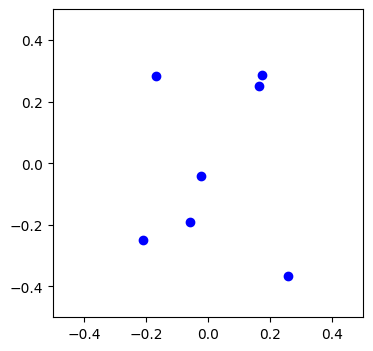

[np.float32(-14.999997), np.float32(-14.999999), np.float32(-14.999998), np.float32(-14.999992), np.float32(-14.999997), np.float32(-14.999996), np.float32(-14.999997), np.float32(-14.999992), np.float32(-14.999992), np.float32(-14.999999), np.float32(-14.999991), np.float32(-14.99999), np.float32(-14.999991), np.float32(-14.999991), np.float32(-14.999998), np.float32(-14.999997), np.float32(-14.999991), np.float32(-14.999992), np.float32(-14.999991), np.float32(-14.999999), np.float32(-14.99999), np.float32(-4.59999), np.float32(-14.999998), np.float32(-14.999994), np.float32(-14.999997), np.float32(-14.999998), np.float32(-14.999997), np.float32(-14.999994), np.float32(-14.999991), np.float32(-14.999998), np.float32(-15.0), np.float32(-14.999996), np.float32(-14.999992), np.float32(-14.999991), np.float32(-14.999994), np.float32(-14.99999), np.float32(-14.999998), np.float32(-14.999994), np.float32(-14.999994), np.float32(-14.999994), np.float32(-14.999995), np.float32(-14.999997), n

100%|█████████████████████████████████████████████| 7/7 [01:17<00:00, 11.02s/it]


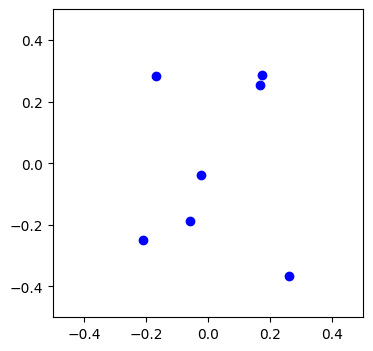

[np.float32(-15.006228), np.float32(-15.006357), np.float32(-15.005892), np.float32(-15.005188), np.float32(-15.006455), np.float32(-15.006571), np.float32(-15.005963), np.float32(-15.005177), np.float32(-15.00609), np.float32(-15.006127), np.float32(-15.005505), np.float32(-15.004827), np.float32(-15.005353), np.float32(-15.005301), np.float32(-15.004834), np.float32(-15.004345), np.float32(-15.007186), np.float32(-15.00752), np.float32(-15.00663), np.float32(-15.005622), np.float32(-15.00766), np.float32(-4.6099896), np.float32(-15.006689), np.float32(-15.005539), np.float32(-15.007071), np.float32(-15.007268), np.float32(-15.005379), np.float32(-15.004881), np.float32(-15.005891), np.float32(-15.005825), np.float32(-15.004553), np.float32(-15.004234), np.float32(-15.007291), np.float32(-15.007677), np.float32(-15.006909), np.float32(-15.005627), np.float32(-15.007762), np.float32(-15.00823), np.float32(-15.006717), np.float32(-15.005436), np.float32(-15.007075), np.float32(-15.00681

100%|█████████████████████████████████████████████| 7/7 [01:15<00:00, 10.83s/it]


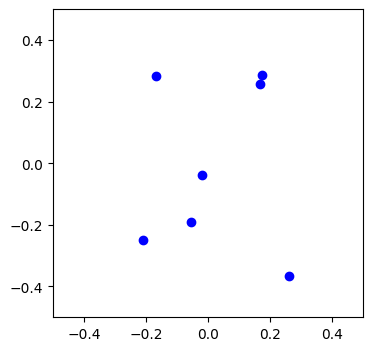

[np.float32(-15.012379), np.float32(-15.012639), np.float32(-15.011702), np.float32(-15.010282), np.float32(-15.012815), np.float32(-15.013045), np.float32(-15.011812), np.float32(-15.010223), np.float32(-15.012063), np.float32(-15.012109), np.float32(-15.010834), np.float32(-15.009473), np.float32(-15.010561), np.float32(-15.010421), np.float32(-15.009444), np.float32(-15.008472), np.float32(-15.014327), np.float32(-15.015012), np.float32(-15.013218), np.float32(-15.011154), np.float32(-15.015265), np.float32(-4.619974), np.float32(-15.013276), np.float32(-15.010935), np.float32(-15.014041), np.float32(-15.014394), np.float32(-15.01035), np.float32(-15.009491), np.float32(-15.011629), np.float32(-15.011402), np.float32(-15.008664), np.float32(-15.008149), np.float32(-15.014546), np.float32(-15.015338), np.float32(-15.01381), np.float32(-15.011178), np.float32(-15.015472), np.float32(-15.016423), np.float32(-15.013341), np.float32(-15.010712), np.float32(-15.014052), np.float32(-15.013

100%|█████████████████████████████████████████████| 7/7 [01:38<00:00, 14.01s/it]


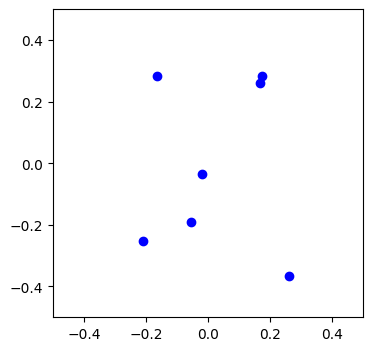

[np.float32(-15.01851), np.float32(-15.018898), np.float32(-15.017468), np.float32(-15.01531), np.float32(-15.019154), np.float32(-15.019486), np.float32(-15.017591), np.float32(-15.015175), np.float32(-15.017987), np.float32(-15.018016), np.float32(-15.016037), np.float32(-15.013976), np.float32(-15.015685), np.float32(-15.015421), np.float32(-15.013887), np.float32(-15.012429), np.float32(-15.02146), np.float32(-15.022497), np.float32(-15.019781), np.float32(-15.016624), np.float32(-15.0228615), np.float32(-4.629954), np.float32(-15.019789), np.float32(-15.016211), np.float32(-15.020969), np.float32(-15.021431), np.float32(-15.0149555), np.float32(-15.013853), np.float32(-15.017274), np.float32(-15.016798), np.float32(-15.012383), np.float32(-15.011777), np.float32(-15.021789), np.float32(-15.022993), np.float32(-15.020711), np.float32(-15.016656), np.float32(-15.023163), np.float32(-15.024591), np.float32(-15.0198765), np.float32(-15.015817), np.float32(-15.020973), np.float32(-15.0

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.53s/it]


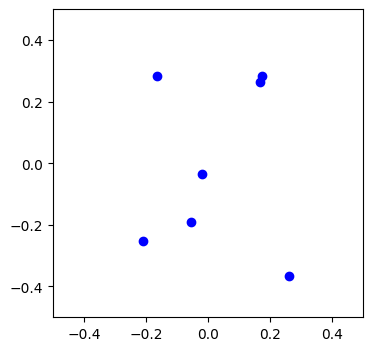

[np.float32(-15.024619), np.float32(-15.02513), np.float32(-15.023188), np.float32(-15.020269), np.float32(-15.025468), np.float32(-15.025893), np.float32(-15.023298), np.float32(-15.020026), np.float32(-15.023862), np.float32(-15.0238495), np.float32(-15.021114), np.float32(-15.018333), np.float32(-15.020726), np.float32(-15.020305), np.float32(-15.018167), np.float32(-15.016216), np.float32(-15.02858), np.float32(-15.029971), np.float32(-15.026311), np.float32(-15.022023), np.float32(-15.030445), np.float32(-4.639924), np.float32(-15.02622), np.float32(-15.021357), np.float32(-15.027855), np.float32(-15.028379), np.float32(-15.019185), np.float32(-15.017958), np.float32(-15.022826), np.float32(-15.022015), np.float32(-15.015708), np.float32(-15.015114), np.float32(-15.02901), np.float32(-15.030634), np.float32(-15.027594), np.float32(-15.02205), np.float32(-15.0308275), np.float32(-15.032733), np.float32(-15.026321), np.float32(-15.0207405), np.float32(-15.027833), np.float32(-15.025

100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.27s/it]


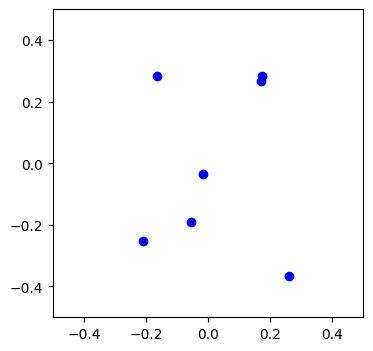

[np.float32(-15.030713), np.float32(-15.031343), np.float32(-15.02887), np.float32(-15.025171), np.float32(-15.031764), np.float32(-15.03227), np.float32(-15.028943), np.float32(-15.024791), np.float32(-15.029694), np.float32(-15.029617), np.float32(-15.026077), np.float32(-15.02256), np.float32(-15.025694), np.float32(-15.025082), np.float32(-15.022295), np.float32(-15.019848), np.float32(-15.035688), np.float32(-15.037436), np.float32(-15.032816), np.float32(-15.027364), np.float32(-15.038015), np.float32(-4.6498823), np.float32(-15.032581), np.float32(-15.026388), np.float32(-15.0346985), np.float32(-15.035241), np.float32(-15.023049), np.float32(-15.021821), np.float32(-15.028292), np.float32(-15.027061), np.float32(-15.018649), np.float32(-15.018178), np.float32(-15.036211), np.float32(-15.038261), np.float32(-15.034467), np.float32(-15.027371), np.float32(-15.038464), np.float32(-15.040843), np.float32(-15.032676), np.float32(-15.025493), np.float32(-15.034631), np.float32(-15.03

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.33s/it]


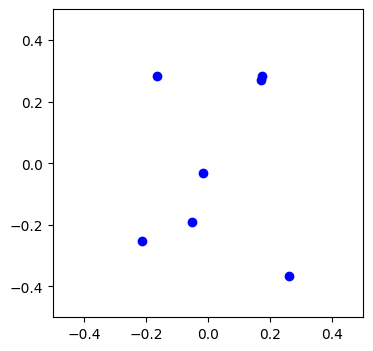

[np.float32(-15.036772), np.float32(-15.037518), np.float32(-15.034492), np.float32(-15.029988), np.float32(-15.038019), np.float32(-15.038593), np.float32(-15.0344925), np.float32(-15.02943), np.float32(-15.035452), np.float32(-15.03528), np.float32(-15.030871), np.float32(-15.026602), np.float32(-15.030549), np.float32(-15.0297), np.float32(-15.026207), np.float32(-15.023264), np.float32(-15.042772), np.float32(-15.044881), np.float32(-15.039281), np.float32(-15.032621), np.float32(-15.045555), np.float32(-4.659816), np.float32(-15.038837), np.float32(-15.03126), np.float32(-15.041473), np.float32(-15.041967), np.float32(-15.026362), np.float32(-15.025348), np.float32(-15.0336275), np.float32(-15.031856), np.float32(-15.021031), np.float32(-15.020861), np.float32(-15.043378), np.float32(-15.045868), np.float32(-15.0413265), np.float32(-15.032601), np.float32(-15.046053), np.float32(-15.048907), np.float32(-15.038912), np.float32(-15.030028), np.float32(-15.041334), np.float32(-15.037

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.64s/it]


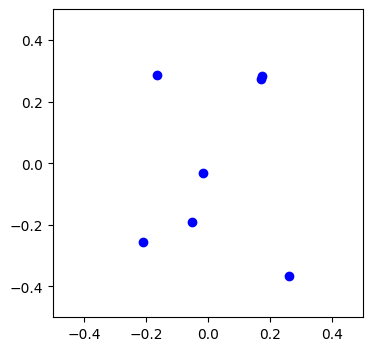

[np.float32(-15.042794), np.float32(-15.043651), np.float32(-15.040048), np.float32(-15.034714), np.float32(-15.044232), np.float32(-15.04486), np.float32(-15.039938), np.float32(-15.033934), np.float32(-15.041134), np.float32(-15.04083), np.float32(-15.035479), np.float32(-15.030438), np.float32(-15.035283), np.float32(-15.034146), np.float32(-15.029878), np.float32(-15.026439), np.float32(-15.04983), np.float32(-15.052304), np.float32(-15.045701), np.float32(-15.037788), np.float32(-15.053066), np.float32(-4.6697206), np.float32(-15.044975), np.float32(-15.035954), np.float32(-15.048176), np.float32(-15.048541), np.float32(-15.029019), np.float32(-15.028489), np.float32(-15.038824), np.float32(-15.036366), np.float32(-15.022767), np.float32(-15.023108), np.float32(-15.0505085), np.float32(-15.05345), np.float32(-15.048166), np.float32(-15.037728), np.float32(-15.053595), np.float32(-15.05692), np.float32(-15.045012), np.float32(-15.034319), np.float32(-15.047936), np.float32(-15.0421

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.52s/it]


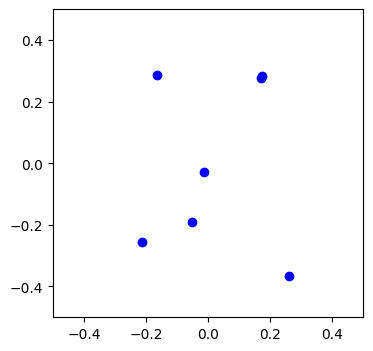

[np.float32(-15.048777), np.float32(-15.049738), np.float32(-15.045536), np.float32(-15.039346), np.float32(-15.050399), np.float32(-15.0510645), np.float32(-15.045277), np.float32(-15.038299), np.float32(-15.046734), np.float32(-15.046261), np.float32(-15.039895), np.float32(-15.034066), np.float32(-15.039894), np.float32(-15.038416), np.float32(-15.033302), np.float32(-15.029368), np.float32(-15.056859), np.float32(-15.059701), np.float32(-15.052073), np.float32(-15.042861), np.float32(-15.060542), np.float32(-4.679591), np.float32(-15.050989), np.float32(-15.040464), np.float32(-15.054801), np.float32(-15.0549555), np.float32(-15.030998), np.float32(-15.031227), np.float32(-15.043877), np.float32(-15.040583), np.float32(-15.0238495), np.float32(-15.024904), np.float32(-15.0576), np.float32(-15.061003), np.float32(-15.054981), np.float32(-15.042741), np.float32(-15.061086), np.float32(-15.0648775), np.float32(-15.0509615), np.float32(-15.038329), np.float32(-15.054435), np.float32(-1

100%|█████████████████████████████████████████████| 7/7 [00:45<00:00,  6.55s/it]


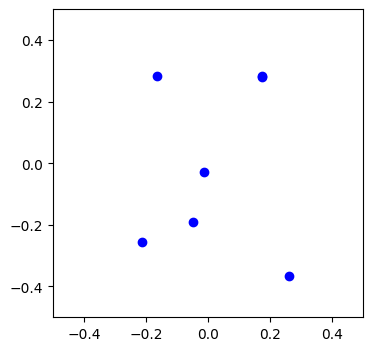

[np.float32(-15.054721), np.float32(-15.05578), np.float32(-15.050947), np.float32(-15.043867), np.float32(-15.056523), np.float32(-15.057207), np.float32(-15.050489), np.float32(-15.042496), np.float32(-15.052249), np.float32(-15.051559), np.float32(-15.044079), np.float32(-15.037437), np.float32(-15.044365), np.float32(-15.042477), np.float32(-15.036426), np.float32(-15.031997), np.float32(-15.06386), np.float32(-15.067073), np.float32(-15.05839), np.float32(-15.047822), np.float32(-15.067989), np.float32(-4.6894264), np.float32(-15.056854), np.float32(-15.044747), np.float32(-15.061344), np.float32(-15.061181), np.float32(-15.032126), np.float32(-15.033456), np.float32(-15.048764), np.float32(-15.044438), np.float32(-15.024149), np.float32(-15.026147), np.float32(-15.064648), np.float32(-15.068525), np.float32(-15.061775), np.float32(-15.047626), np.float32(-15.0685215), np.float32(-15.072773), np.float32(-15.056738), np.float32(-15.042013), np.float32(-15.060812), np.float32(-15.05

100%|█████████████████████████████████████████████| 7/7 [00:41<00:00,  5.89s/it]


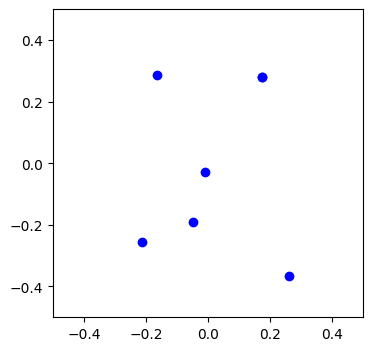

[np.float32(-15.060603), np.float32(-15.061752), np.float32(-15.056252), np.float32(-15.048243), np.float32(-15.062576), np.float32(-15.063255), np.float32(-15.055534), np.float32(-15.046476), np.float32(-15.057644), np.float32(-15.05668), np.float32(-15.047964), np.float32(-15.040485), np.float32(-15.048655), np.float32(-15.046271), np.float32(-15.039171), np.float32(-15.034254), np.float32(-15.070815), np.float32(-15.074402), np.float32(-15.064627), np.float32(-15.052633), np.float32(-15.075385), np.float32(-4.6992035), np.float32(-15.06252), np.float32(-15.048738), np.float32(-15.067774), np.float32(-15.06716), np.float32(-15.032277), np.float32(-15.035061), np.float32(-15.05344), np.float32(-15.047842), np.float32(-15.023594), np.float32(-15.026739), np.float32(-15.071638), np.float32(-15.076004), np.float32(-15.068532), np.float32(-15.05235), np.float32(-15.075883), np.float32(-15.080586), np.float32(-15.062295), np.float32(-15.0453), np.float32(-15.067036), np.float32(-15.05391),

100%|█████████████████████████████████████████████| 7/7 [00:42<00:00,  6.05s/it]


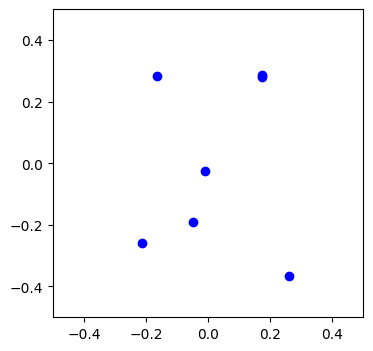

[np.float32(-15.06644), np.float32(-15.067672), np.float32(-15.061471), np.float32(-15.052499), np.float32(-15.068579), np.float32(-15.069232), np.float32(-15.060443), np.float32(-15.050274), np.float32(-15.0629425), np.float32(-15.061651), np.float32(-15.05159), np.float32(-15.04325), np.float32(-15.052789), np.float32(-15.049832), np.float32(-15.041581), np.float32(-15.0361805), np.float32(-15.077737), np.float32(-15.081702), np.float32(-15.070804), np.float32(-15.0573225), np.float32(-15.082747), np.float32(-4.7089396), np.float32(-15.068023), np.float32(-15.052476), np.float32(-15.074112), np.float32(-15.072921), np.float32(-15.03161), np.float32(-15.036112), np.float32(-15.057929), np.float32(-15.050822), np.float32(-15.022331), np.float32(-15.026765), np.float32(-15.078583), np.float32(-15.083452), np.float32(-15.075259), np.float32(-15.056932), np.float32(-15.083188), np.float32(-15.088337), np.float32(-15.067659), np.float32(-15.048212), np.float32(-15.073128), np.float32(-15.0

100%|█████████████████████████████████████████████| 7/7 [00:42<00:00,  6.04s/it]


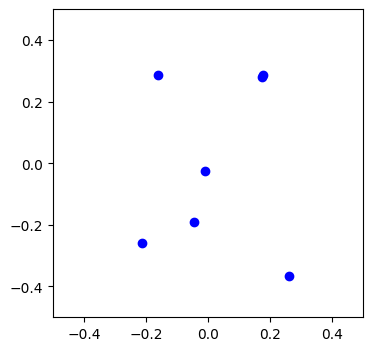

[np.float32(-15.072203), np.float32(-15.073507), np.float32(-15.066565), np.float32(-15.056584), np.float32(-15.074495), np.float32(-15.075095), np.float32(-15.065153), np.float32(-15.053816), np.float32(-15.068098), np.float32(-15.066408), np.float32(-15.054857), np.float32(-15.0456295), np.float32(-15.056706), np.float32(-15.053073), np.float32(-15.043541), np.float32(-15.037669), np.float32(-15.084604), np.float32(-15.088953), np.float32(-15.076886), np.float32(-15.061835), np.float32(-15.090047), np.float32(-4.7186027), np.float32(-15.073287), np.float32(-15.055859), np.float32(-15.080314), np.float32(-15.078378), np.float32(-15.030017), np.float32(-15.036453), np.float32(-15.062161), np.float32(-15.053241), np.float32(-15.020291), np.float32(-15.026109), np.float32(-15.085459), np.float32(-15.090848), np.float32(-15.081936), np.float32(-15.06131), np.float32(-15.090405), np.float32(-15.09599), np.float32(-15.072745), np.float32(-15.050603), np.float32(-15.079035), np.float32(-15.0

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.42s/it]


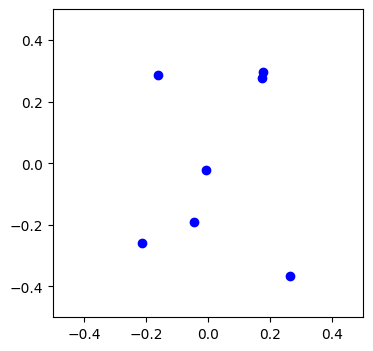

[np.float32(-15.077892), np.float32(-15.079262), np.float32(-15.071539), np.float32(-15.060508), np.float32(-15.080327), np.float32(-15.080849), np.float32(-15.069673), np.float32(-15.057112), np.float32(-15.0731125), np.float32(-15.070955), np.float32(-15.057775), np.float32(-15.047637), np.float32(-15.060412), np.float32(-15.056), np.float32(-15.045065), np.float32(-15.038738), np.float32(-15.091416), np.float32(-15.096156), np.float32(-15.082881), np.float32(-15.066181), np.float32(-15.097284), np.float32(-4.728194), np.float32(-15.078323), np.float32(-15.058901), np.float32(-15.086381), np.float32(-15.08353), np.float32(-15.027632), np.float32(-15.036144), np.float32(-15.066141), np.float32(-15.055109), np.float32(-15.017589), np.float32(-15.024848), np.float32(-15.092267), np.float32(-15.098195), np.float32(-15.088563), np.float32(-15.0654955), np.float32(-15.097536), np.float32(-15.10355), np.float32(-15.077564), np.float32(-15.052497), np.float32(-15.084759), np.float32(-15.0588

100%|█████████████████████████████████████████████| 7/7 [00:40<00:00,  5.85s/it]


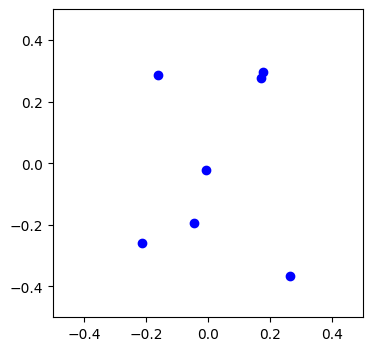

[np.float32(-15.083448), np.float32(-15.0848675), np.float32(-15.0763035), np.float32(-15.064156), np.float32(-15.086005), np.float32(-15.086404), np.float32(-15.073864), np.float32(-15.059997), np.float32(-15.077886), np.float32(-15.075145), np.float32(-15.060114), np.float32(-15.049046), np.float32(-15.063768), np.float32(-15.058413), np.float32(-15.045907), np.float32(-15.039162), np.float32(-15.098129), np.float32(-15.103267), np.float32(-15.088714), np.float32(-15.070241), np.float32(-15.104413), np.float32(-4.7376523), np.float32(-15.082956), np.float32(-15.061374), np.float32(-15.092222), np.float32(-15.088179), np.float32(-15.024292), np.float32(-15.034931), np.float32(-15.069706), np.float32(-15.056125), np.float32(-15.014088), np.float32(-15.022795), np.float32(-15.098962), np.float32(-15.105453), np.float32(-15.095099), np.float32(-15.069355), np.float32(-15.104528), np.float32(-15.110954), np.float32(-15.0819235), np.float32(-15.053605), np.float32(-15.090185), np.float32(-

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.52s/it]


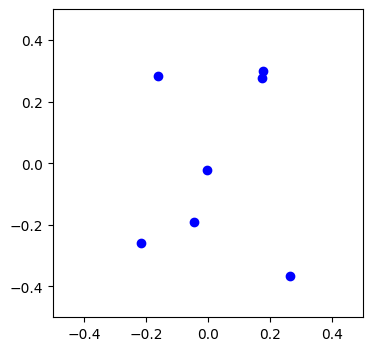

[np.float32(-15.088879), np.float32(-15.090331), np.float32(-15.080864), np.float32(-15.067533), np.float32(-15.091537), np.float32(-15.09177), np.float32(-15.077735), np.float32(-15.062477), np.float32(-15.082428), np.float32(-15.078987), np.float32(-15.061893), np.float32(-15.049881), np.float32(-15.066788), np.float32(-15.06033), np.float32(-15.046113), np.float32(-15.038987), np.float32(-15.104748), np.float32(-15.110289), np.float32(-15.094386), np.float32(-15.074017), np.float32(-15.111438), np.float32(-4.7469826), np.float32(-15.087191), np.float32(-15.063285), np.float32(-15.097846), np.float32(-15.092332), np.float32(-15.020172), np.float32(-15.032934), np.float32(-15.072869), np.float32(-15.05635), np.float32(-15.009922), np.float32(-15.020067), np.float32(-15.105548), np.float32(-15.112623), np.float32(-15.101547), np.float32(-15.072891), np.float32(-15.111388), np.float32(-15.11821), np.float32(-15.085833), np.float32(-15.053964), np.float32(-15.095324), np.float32(-15.0567

100%|█████████████████████████████████████████████| 7/7 [00:40<00:00,  5.79s/it]


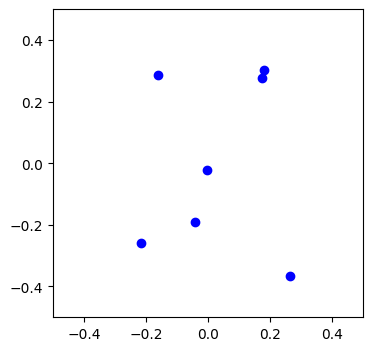

[np.float32(-15.09418), np.float32(-15.095651), np.float32(-15.085216), np.float32(-15.070631), np.float32(-15.096919), np.float32(-15.09694), np.float32(-15.081269), np.float32(-15.064538), np.float32(-15.086726), np.float32(-15.08246), np.float32(-15.063088), np.float32(-15.050134), np.float32(-15.069448), np.float32(-15.061727), np.float32(-15.04568), np.float32(-15.038223), np.float32(-15.111269), np.float32(-15.117221), np.float32(-15.099897), np.float32(-15.0775), np.float32(-15.118354), np.float32(-4.7561755), np.float32(-15.091005), np.float32(-15.064617), np.float32(-15.103236), np.float32(-15.095941), np.float32(-15.015361), np.float32(-15.030219), np.float32(-15.0756), np.float32(-15.055775), np.float32(-15.0051565), np.float32(-15.016723), np.float32(-15.1120205), np.float32(-15.119704), np.float32(-15.1079035), np.float32(-15.076097), np.float32(-15.118103), np.float32(-15.125303), np.float32(-15.089272), np.float32(-15.053587), np.float32(-15.100145), np.float32(-15.05420

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.61s/it]


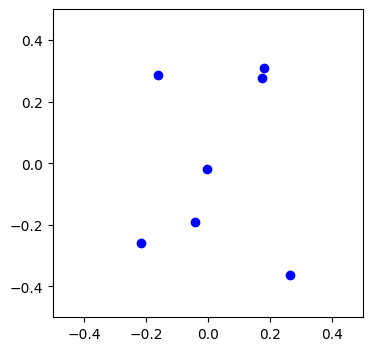

[np.float32(-15.099367), np.float32(-15.1008415), np.float32(-15.089378), np.float32(-15.073477), np.float32(-15.102164), np.float32(-15.101931), np.float32(-15.084492), np.float32(-15.066213), np.float32(-15.090799), np.float32(-15.085588), np.float32(-15.063745), np.float32(-15.049862), np.float32(-15.071775), np.float32(-15.062638), np.float32(-15.044679), np.float32(-15.036941), np.float32(-15.117705), np.float32(-15.124075), np.float32(-15.105267), np.float32(-15.080722), np.float32(-15.125172), np.float32(-4.7652426), np.float32(-15.094429), np.float32(-15.065425), np.float32(-15.108409), np.float32(-15.09903), np.float32(-15.009973), np.float32(-15.026901), np.float32(-15.077925), np.float32(-15.054488), np.float32(-14.999885), np.float32(-15.012857), np.float32(-15.118391), np.float32(-15.126707), np.float32(-15.114186), np.float32(-15.079012), np.float32(-15.124685), np.float32(-15.13225), np.float32(-15.092281), np.float32(-15.052584), np.float32(-15.1046715), np.float32(-15.

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.43s/it]


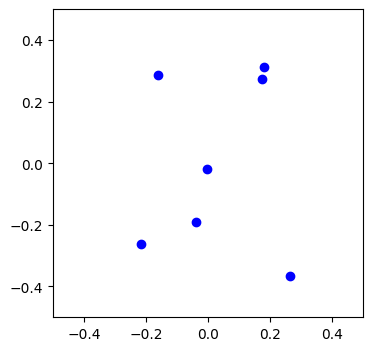

[np.float32(-15.104366), np.float32(-15.1058235), np.float32(-15.093249), np.float32(-15.075946), np.float32(-15.107187), np.float32(-15.106635), np.float32(-15.087251), np.float32(-15.067335), np.float32(-15.094526), np.float32(-15.0882015), np.float32(-15.06367), np.float32(-15.048905), np.float32(-15.073617), np.float32(-15.062885), np.float32(-15.042966), np.float32(-15.035013), np.float32(-15.124), np.float32(-15.130798), np.float32(-15.11041), np.float32(-15.0835495), np.float32(-15.131827), np.float32(-4.774103), np.float32(-15.09727), np.float32(-15.065511), np.float32(-15.113251), np.float32(-15.101376), np.float32(-15.003966), np.float32(-15.022891), np.float32(-15.079668), np.float32(-15.052337), np.float32(-14.994058), np.float32(-15.008397), np.float32(-15.124604), np.float32(-15.133586), np.float32(-15.120344), np.float32(-15.081488), np.float32(-15.131068), np.float32(-15.138974), np.float32(-15.09466), np.float32(-15.050776), np.float32(-15.108761), np.float32(-15.04640

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.33s/it]


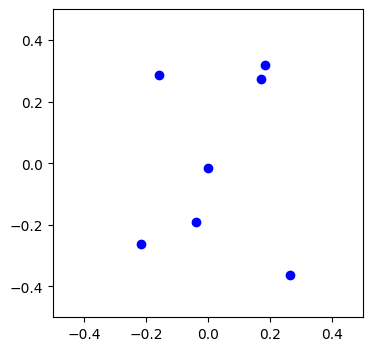

[np.float32(-15.109195), np.float32(-15.110614), np.float32(-15.096845), np.float32(-15.078055), np.float32(-15.112009), np.float32(-15.111075), np.float32(-15.089565), np.float32(-15.067935), np.float32(-15.09793), np.float32(-15.090326), np.float32(-15.0629225), np.float32(-15.04733), np.float32(-15.074999), np.float32(-15.062515), np.float32(-15.040621), np.float32(-15.032513), np.float32(-15.130166), np.float32(-15.137403), np.float32(-15.11534), np.float32(-15.085999), np.float32(-15.138342), np.float32(-4.782773), np.float32(-15.099546), np.float32(-15.064926), np.float32(-15.117784), np.float32(-15.103008), np.float32(-14.997429), np.float32(-15.018283), np.float32(-15.08086), np.float32(-15.04943), np.float32(-14.987746), np.float32(-15.003417), np.float32(-15.130672), np.float32(-15.140348), np.float32(-15.126384), np.float32(-15.083533), np.float32(-15.13727), np.float32(-15.145488), np.float32(-15.096411), np.float32(-15.048244), np.float32(-15.112435), np.float32(-15.041244

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.63s/it]


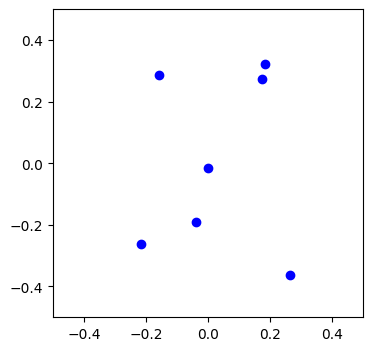

[np.float32(-15.113812), np.float32(-15.115167), np.float32(-15.100103), np.float32(-15.079731), np.float32(-15.116585), np.float32(-15.115193), np.float32(-15.091349), np.float32(-15.06793), np.float32(-15.100942), np.float32(-15.091872), np.float32(-15.0614395), np.float32(-15.045094), np.float32(-15.075843), np.float32(-15.061463), np.float32(-15.03762), np.float32(-15.029416), np.float32(-15.136174), np.float32(-15.143858), np.float32(-15.120006), np.float32(-15.087987), np.float32(-15.144681), np.float32(-4.7912083), np.float32(-15.101154), np.float32(-15.063599), np.float32(-15.121941), np.float32(-15.103815), np.float32(-14.990379), np.float32(-15.013079), np.float32(-15.081412), np.float32(-15.04576), np.float32(-14.980959), np.float32(-14.997915), np.float32(-15.136558), np.float32(-15.146967), np.float32(-15.132277), np.float32(-15.085062), np.float32(-15.143245), np.float32(-15.151748), np.float32(-15.0974455), np.float32(-15.04497), np.float32(-15.1156025), np.float32(-15.0

100%|█████████████████████████████████████████████| 7/7 [00:41<00:00,  5.90s/it]


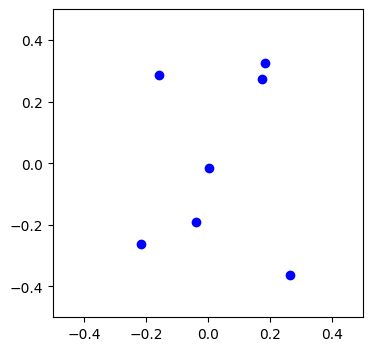

[np.float32(-15.118219), np.float32(-15.119481), np.float32(-15.103018), np.float32(-15.080967), np.float32(-15.120912), np.float32(-15.118981), np.float32(-15.09259), np.float32(-15.06733), np.float32(-15.103553), np.float32(-15.092828), np.float32(-15.0592575), np.float32(-15.04224), np.float32(-15.076144), np.float32(-15.059754), np.float32(-15.034013), np.float32(-15.025769), np.float32(-15.142026), np.float32(-15.1501665), np.float32(-15.124402), np.float32(-15.089509), np.float32(-15.150846), np.float32(-4.7994018), np.float32(-15.10208), np.float32(-15.061568), np.float32(-15.125709), np.float32(-15.103791), np.float32(-14.982867), np.float32(-15.007337), np.float32(-15.081321), np.float32(-15.041393), np.float32(-14.973736), np.float32(-14.991938), np.float32(-15.142261), np.float32(-15.153441), np.float32(-15.138022), np.float32(-15.086078), np.float32(-15.148987), np.float32(-15.157744), np.float32(-15.097763), np.float32(-15.041026), np.float32(-15.118242), np.float32(-15.02

100%|█████████████████████████████████████████████| 7/7 [00:41<00:00,  5.95s/it]


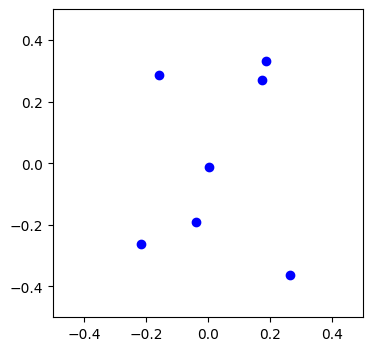

[np.float32(-15.122369), np.float32(-15.1235075), np.float32(-15.105533), np.float32(-15.081709), np.float32(-15.1249275), np.float32(-15.122368), np.float32(-15.093216), np.float32(-15.066093), np.float32(-15.105683), np.float32(-15.093108), np.float32(-15.056359), np.float32(-15.038766), np.float32(-15.075839), np.float32(-15.057359), np.float32(-15.029803), np.float32(-15.021573), np.float32(-15.147686), np.float32(-15.156299), np.float32(-15.128487), np.float32(-15.090509), np.float32(-15.156792), np.float32(-4.8072987), np.float32(-15.102247), np.float32(-15.058822), np.float32(-15.129011), np.float32(-15.102855), np.float32(-14.974911), np.float32(-15.001075), np.float32(-15.080525), np.float32(-15.036348), np.float32(-14.966089), np.float32(-14.985495), np.float32(-15.147755), np.float32(-15.159751), np.float32(-15.143602), np.float32(-15.086532), np.float32(-15.154466), np.float32(-15.163442), np.float32(-15.097315), np.float32(-15.036436), np.float32(-15.120284), np.float32(-1

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.60s/it]


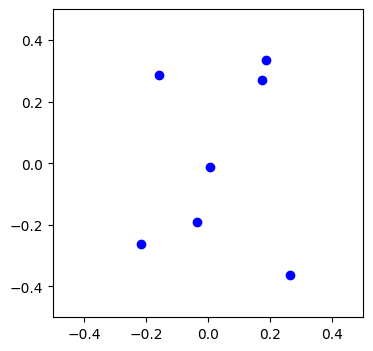

[np.float32(-15.126234), np.float32(-15.127215), np.float32(-15.107605), np.float32(-15.081917), np.float32(-15.128601), np.float32(-15.125311), np.float32(-15.093184), np.float32(-15.064205), np.float32(-15.107294), np.float32(-15.092682), np.float32(-15.052766), np.float32(-15.03469), np.float32(-15.074907), np.float32(-15.054293), np.float32(-15.025018), np.float32(-15.016846), np.float32(-15.153136), np.float32(-15.162235), np.float32(-15.132221), np.float32(-15.090939), np.float32(-15.162497), np.float32(-4.814861), np.float32(-15.101611), np.float32(-15.055368), np.float32(-15.131806), np.float32(-15.1010065), np.float32(-14.966539), np.float32(-14.994319), np.float32(-15.079014), np.float32(-15.030674), np.float32(-14.958042), np.float32(-14.978606), np.float32(-15.153018), np.float32(-15.165878), np.float32(-15.148997), np.float32(-15.086373), np.float32(-15.159652), np.float32(-15.168804), np.float32(-15.09606), np.float32(-15.031222), np.float32(-15.121681), np.float32(-15.01

100%|█████████████████████████████████████████████| 7/7 [00:40<00:00,  5.72s/it]


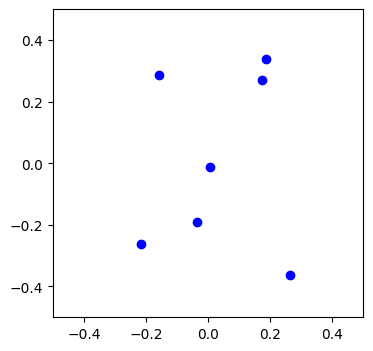

[np.float32(-15.129783), np.float32(-15.130569), np.float32(-15.109193), np.float32(-15.081557), np.float32(-15.131896), np.float32(-15.127765), np.float32(-15.092461), np.float32(-15.061663), np.float32(-15.108334), np.float32(-15.091514), np.float32(-15.048497), np.float32(-15.03003), np.float32(-15.073322), np.float32(-15.050563), np.float32(-15.019673), np.float32(-15.011601), np.float32(-15.158354), np.float32(-15.167958), np.float32(-15.135572), np.float32(-15.090762), np.float32(-15.167938), np.float32(-4.8220525), np.float32(-15.100148), np.float32(-15.051232), np.float32(-15.134038), np.float32(-15.098233), np.float32(-14.957773), np.float32(-14.987091), np.float32(-15.076766), np.float32(-15.024399), np.float32(-14.949608), np.float32(-14.971286), np.float32(-15.158025), np.float32(-15.171808), np.float32(-15.1542015), np.float32(-15.085574), np.float32(-15.164515), np.float32(-15.1738), np.float32(-15.093988), np.float32(-15.025415), np.float32(-15.122371), np.float32(-15.00

100%|█████████████████████████████████████████████| 7/7 [00:46<00:00,  6.66s/it]


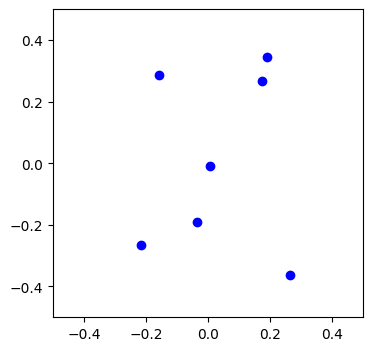

[np.float32(-15.133024), np.float32(-15.13358), np.float32(-15.110315), np.float32(-15.080669), np.float32(-15.134817), np.float32(-15.129739), np.float32(-15.091092), np.float32(-15.058534), np.float32(-15.108823), np.float32(-15.089659), np.float32(-15.043637), np.float32(-15.0248575), np.float32(-15.071139), np.float32(-15.046248), np.float32(-15.01384), np.float32(-15.005902), np.float32(-15.163345), np.float32(-15.173474), np.float32(-15.138555), np.float32(-15.090021), np.float32(-15.173118), np.float32(-4.8288746), np.float32(-15.097929), np.float32(-15.0465), np.float32(-15.135717), np.float32(-15.094628), np.float32(-14.948657), np.float32(-14.97945), np.float32(-15.073854), np.float32(-15.017604), np.float32(-14.94083), np.float32(-14.963586), np.float32(-15.162786), np.float32(-15.17755), np.float32(-15.159222), np.float32(-15.084191), np.float32(-15.16906), np.float32(-15.178439), np.float32(-15.09119), np.float32(-15.0191), np.float32(-15.122384), np.float32(-14.9969225), 

100%|█████████████████████████████████████████████| 7/7 [00:44<00:00,  6.40s/it]


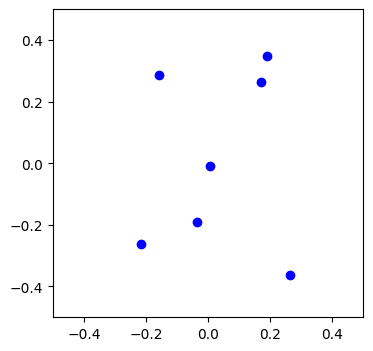

[np.float32(-15.135901), np.float32(-15.13618), np.float32(-15.110883), np.float32(-15.079173), np.float32(-15.1373), np.float32(-15.131147), np.float32(-15.089002), np.float32(-15.0547695), np.float32(-15.108678), np.float32(-15.087054), np.float32(-15.038162), np.float32(-15.019146), np.float32(-15.068306), np.float32(-15.041323), np.float32(-15.007498), np.float32(-14.9997225), np.float32(-15.16807), np.float32(-15.178742), np.float32(-15.141078), np.float32(-15.088622), np.float32(-15.177988), np.float32(-4.8352447), np.float32(-15.094877), np.float32(-15.041139), np.float32(-15.136749), np.float32(-15.090159), np.float32(-14.939184), np.float32(-14.97138), np.float32(-15.070234), np.float32(-15.010283), np.float32(-14.931698), np.float32(-14.955485), np.float32(-15.16725), np.float32(-15.183061), np.float32(-15.164002), np.float32(-15.082128), np.float32(-15.173221), np.float32(-15.182637), np.float32(-15.0876045), np.float32(-15.012248), np.float32(-15.121619), np.float32(-14.987

100%|█████████████████████████████████████████████| 7/7 [00:42<00:00,  6.01s/it]


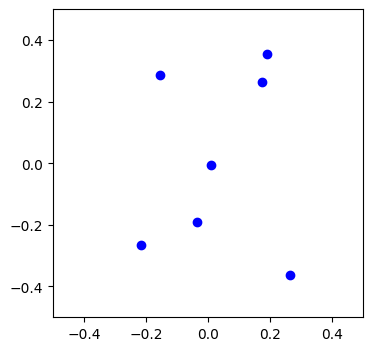

[np.float32(-15.138391), np.float32(-15.13835), np.float32(-15.110897), np.float32(-15.0771), np.float32(-15.139312), np.float32(-15.131969), np.float32(-15.086229), np.float32(-15.0504265), np.float32(-15.107893), np.float32(-15.08374), np.float32(-15.032134), np.float32(-15.012948), np.float32(-15.064861), np.float32(-15.03584), np.float32(-15.000695), np.float32(-14.993106), np.float32(-15.172508), np.float32(-15.18375), np.float32(-15.143143), np.float32(-15.086601), np.float32(-15.182526), np.float32(-4.8411384), np.float32(-15.091062), np.float32(-15.035216), np.float32(-15.13712), np.float32(-15.084908), np.float32(-14.929388), np.float32(-14.962923), np.float32(-15.06596), np.float32(-15.002491), np.float32(-14.922241), np.float32(-14.947022), np.float32(-15.171408), np.float32(-15.188336), np.float32(-15.16855), np.float32(-15.079431), np.float32(-15.1769905), np.float32(-15.186395), np.float32(-15.083301), np.float32(-15.004917), np.float32(-15.120102), np.float32(-14.978267)

100%|█████████████████████████████████████████████| 7/7 [00:46<00:00,  6.63s/it]


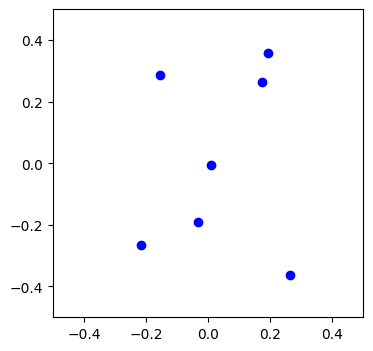

[np.float32(-15.140476), np.float32(-15.140069), np.float32(-15.110339), np.float32(-15.0744505), np.float32(-15.140835), np.float32(-15.132181), np.float32(-15.082784), np.float32(-15.045523), np.float32(-15.106457), np.float32(-15.079736), np.float32(-15.0255785), np.float32(-15.006282), np.float32(-15.06082), np.float32(-15.029824), np.float32(-14.993449), np.float32(-14.986068), np.float32(-15.176651), np.float32(-15.188489), np.float32(-15.144722), np.float32(-15.083961), np.float32(-15.186713), np.float32(-4.846516), np.float32(-15.086506), np.float32(-15.02876), np.float32(-15.136798), np.float32(-15.078914), np.float32(-14.919281), np.float32(-14.954095), np.float32(-15.061053), np.float32(-14.994251), np.float32(-14.912472), np.float32(-14.938209), np.float32(-15.175241), np.float32(-15.19337), np.float32(-15.17286), np.float32(-15.0761175), np.float32(-15.180334), np.float32(-15.1896715), np.float32(-15.07831), np.float32(-14.997138), np.float32(-15.11781), np.float32(-14.968

100%|█████████████████████████████████████████████| 7/7 [00:42<00:00,  6.09s/it]


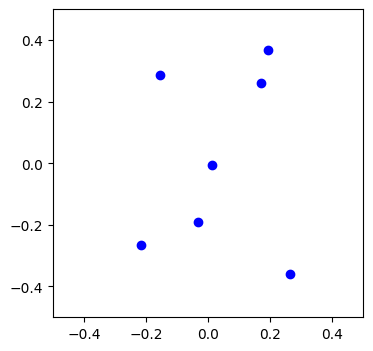

[np.float32(-15.142123), np.float32(-15.141304), np.float32(-15.109191), np.float32(-15.071234), np.float32(-15.141829), np.float32(-15.131751), np.float32(-15.078686), np.float32(-15.040086), np.float32(-15.104358), np.float32(-15.075066), np.float32(-15.018527), np.float32(-14.999172), np.float32(-15.056201), np.float32(-15.023303), np.float32(-14.985783), np.float32(-14.978626), np.float32(-15.180467), np.float32(-15.19293), np.float32(-15.145788), np.float32(-15.080711), np.float32(-15.190518), np.float32(-4.8513336), np.float32(-15.081251), np.float32(-15.021804), np.float32(-15.135759), np.float32(-15.072232), np.float32(-14.908878), np.float32(-14.944915), np.float32(-15.055545), np.float32(-14.985592), np.float32(-14.902402), np.float32(-14.929059), np.float32(-15.178724), np.float32(-15.198139), np.float32(-15.1769285), np.float32(-15.0722065), np.float32(-15.183226), np.float32(-15.192445), np.float32(-15.072688), np.float32(-14.988938), np.float32(-15.114756), np.float32(-14

100%|█████████████████████████████████████████████| 7/7 [00:41<00:00,  5.91s/it]


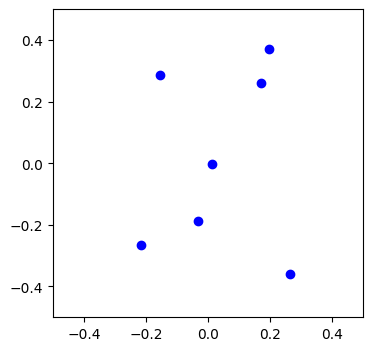

[np.float32(-15.143235), np.float32(-15.141952), np.float32(-15.107364), np.float32(-15.067395), np.float32(-15.142185), np.float32(-15.130572), np.float32(-15.073892), np.float32(-15.034086), np.float32(-15.101518), np.float32(-15.069695), np.float32(-15.0109625), np.float32(-14.991597), np.float32(-15.050971), np.float32(-15.016256), np.float32(-14.977676), np.float32(-14.970759), np.float32(-15.183878), np.float32(-15.197003), np.float32(-15.146236), np.float32(-15.076797), np.float32(-15.193854), np.float32(-4.8554606), np.float32(-15.075272), np.float32(-15.014329), np.float32(-15.133904), np.float32(-15.064861), np.float32(-14.89817), np.float32(-14.935368), np.float32(-15.049412), np.float32(-14.976504), np.float32(-14.892019), np.float32(-14.919557), np.float32(-15.181775), np.float32(-15.202582), np.float32(-15.180701), np.float32(-15.067648), np.float32(-15.185571), np.float32(-15.194613), np.float32(-15.066418), np.float32(-14.980301), np.float32(-15.110872), np.float32(-14.

100%|█████████████████████████████████████████████| 7/7 [00:43<00:00,  6.19s/it]


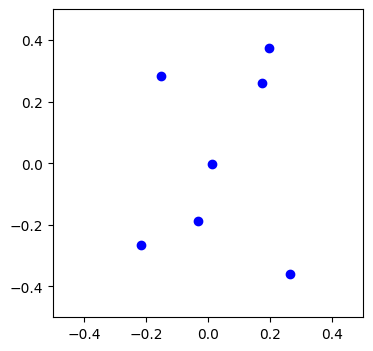

[np.float32(-15.14385), np.float32(-15.142054), np.float32(-15.104919), np.float32(-15.0630045), np.float32(-15.141953), np.float32(-15.12871), np.float32(-15.068485), np.float32(-15.02759), np.float32(-15.098016), np.float32(-15.063714), np.float32(-15.002947), np.float32(-14.98361), np.float32(-15.045202), np.float32(-15.008747), np.float32(-14.96918), np.float32(-14.962512), np.float32(-15.1869135), np.float32(-15.200733), np.float32(-15.146107), np.float32(-15.072292), np.float32(-15.196749), np.float32(-4.858922), np.float32(-15.068661), np.float32(-15.006399), np.float32(-15.131302), np.float32(-15.056893), np.float32(-14.887188), np.float32(-14.925492), np.float32(-15.042731), np.float32(-14.967036), np.float32(-14.881353), np.float32(-14.909737), np.float32(-15.184421), np.float32(-15.206721), np.float32(-15.184194), np.float32(-15.062526), np.float32(-15.187391), np.float32(-15.196199), np.float32(-15.059587), np.float32(-14.97128), np.float32(-15.106248), np.float32(-14.93666

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.66s/it]


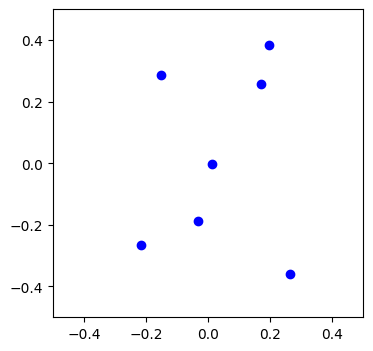

[np.float32(-15.143946), np.float32(-15.141591), np.float32(-15.101867), np.float32(-15.058085), np.float32(-15.141112), np.float32(-15.126163), np.float32(-15.062503), np.float32(-15.020628), np.float32(-15.093873), np.float32(-15.057162), np.float32(-14.994512), np.float32(-14.975236), np.float32(-15.038928), np.float32(-15.000807), np.float32(-14.960319), np.float32(-14.953908), np.float32(-15.189548), np.float32(-15.2041), np.float32(-15.145386), np.float32(-15.0672245), np.float32(-15.199172), np.float32(-4.861681), np.float32(-15.061469), np.float32(-14.998045), np.float32(-15.127966), np.float32(-15.048386), np.float32(-14.875948), np.float32(-14.91531), np.float32(-15.0355425), np.float32(-14.957217), np.float32(-14.870422), np.float32(-14.899618), np.float32(-15.18664), np.float32(-15.210544), np.float32(-15.187402), np.float32(-15.056868), np.float32(-15.188668), np.float32(-15.19719), np.float32(-15.052242), np.float32(-14.961902), np.float32(-15.100927), np.float32(-14.9254

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.59s/it]


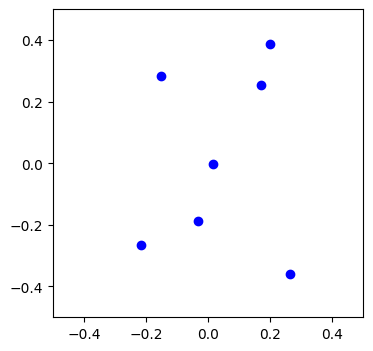

[np.float32(-15.143485), np.float32(-15.140531), np.float32(-15.0982), np.float32(-15.052646), np.float32(-15.1396265), np.float32(-15.122914), np.float32(-15.055961), np.float32(-15.013211), np.float32(-15.089088), np.float32(-15.050056), np.float32(-14.985667), np.float32(-14.966481), np.float32(-15.032155), np.float32(-14.992443), np.float32(-14.951096), np.float32(-14.944949), np.float32(-15.191745), np.float32(-15.207071), np.float32(-15.14405), np.float32(-15.061606), np.float32(-15.201082), np.float32(-4.863675), np.float32(-15.053722), np.float32(-14.98928), np.float32(-15.123886), np.float32(-15.039364), np.float32(-14.864452), np.float32(-14.904823), np.float32(-15.027857), np.float32(-14.947053), np.float32(-14.859226), np.float32(-14.889203), np.float32(-15.188395), np.float32(-15.214025), np.float32(-15.19032), np.float32(-15.050685), np.float32(-15.189355), np.float32(-15.197546), np.float32(-15.044414), np.float32(-14.952174), np.float32(-15.094919), np.float32(-14.91403

100%|█████████████████████████████████████████████| 7/7 [00:41<00:00,  5.94s/it]


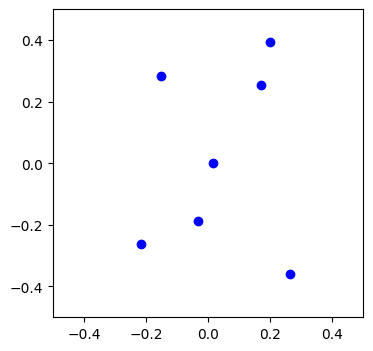

[np.float32(-15.142455), np.float32(-15.138864), np.float32(-15.093935), np.float32(-15.046708), np.float32(-15.137491), np.float32(-15.11898), np.float32(-15.048891), np.float32(-15.005363), np.float32(-15.083693), np.float32(-15.042433), np.float32(-14.976438), np.float32(-14.957365), np.float32(-15.024912), np.float32(-14.983681), np.float32(-14.94153), np.float32(-14.935652), np.float32(-15.193486), np.float32(-15.209633), np.float32(-15.142091), np.float32(-15.055462), np.float32(-15.202456), np.float32(-4.864869), np.float32(-15.04546), np.float32(-14.980126), np.float32(-15.119091), np.float32(-15.029871), np.float32(-14.852714), np.float32(-14.894048), np.float32(-15.019709), np.float32(-14.936565), np.float32(-14.847777), np.float32(-14.878504), np.float32(-15.1896715), np.float32(-15.2171545), np.float32(-15.192937), np.float32(-15.044005), np.float32(-15.18944), np.float32(-15.197252), np.float32(-15.03613), np.float32(-14.942113), np.float32(-15.088272), np.float32(-14.9023

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.45s/it]


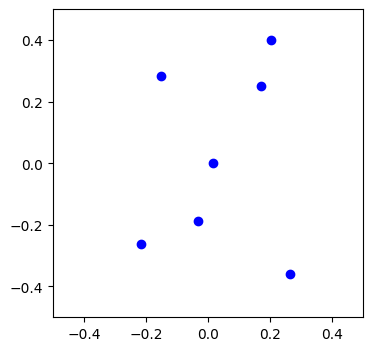

[np.float32(-15.14082), np.float32(-15.136559), np.float32(-15.089071), np.float32(-15.040278), np.float32(-15.134676), np.float32(-15.114352), np.float32(-15.041307), np.float32(-14.997092), np.float32(-15.077688), np.float32(-15.034305), np.float32(-14.966831), np.float32(-14.947892), np.float32(-15.017205), np.float32(-14.974525), np.float32(-14.931625), np.float32(-14.926018), np.float32(-15.194727), np.float32(-15.211743), np.float32(-15.139485), np.float32(-15.048802), np.float32(-15.203239), np.float32(-4.865187), np.float32(-15.036702), np.float32(-14.970594), np.float32(-15.113579), np.float32(-15.019927), np.float32(-14.840734), np.float32(-14.882985), np.float32(-15.011107), np.float32(-14.925758), np.float32(-14.836076), np.float32(-14.867521), np.float32(-15.190431), np.float32(-15.219902), np.float32(-15.195238), np.float32(-15.036839), np.float32(-15.188875), np.float32(-15.196265), np.float32(-15.027412), np.float32(-14.9317255), np.float32(-15.081002), np.float32(-14.8

100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.15s/it]


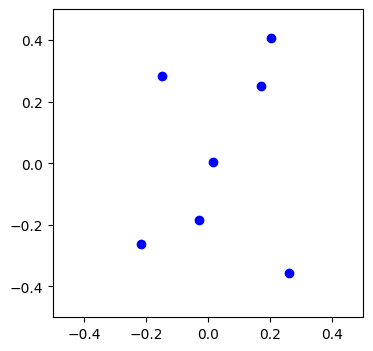

[np.float32(-15.138545), np.float32(-15.133591), np.float32(-15.083612), np.float32(-15.033366), np.float32(-15.13116), np.float32(-15.109034), np.float32(-15.033228), np.float32(-14.988409), np.float32(-15.071091), np.float32(-15.025691), np.float32(-14.956859), np.float32(-14.93807), np.float32(-15.0090475), np.float32(-14.964989), np.float32(-14.92139), np.float32(-14.916054), np.float32(-15.19542), np.float32(-15.213358), np.float32(-15.136215), np.float32(-15.04164), np.float32(-15.2033825), np.float32(-4.864569), np.float32(-15.027474), np.float32(-14.960695), np.float32(-15.107366), np.float32(-15.009558), np.float32(-14.828516), np.float32(-14.871641), np.float32(-15.002069), np.float32(-14.914642), np.float32(-14.824125), np.float32(-14.856259), np.float32(-15.190629), np.float32(-15.222233), np.float32(-15.197196), np.float32(-15.029198), np.float32(-15.187626), np.float32(-15.19456), np.float32(-15.0182905), np.float32(-14.921021), np.float32(-15.073137), np.float32(-14.8781

100%|█████████████████████████████████████████████| 7/7 [00:40<00:00,  5.72s/it]


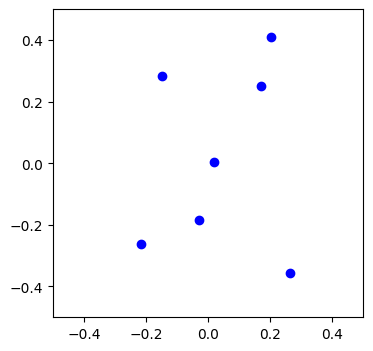

[np.float32(-15.135641), np.float32(-15.129976), np.float32(-15.07759), np.float32(-15.025997), np.float32(-15.1269655), np.float32(-15.103063), np.float32(-15.024683), np.float32(-14.979336), np.float32(-15.063936), np.float32(-15.016624), np.float32(-14.94654), np.float32(-14.927917), np.float32(-15.0004635), np.float32(-14.9550905), np.float32(-14.910837), np.float32(-14.905773), np.float32(-15.195552), np.float32(-15.214464), np.float32(-15.132299), np.float32(-15.034005), np.float32(-15.202872), np.float32(-4.863), np.float32(-15.01781), np.float32(-14.95045), np.float32(-15.100493), np.float32(-14.998795), np.float32(-14.816071), np.float32(-14.860029), np.float32(-14.99262), np.float32(-14.903233), np.float32(-14.811935), np.float32(-14.84473), np.float32(-15.190247), np.float32(-15.224134), np.float32(-15.198829), np.float32(-15.021114), np.float32(-15.185672), np.float32(-15.192128), np.float32(-15.008791), np.float32(-14.910019), np.float32(-15.064713), np.float32(-14.865675)

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.69s/it]


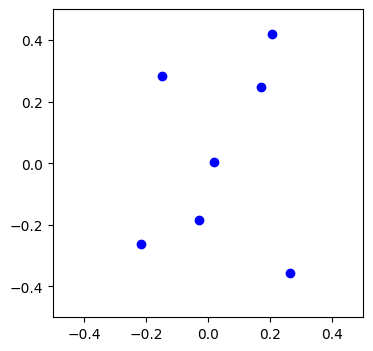

[np.float32(-15.132171), np.float32(-15.125785), np.float32(-15.071076), np.float32(-15.01823), np.float32(-15.122167), np.float32(-15.09652), np.float32(-15.015735), np.float32(-14.969921), np.float32(-15.056296), np.float32(-15.007163), np.float32(-14.935918), np.float32(-14.91747), np.float32(-14.991507), np.float32(-14.944875), np.float32(-14.900006), np.float32(-14.895213), np.float32(-15.195164), np.float32(-15.215102), np.float32(-15.127816), np.float32(-15.025962), np.float32(-15.201752), np.float32(-4.8605466), np.float32(-15.00777), np.float32(-14.939902), np.float32(-15.093048), np.float32(-14.98769), np.float32(-14.803424), np.float32(-14.84818), np.float32(-14.982813), np.float32(-14.891564), np.float32(-14.799534), np.float32(-14.832965), np.float32(-15.189337), np.float32(-15.225651), np.float32(-15.200179), np.float32(-15.012651), np.float32(-15.18308), np.float32(-15.189038), np.float32(-14.998972), np.float32(-14.898754), np.float32(-15.05581), np.float32(-14.853009),

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.33s/it]


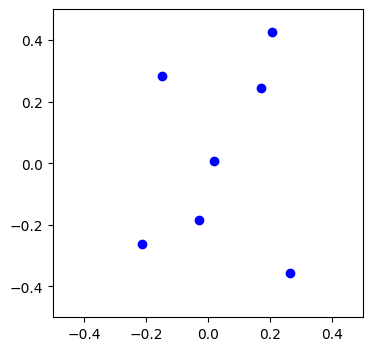

[np.float32(-15.128095), np.float32(-15.120984), np.float32(-15.064056), np.float32(-15.010052), np.float32(-15.116735), np.float32(-15.089394), np.float32(-15.006374), np.float32(-14.960154), np.float32(-15.048161), np.float32(-14.9973), np.float32(-14.924981), np.float32(-14.906717), np.float32(-14.982164), np.float32(-14.93433), np.float32(-14.888883), np.float32(-14.884359), np.float32(-15.194199), np.float32(-15.2152195), np.float32(-15.122739), np.float32(-15.017498), np.float32(-15.199959), np.float32(-4.8571362), np.float32(-14.99735), np.float32(-14.929041), np.float32(-15.085021), np.float32(-14.976242), np.float32(-14.790564), np.float32(-14.836081), np.float32(-14.972637), np.float32(-14.879626), np.float32(-14.786907), np.float32(-14.820949), np.float32(-15.187844), np.float32(-15.226742), np.float32(-15.20125), np.float32(-15.003795), np.float32(-15.179796), np.float32(-15.185248), np.float32(-14.988841), np.float32(-14.887216), np.float32(-15.046425), np.float32(-14.8401

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.37s/it]


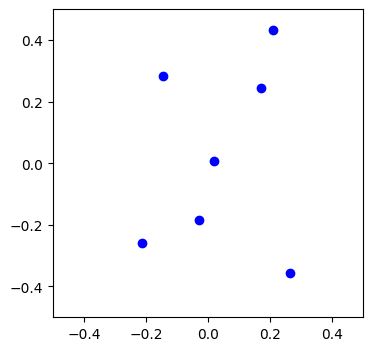

[np.float32(-15.123423), np.float32(-15.115592), np.float32(-15.056556), np.float32(-15.00148), np.float32(-15.110691), np.float32(-15.081711), np.float32(-14.996624), np.float32(-14.950048), np.float32(-15.039554), np.float32(-14.987057), np.float32(-14.913744), np.float32(-14.895671), np.float32(-14.972453), np.float32(-14.92347), np.float32(-14.877478), np.float32(-14.873221), np.float32(-15.192642), np.float32(-15.214802), np.float32(-15.117093), np.float32(-15.008637), np.float32(-15.197481), np.float32(-4.8527694), np.float32(-14.986575), np.float32(-14.917881), np.float32(-15.076446), np.float32(-14.964471), np.float32(-14.777497), np.float32(-14.823741), np.float32(-14.9621105), np.float32(-14.867429), np.float32(-14.774062), np.float32(-14.808689), np.float32(-15.185763), np.float32(-15.227403), np.float32(-15.202069), np.float32(-14.994569), np.float32(-15.175828), np.float32(-15.180773), np.float32(-14.978425), np.float32(-14.875417), np.float32(-15.03659), np.float32(-14.82

100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.28s/it]


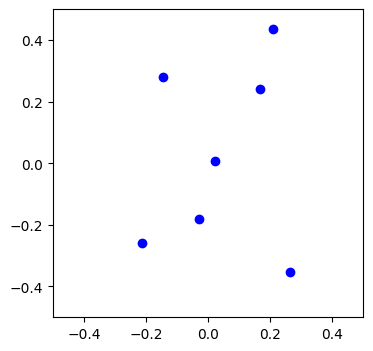

[np.float32(-15.118151), np.float32(-15.109611), np.float32(-15.048586), np.float32(-14.992525), np.float32(-15.10404), np.float32(-15.073489), np.float32(-14.986497), np.float32(-14.939613), np.float32(-15.030489), np.float32(-14.976445), np.float32(-14.902213), np.float32(-14.884336), np.float32(-14.96238), np.float32(-14.9123), np.float32(-14.865797), np.float32(-14.861804), np.float32(-15.190462), np.float32(-15.213818), np.float32(-15.110888), np.float32(-14.999392), np.float32(-15.194288), np.float32(-4.8474374), np.float32(-14.975462), np.float32(-14.906431), np.float32(-15.067345), np.float32(-14.952392), np.float32(-14.764229), np.float32(-14.811164), np.float32(-14.951243), np.float32(-14.854978), np.float32(-14.761001), np.float32(-14.79619), np.float32(-15.183073), np.float32(-15.227613), np.float32(-15.20264), np.float32(-14.984987), np.float32(-15.171168), np.float32(-15.175623), np.float32(-14.967755), np.float32(-14.863366), np.float32(-15.026324), np.float32(-14.813738

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.55s/it]


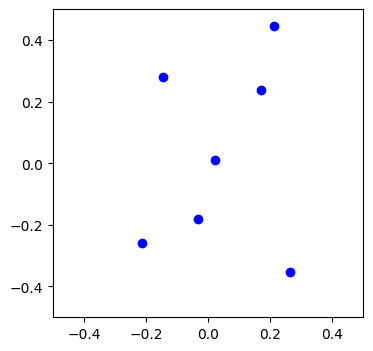

[np.float32(-15.112336), np.float32(-15.103099), np.float32(-15.040196), np.float32(-14.983224), np.float32(-15.0968485), np.float32(-15.064791), np.float32(-14.976033), np.float32(-14.928881), np.float32(-15.02102), np.float32(-14.9655075), np.float32(-14.890419), np.float32(-14.872742), np.float32(-14.951986), np.float32(-14.900854), np.float32(-14.853868), np.float32(-14.850135), np.float32(-15.187697), np.float32(-15.212297), np.float32(-15.104174), np.float32(-14.989797), np.float32(-15.190433), np.float32(-4.8412185), np.float32(-14.964047), np.float32(-14.894719), np.float32(-15.057782), np.float32(-14.94004), np.float32(-14.750778), np.float32(-14.798372), np.float32(-14.940073), np.float32(-14.8423), np.float32(-14.7477455), np.float32(-14.783475), np.float32(-15.17981), np.float32(-15.227394), np.float32(-15.202968), np.float32(-14.9750805), np.float32(-15.165872), np.float32(-15.169853), np.float32(-14.95685), np.float32(-14.851084), np.float32(-15.01568), np.float32(-14.800

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.39s/it]


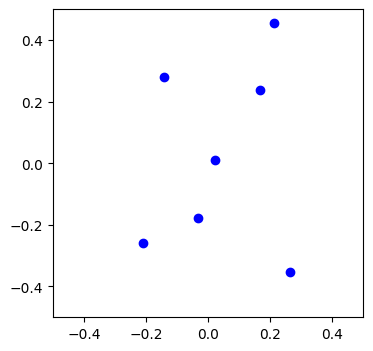

[np.float32(-15.105975), np.float32(-15.096057), np.float32(-15.031389), np.float32(-14.973576), np.float32(-15.089118), np.float32(-15.055622), np.float32(-14.965233), np.float32(-14.917848), np.float32(-15.0111475), np.float32(-14.954242), np.float32(-14.878357), np.float32(-14.860881), np.float32(-14.941267), np.float32(-14.889127), np.float32(-14.841682), np.float32(-14.838205), np.float32(-15.184323), np.float32(-15.2102165), np.float32(-15.096961), np.float32(-14.979856), np.float32(-15.18589), np.float32(-4.8341064), np.float32(-14.952335), np.float32(-14.882741), np.float32(-15.047765), np.float32(-14.927415), np.float32(-14.737138), np.float32(-14.785359), np.float32(-14.9285965), np.float32(-14.829391), np.float32(-14.734287), np.float32(-14.7705345), np.float32(-15.175954), np.float32(-15.226735), np.float32(-15.203107), np.float32(-14.964853), np.float32(-15.159927), np.float32(-15.163465), np.float32(-14.945733), np.float32(-14.838567), np.float32(-15.0046625), np.float32(

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.29s/it]


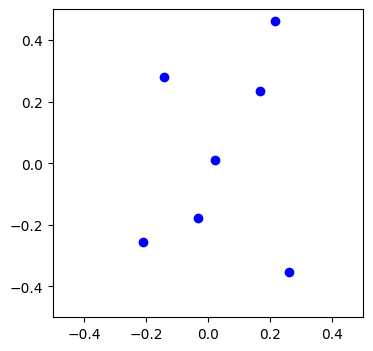

[np.float32(-15.099087), np.float32(-15.088509), np.float32(-15.022186), np.float32(-14.963594), np.float32(-15.080872), np.float32(-15.046007), np.float32(-14.954111), np.float32(-14.906526), np.float32(-15.000888), np.float32(-14.942661), np.float32(-14.866035), np.float32(-14.8487625), np.float32(-14.930231), np.float32(-14.877126), np.float32(-14.829248), np.float32(-14.826022), np.float32(-15.180342), np.float32(-15.207576), np.float32(-15.08928), np.float32(-14.969587), np.float32(-15.180663), np.float32(-4.8261294), np.float32(-14.940341), np.float32(-14.870509), np.float32(-15.037314), np.float32(-14.914527), np.float32(-14.72331), np.float32(-14.772131), np.float32(-14.916822), np.float32(-14.816253), np.float32(-14.720629), np.float32(-14.757373), np.float32(-15.171511), np.float32(-15.225641), np.float32(-15.203114), np.float32(-14.954325), np.float32(-15.153348), np.float32(-15.156476), np.float32(-14.934431), np.float32(-14.825826), np.float32(-14.993286), np.float32(-14.7

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.33s/it]


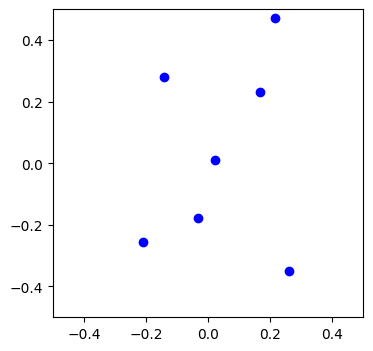

[np.float32(-15.091691), np.float32(-15.080475), np.float32(-15.012605), np.float32(-14.953292), np.float32(-15.072134), np.float32(-15.035968), np.float32(-14.942681), np.float32(-14.894922), np.float32(-14.990259), np.float32(-14.9307785), np.float32(-14.853462), np.float32(-14.836391), np.float32(-14.918889), np.float32(-14.864858), np.float32(-14.81657), np.float32(-14.81359), np.float32(-15.175756), np.float32(-15.204374), np.float32(-15.081154), np.float32(-14.959003), np.float32(-15.1747675), np.float32(-4.8173294), np.float32(-14.928078), np.float32(-14.858029), np.float32(-15.026457), np.float32(-14.901388), np.float32(-14.7093), np.float32(-14.758691), np.float32(-14.904761), np.float32(-14.802893), np.float32(-14.706774), np.float32(-14.743994), np.float32(-15.166489), np.float32(-15.224115), np.float32(-15.203025), np.float32(-14.943503), np.float32(-15.146157), np.float32(-15.148915), np.float32(-14.92296), np.float32(-14.812863), np.float32(-14.981571), np.float32(-14.758

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.50s/it]


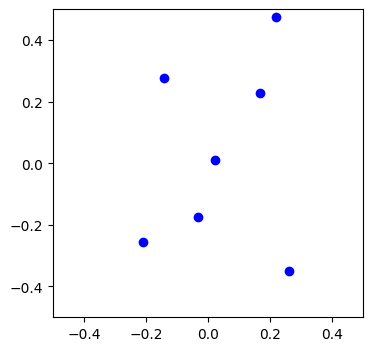

[np.float32(-15.083811), np.float32(-15.071983), np.float32(-15.0026655), np.float32(-14.942684), np.float32(-15.062932), np.float32(-15.025531), np.float32(-14.930958), np.float32(-14.883051), np.float32(-14.979279), np.float32(-14.918608), np.float32(-14.840647), np.float32(-14.823776), np.float32(-14.907252), np.float32(-14.852333), np.float32(-14.803657), np.float32(-14.800917), np.float32(-15.170581), np.float32(-15.200624), np.float32(-15.072618), np.float32(-14.948124), np.float32(-15.168224), np.float32(-4.8077583), np.float32(-14.915563), np.float32(-14.845314), np.float32(-15.015215), np.float32(-14.88801), np.float32(-14.695111), np.float32(-14.745045), np.float32(-14.892425), np.float32(-14.789317), np.float32(-14.692726), np.float32(-14.730403), np.float32(-15.1609), np.float32(-15.2221775), np.float32(-15.202936), np.float32(-14.932411), np.float32(-15.138379), np.float32(-15.1408205), np.float32(-14.9113655), np.float32(-14.799692), np.float32(-14.969535), np.float32(-14

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.42s/it]


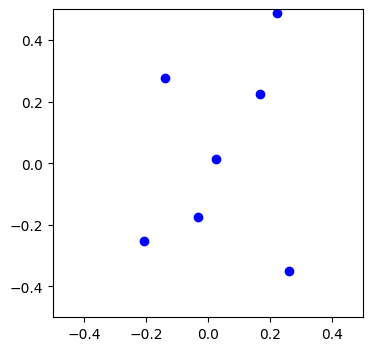

[np.float32(-15.075487), np.float32(-15.063073), np.float32(-14.992401), np.float32(-14.931797), np.float32(-15.053306), np.float32(-15.014732), np.float32(-14.918968), np.float32(-14.870933), np.float32(-14.9679785), np.float32(-14.906175), np.float32(-14.827609), np.float32(-14.810938), np.float32(-14.895347), np.float32(-14.839573), np.float32(-14.790525), np.float32(-14.788022), np.float32(-15.16485), np.float32(-15.196358), np.float32(-15.063711), np.float32(-14.936974), np.float32(-15.1610775), np.float32(-4.797492), np.float32(-14.902821), np.float32(-14.832383), np.float32(-15.003626), np.float32(-14.874416), np.float32(-14.68076), np.float32(-14.73121), np.float32(-14.879837), np.float32(-14.775545), np.float32(-14.678502), np.float32(-14.716618), np.float32(-15.154789), np.float32(-15.21986), np.float32(-15.202892), np.float32(-14.92107), np.float32(-15.130068), np.float32(-15.132248), np.float32(-14.899678), np.float32(-14.786328), np.float32(-14.95721), np.float32(-14.73014

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.51s/it]


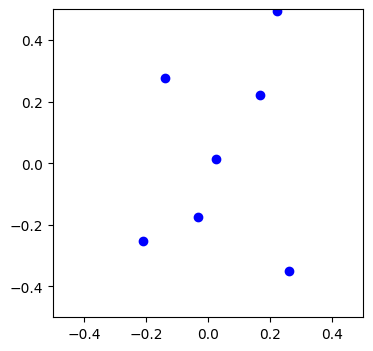

[np.float32(-15.066719), np.float32(-15.053748), np.float32(-14.981814), np.float32(-14.920629), np.float32(-15.043256), np.float32(-15.003574), np.float32(-14.906711), np.float32(-14.858565), np.float32(-14.956356), np.float32(-14.893476), np.float32(-14.814345), np.float32(-14.797871), np.float32(-14.883166), np.float32(-14.826572), np.float32(-14.777172), np.float32(-14.774899), np.float32(-15.158556), np.float32(-15.191566), np.float32(-15.054448), np.float32(-14.925555), np.float32(-15.153321), np.float32(-4.786553), np.float32(-14.889854), np.float32(-14.819234), np.float32(-14.991693), np.float32(-14.860603), np.float32(-14.666241), np.float32(-14.71718), np.float32(-14.866994), np.float32(-14.76157), np.float32(-14.664094), np.float32(-14.702631), np.float32(-15.148152), np.float32(-15.217171), np.float32(-15.202985), np.float32(-14.909483), np.float32(-15.121228), np.float32(-15.123215), np.float32(-14.887939), np.float32(-14.77277), np.float32(-14.944596), np.float32(-14.7156

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.39s/it]


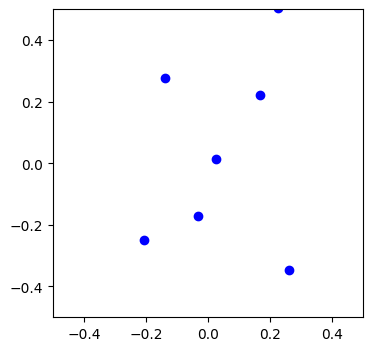

[np.float32(-15.057541), np.float32(-15.04404), np.float32(-14.970927), np.float32(-14.909196), np.float32(-15.032818), np.float32(-14.992085), np.float32(-14.894202), np.float32(-14.845961), np.float32(-14.944434), np.float32(-14.8805275), np.float32(-14.800866), np.float32(-14.784585), np.float32(-14.870728), np.float32(-14.813343), np.float32(-14.763606), np.float32(-14.761557), np.float32(-15.151732), np.float32(-15.18628), np.float32(-15.044861), np.float32(-14.913885), np.float32(-15.145004), np.float32(-4.7750087), np.float32(-14.876678), np.float32(-14.805876), np.float32(-14.979443), np.float32(-14.846584), np.float32(-14.651559), np.float32(-14.702964), np.float32(-14.8539095), np.float32(-14.747401), np.float32(-14.649509), np.float32(-14.68845), np.float32(-15.141021), np.float32(-15.21414), np.float32(-15.203309), np.float32(-14.897667), np.float32(-15.1119), np.float32(-15.113763), np.float32(-14.876173), np.float32(-14.759024), np.float32(-14.931715), np.float32(-14.7009

100%|█████████████████████████████████████████████| 7/7 [00:31<00:00,  4.57s/it]


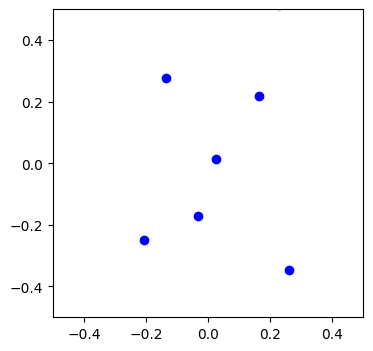

[np.float32(-15.047966), np.float32(-15.033964), np.float32(-14.959753), np.float32(-14.897509), np.float32(-15.022002), np.float32(-14.980278), np.float32(-14.881451), np.float32(-14.833127), np.float32(-14.9322195), np.float32(-14.867336), np.float32(-14.787177), np.float32(-14.771086), np.float32(-14.858035), np.float32(-14.79989), np.float32(-14.74983), np.float32(-14.747999), np.float32(-15.144392), np.float32(-15.180514), np.float32(-15.034977), np.float32(-14.901977), np.float32(-15.136137), np.float32(-4.762898), np.float32(-14.863304), np.float32(-14.792318), np.float32(-14.966886), np.float32(-14.832366), np.float32(-14.636717), np.float32(-14.688563), np.float32(-14.840589), np.float32(-14.733041), np.float32(-14.634749), np.float32(-14.674077), np.float32(-15.133415), np.float32(-15.2108), np.float32(-15.203991), np.float32(-14.885637), np.float32(-15.102105), np.float32(-15.103921), np.float32(-14.864441), np.float32(-14.745099), np.float32(-14.918575), np.float32(-14.6861

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.78s/it]


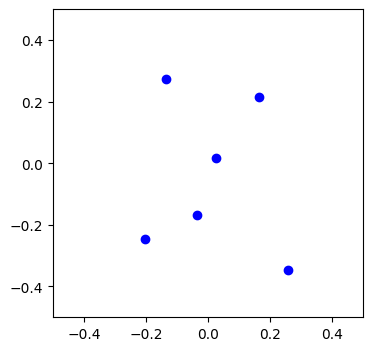

[np.float32(-15.038012), np.float32(-15.02354), np.float32(-14.948305), np.float32(-14.885577), np.float32(-15.010828), np.float32(-14.968166), np.float32(-14.868466), np.float32(-14.820071), np.float32(-14.919724), np.float32(-14.8539095), np.float32(-14.773283), np.float32(-14.757378), np.float32(-14.845096), np.float32(-14.786217), np.float32(-14.735849), np.float32(-14.734231), np.float32(-15.136555), np.float32(-15.174286), np.float32(-15.024818), np.float32(-14.889842), np.float32(-15.126748), np.float32(-4.750268), np.float32(-14.849743), np.float32(-14.778567), np.float32(-14.954037), np.float32(-14.817953), np.float32(-14.621717), np.float32(-14.673983), np.float32(-14.827038), np.float32(-14.718493), np.float32(-14.619815), np.float32(-14.659515), np.float32(-15.125356), np.float32(-15.207175), np.float32(-15.205124), np.float32(-14.873408), np.float32(-15.09187), np.float32(-15.093723), np.float32(-14.852801), np.float32(-14.731003), np.float32(-14.905189), np.float32(-14.67

100%|█████████████████████████████████████████████| 7/7 [00:32<00:00,  4.63s/it]


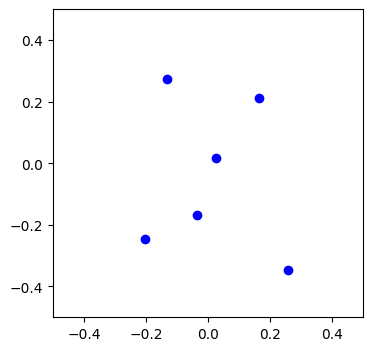

[np.float32(-15.027702), np.float32(-15.01279), np.float32(-14.936602), np.float32(-14.873414), np.float32(-14.999317), np.float32(-14.95577), np.float32(-14.855261), np.float32(-14.806803), np.float32(-14.906961), np.float32(-14.840258), np.float32(-14.759191), np.float32(-14.743467), np.float32(-14.831918), np.float32(-14.772331), np.float32(-14.721668), np.float32(-14.720258), np.float32(-15.128251), np.float32(-15.167633), np.float32(-15.014421), np.float32(-14.877497), np.float32(-15.116871), np.float32(-4.737171), np.float32(-14.836008), np.float32(-14.764631), np.float32(-14.940912), np.float32(-14.803355), np.float32(-14.6065645), np.float32(-14.659226), np.float32(-14.813266), np.float32(-14.703763), np.float32(-14.604711), np.float32(-14.644769), np.float32(-15.116873), np.float32(-15.203323), np.float32(-15.206886), np.float32(-14.860995), np.float32(-15.081225), np.float32(-15.083212), np.float32(-14.841335), np.float32(-14.7167425), np.float32(-14.891566), np.float32(-14.6

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.68s/it]


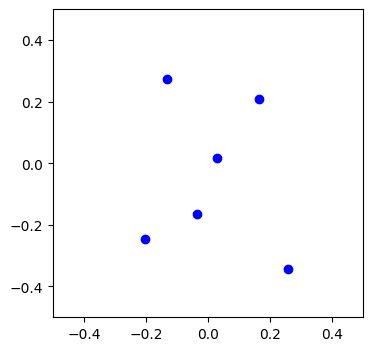

[np.float32(-15.01706), np.float32(-15.001736), np.float32(-14.924656), np.float32(-14.861027), np.float32(-14.98749), np.float32(-14.943105), np.float32(-14.841843), np.float32(-14.793327), np.float32(-14.893944), np.float32(-14.82639), np.float32(-14.744905), np.float32(-14.729359), np.float32(-14.81851), np.float32(-14.75824), np.float32(-14.707292), np.float32(-14.706082), np.float32(-15.119512), np.float32(-15.160588), np.float32(-15.00381), np.float32(-14.864949), np.float32(-15.10654), np.float32(-4.7236567), np.float32(-14.822112), np.float32(-14.750515), np.float32(-14.927528), np.float32(-14.78858), np.float32(-14.59126), np.float32(-14.644296), np.float32(-14.79928), np.float32(-14.688854), np.float32(-14.589437), np.float32(-14.629837), np.float32(-15.107998), np.float32(-15.199297), np.float32(-15.209401), np.float32(-14.848408), np.float32(-15.070201), np.float32(-15.07243), np.float32(-14.83016), np.float32(-14.70232), np.float32(-14.877721), np.float32(-14.640748), np.f

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.61s/it]


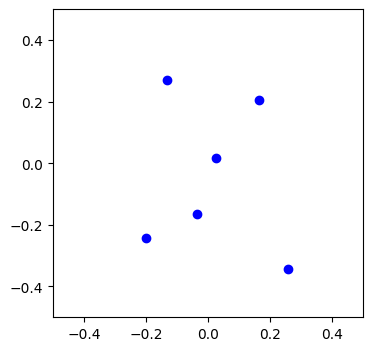

[np.float32(-15.00612), np.float32(-14.990415), np.float32(-14.9125), np.float32(-14.848444), np.float32(-14.975375), np.float32(-14.930199), np.float32(-14.828235), np.float32(-14.779665), np.float32(-14.8806925), np.float32(-14.8123255), np.float32(-14.730444), np.float32(-14.715068), np.float32(-14.804892), np.float32(-14.7439575), np.float32(-14.692734), np.float32(-14.69172), np.float32(-15.110384), np.float32(-15.153215), np.float32(-14.993045), np.float32(-14.852233), np.float32(-15.0957985), np.float32(-4.7097816), np.float32(-14.808078), np.float32(-14.7362385), np.float32(-14.913907), np.float32(-14.773642), np.float32(-14.575816), np.float32(-14.629205), np.float32(-14.785097), np.float32(-14.6737795), np.float32(-14.574005), np.float32(-14.614735), np.float32(-15.098783), np.float32(-15.195196), np.float32(-15.212828), np.float32(-14.835684), np.float32(-15.058839), np.float32(-15.06143), np.float32(-14.819381), np.float32(-14.687757), np.float32(-14.863673), np.float32(-14

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.51s/it]


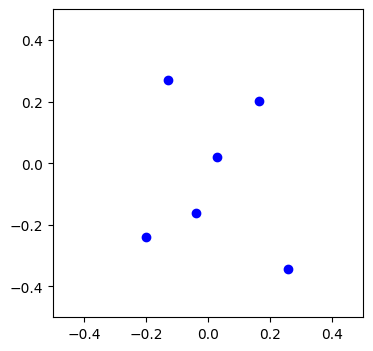

[np.float32(-14.994901), np.float32(-14.978847), np.float32(-14.900152), np.float32(-14.835676), np.float32(-14.962989), np.float32(-14.917065), np.float32(-14.8144455), np.float32(-14.765823), np.float32(-14.867216), np.float32(-14.798068), np.float32(-14.715809), np.float32(-14.700598), np.float32(-14.791065), np.float32(-14.729487), np.float32(-14.677996), np.float32(-14.677171), np.float32(-15.100899), np.float32(-15.145564), np.float32(-14.982172), np.float32(-14.839363), np.float32(-15.084674), np.float32(-4.6955914), np.float32(-14.793925), np.float32(-14.721808), np.float32(-14.90006), np.float32(-14.758546), np.float32(-14.560234), np.float32(-14.613954), np.float32(-14.7707205), np.float32(-14.65854), np.float32(-14.558414), np.float32(-14.59946), np.float32(-15.089258), np.float32(-15.191118), np.float32(-15.217328), np.float32(-14.822842), np.float32(-15.047166), np.float32(-15.050274), np.float32(-14.809272), np.float32(-14.6730585), np.float32(-14.849431), np.float32(-14.

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.67s/it]


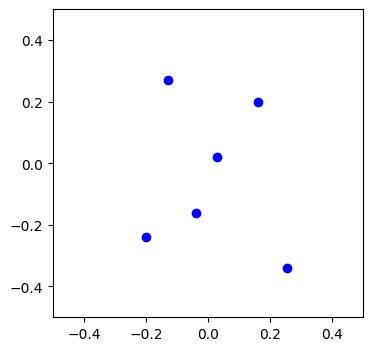

[np.float32(-14.983415), np.float32(-14.967044), np.float32(-14.887619), np.float32(-14.822729), np.float32(-14.950342), np.float32(-14.903712), np.float32(-14.800483), np.float32(-14.751806), np.float32(-14.853522), np.float32(-14.783626), np.float32(-14.701006), np.float32(-14.685953), np.float32(-14.777038), np.float32(-14.714834), np.float32(-14.663082), np.float32(-14.662439), np.float32(-15.091073), np.float32(-15.137657), np.float32(-14.971211), np.float32(-14.826347), np.float32(-15.073185), np.float32(-4.681113), np.float32(-14.779662), np.float32(-14.70723), np.float32(-14.885995), np.float32(-14.743299), np.float32(-14.5445175), np.float32(-14.598546), np.float32(-14.756157), np.float32(-14.64314), np.float32(-14.542668), np.float32(-14.584015), np.float32(-15.079448), np.float32(-15.187122), np.float32(-15.222917), np.float32(-14.809894), np.float32(-15.035202), np.float32(-15.038995), np.float32(-14.800013), np.float32(-14.65823), np.float32(-14.835004), np.float32(-14.594

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.43s/it]


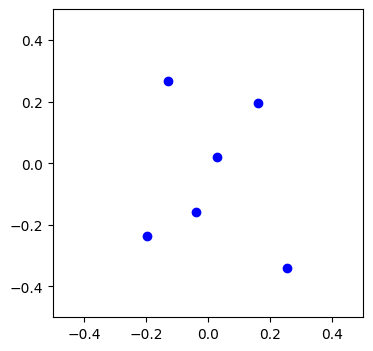

[np.float32(-14.971695), np.float32(-14.955043), np.float32(-14.874933), np.float32(-14.80963), np.float32(-14.937463), np.float32(-14.890168), np.float32(-14.786367), np.float32(-14.737634), np.float32(-14.839631), np.float32(-14.769013), np.float32(-14.686049), np.float32(-14.671147), np.float32(-14.762825), np.float32(-14.700012), np.float32(-14.6480055), np.float32(-14.647539), np.float32(-15.0809555), np.float32(-15.129568), np.float32(-14.960235), np.float32(-14.813218), np.float32(-15.061375), np.float32(-4.6663995), np.float32(-14.765316), np.float32(-14.69252), np.float32(-14.871734), np.float32(-14.727914), np.float32(-14.528677), np.float32(-14.582993), np.float32(-14.74142), np.float32(-14.62759), np.float32(-14.526775), np.float32(-14.568412), np.float32(-15.069402), np.float32(-15.183345), np.float32(-15.229649), np.float32(-14.796876), np.float32(-15.022986), np.float32(-15.027661), np.float32(-14.791851), np.float32(-14.643289), np.float32(-14.82041), np.float32(-14.578

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.48s/it]


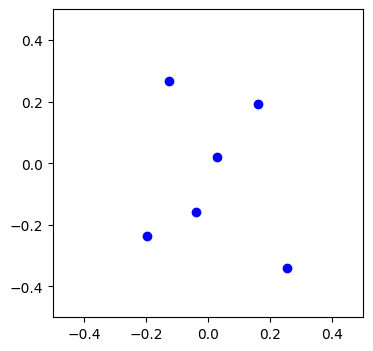

[np.float32(-14.959756), np.float32(-14.942858), np.float32(-14.862105), np.float32(-14.796385), np.float32(-14.92436), np.float32(-14.876439), np.float32(-14.772102), np.float32(-14.723307), np.float32(-14.825546), np.float32(-14.754234), np.float32(-14.6709385), np.float32(-14.65618), np.float32(-14.748427), np.float32(-14.68502), np.float32(-14.632764), np.float32(-14.632468), np.float32(-15.07057), np.float32(-15.121342), np.float32(-14.949284), np.float32(-14.799986), np.float32(-15.049261), np.float32(-4.6514764), np.float32(-14.750896), np.float32(-14.677682), np.float32(-14.857281), np.float32(-14.712391), np.float32(-14.512711), np.float32(-14.567292), np.float32(-14.72651), np.float32(-14.611888), np.float32(-14.510733), np.float32(-14.552647), np.float32(-15.059144), np.float32(-15.179895), np.float32(-15.237504), np.float32(-14.783806), np.float32(-15.010534), np.float32(-15.016316), np.float32(-14.7851095), np.float32(-14.628237), np.float32(-14.80565), np.float32(-14.5626

100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.37s/it]


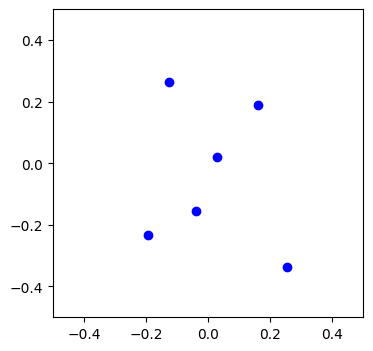

[np.float32(-14.9476185), np.float32(-14.930511), np.float32(-14.849157), np.float32(-14.783011), np.float32(-14.911054), np.float32(-14.862543), np.float32(-14.757705), np.float32(-14.70884), np.float32(-14.811283), np.float32(-14.739301), np.float32(-14.655685), np.float32(-14.641064), np.float32(-14.733859), np.float32(-14.66987), np.float32(-14.617369), np.float32(-14.617237), np.float32(-15.059946), np.float32(-15.113029), np.float32(-14.938412), np.float32(-14.786674), np.float32(-15.036873), np.float32(-4.6363816), np.float32(-14.736426), np.float32(-14.66273), np.float32(-14.842651), np.float32(-14.696742), np.float32(-14.496627), np.float32(-14.551455), np.float32(-14.711439), np.float32(-14.596044), np.float32(-14.494549), np.float32(-14.53673), np.float32(-15.048711), np.float32(-15.176886), np.float32(-15.246414), np.float32(-14.770712), np.float32(-14.997876), np.float32(-15.005027), np.float32(-14.780089), np.float32(-14.613091), np.float32(-14.79074), np.float32(-14.5467

100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.19s/it]


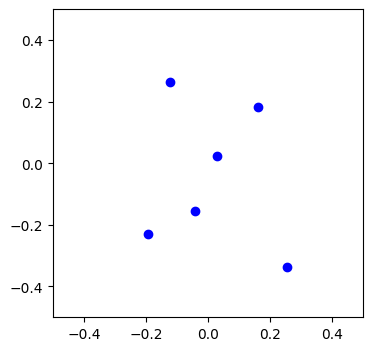

[np.float32(-14.935329), np.float32(-14.918057), np.float32(-14.836138), np.float32(-14.769547), np.float32(-14.897577), np.float32(-14.848515), np.float32(-14.743203), np.float32(-14.69426), np.float32(-14.7968645), np.float32(-14.724234), np.float32(-14.640307), np.float32(-14.625814), np.float32(-14.719138), np.float32(-14.654577), np.float32(-14.601832), np.float32(-14.601859), np.float32(-15.049155), np.float32(-15.104763), np.float32(-14.92776), np.float32(-14.773334), np.float32(-15.0242605), np.float32(-4.6211886), np.float32(-14.721956), np.float32(-14.64769), np.float32(-14.827871), np.float32(-14.680987), np.float32(-14.48044), np.float32(-14.535492), np.float32(-14.696225), np.float32(-14.58007), np.float32(-14.478231), np.float32(-14.520669), np.float32(-15.038188), np.float32(-15.174589), np.float32(-15.256369), np.float32(-14.757664), np.float32(-14.985066), np.float32(-14.993942), np.float32(-14.777346), np.float32(-14.5978775), np.float32(-14.775705), np.float32(-14.53

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.57s/it]


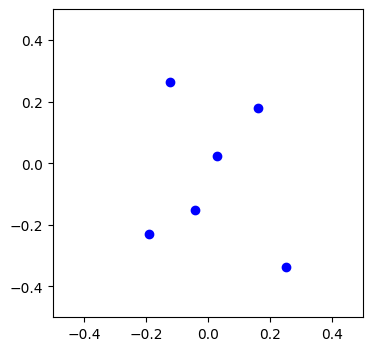

[np.float32(-14.922917), np.float32(-14.905533), np.float32(-14.823085), np.float32(-14.75602), np.float32(-14.883946), np.float32(-14.83437), np.float32(-14.728615), np.float32(-14.679576), np.float32(-14.782299), np.float32(-14.709038), np.float32(-14.624808), np.float32(-14.6104355), np.float32(-14.704268), np.float32(-14.639143), np.float32(-14.586156), np.float32(-14.586336), np.float32(-15.038246), np.float32(-15.096674), np.float32(-14.91749), np.float32(-14.760013), np.float32(-15.011449), np.float32(-4.605944), np.float32(-14.707527), np.float32(-14.632576), np.float32(-14.812948), np.float32(-14.665131), np.float32(-14.464151), np.float32(-14.519404), np.float32(-14.68087), np.float32(-14.563964), np.float32(-14.461779), np.float32(-14.504463), np.float32(-15.027641), np.float32(-15.173292), np.float32(-15.267324), np.float32(-14.744733), np.float32(-14.972138), np.float32(-14.983202), np.float32(-14.777308), np.float32(-14.582613), np.float32(-14.760553), np.float32(-14.5146

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.61s/it]


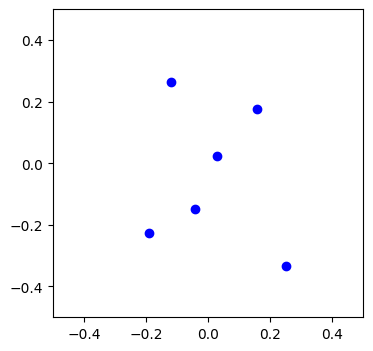

[np.float32(-14.910419), np.float32(-14.892985), np.float32(-14.810042), np.float32(-14.742457), np.float32(-14.870187), np.float32(-14.820135), np.float32(-14.713962), np.float32(-14.664806), np.float32(-14.7676), np.float32(-14.693725), np.float32(-14.609197), np.float32(-14.5949335), np.float32(-14.689258), np.float32(-14.623572), np.float32(-14.570342), np.float32(-14.570669), np.float32(-15.027283), np.float32(-15.088923), np.float32(-14.907796), np.float32(-14.746762), np.float32(-14.998479), np.float32(-4.590721), np.float32(-14.693197), np.float32(-14.617408), np.float32(-14.797896), np.float32(-14.64918), np.float32(-14.447763), np.float32(-14.503195), np.float32(-14.66538), np.float32(-14.547728), np.float32(-14.4451885), np.float32(-14.488111), np.float32(-15.017151), np.float32(-15.173284), np.float32(-15.279203), np.float32(-14.731993), np.float32(-14.959134), np.float32(-14.973016), np.float32(-14.780208), np.float32(-14.567318), np.float32(-14.7452965), np.float32(-14.49

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.66s/it]


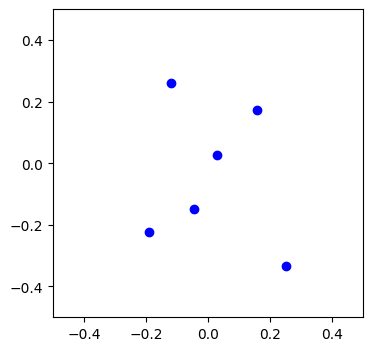

[np.float32(-14.897874), np.float32(-14.880459), np.float32(-14.797053), np.float32(-14.728893), np.float32(-14.856327), np.float32(-14.80584), np.float32(-14.699268), np.float32(-14.649972), np.float32(-14.7527895), np.float32(-14.678314), np.float32(-14.59349), np.float32(-14.579325), np.float32(-14.674125), np.float32(-14.607883), np.float32(-14.554407), np.float32(-14.554874), np.float32(-15.016323), np.float32(-15.081644), np.float32(-14.898837), np.float32(-14.733629), np.float32(-14.985389), np.float32(-4.575577), np.float32(-14.6790085), np.float32(-14.602207), np.float32(-14.782738), np.float32(-14.633157), np.float32(-14.4312935), np.float32(-14.486877), np.float32(-14.649772), np.float32(-14.531376), np.float32(-14.428474), np.float32(-14.471624), np.float32(-15.006785), np.float32(-15.174709), np.float32(-15.291893), np.float32(-14.719514), np.float32(-14.9460945), np.float32(-14.963537), np.float32(-14.78571), np.float32(-14.552014), np.float32(-14.729957), np.float32(-14.

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.61s/it]


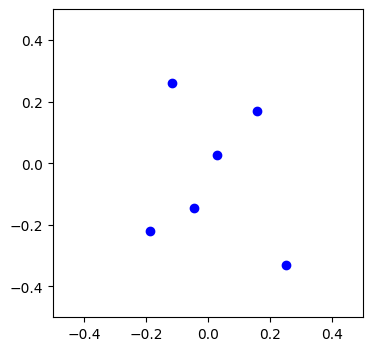

[np.float32(-14.885368), np.float32(-14.868068), np.float32(-14.784231), np.float32(-14.71541), np.float32(-14.842424), np.float32(-14.791546), np.float32(-14.684594), np.float32(-14.635119), np.float32(-14.737903), np.float32(-14.662838), np.float32(-14.577714), np.float32(-14.563635), np.float32(-14.658895), np.float32(-14.592095), np.float32(-14.538366), np.float32(-14.538968), np.float32(-15.005508), np.float32(-15.075183), np.float32(-14.891057), np.float32(-14.720752), np.float32(-14.972259), np.float32(-4.5606756), np.float32(-14.665104), np.float32(-14.587029), np.float32(-14.767508), np.float32(-14.617087), np.float32(-14.414759), np.float32(-14.4704685), np.float32(-14.634068), np.float32(-14.514922), np.float32(-14.411642), np.float32(-14.455012), np.float32(-14.996735), np.float32(-15.177903), np.float32(-15.305331), np.float32(-14.707498), np.float32(-14.933121), np.float32(-14.955214), np.float32(-14.793696), np.float32(-14.536765), np.float32(-14.71457), np.float32(-14.4

100%|█████████████████████████████████████████████| 7/7 [00:40<00:00,  5.80s/it]


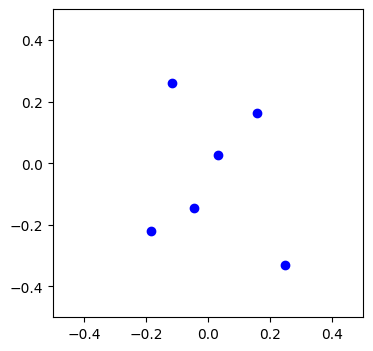

[np.float32(-14.873003), np.float32(-14.855948), np.float32(-14.771712), np.float32(-14.702099), np.float32(-14.828536), np.float32(-14.777318), np.float32(-14.669999), np.float32(-14.620292), np.float32(-14.722971), np.float32(-14.647321), np.float32(-14.56189), np.float32(-14.547879), np.float32(-14.643587), np.float32(-14.57622), np.float32(-14.522227), np.float32(-14.522957), np.float32(-14.995013), np.float32(-15.069989), np.float32(-14.885041), np.float32(-14.708301), np.float32(-14.959175), np.float32(-4.5462275), np.float32(-14.651654), np.float32(-14.571928), np.float32(-14.75224), np.float32(-14.600999), np.float32(-14.39817), np.float32(-14.453975), np.float32(-14.618283), np.float32(-14.498371), np.float32(-14.3946905), np.float32(-14.438273), np.float32(-14.987247), np.float32(-15.183104), np.float32(-15.319459), np.float32(-14.696221), np.float32(-14.920335), np.float32(-14.948627), np.float32(-14.803821), np.float32(-14.521636), np.float32(-14.699173), np.float32(-14.450

100%|█████████████████████████████████████████████| 7/7 [00:40<00:00,  5.81s/it]


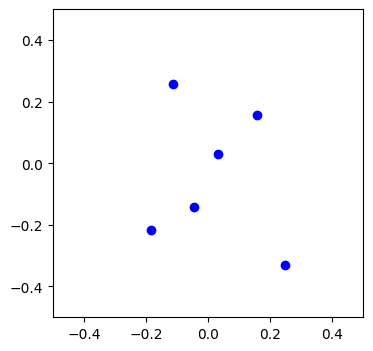

[np.float32(-14.860832), np.float32(-14.844175), np.float32(-14.759572), np.float32(-14.689011), np.float32(-14.814696), np.float32(-14.763196), np.float32(-14.65552), np.float32(-14.605518), np.float32(-14.708019), np.float32(-14.631786), np.float32(-14.546037), np.float32(-14.532078), np.float32(-14.628222), np.float32(-14.560276), np.float32(-14.506008), np.float32(-14.506859), np.float32(-14.98493), np.float32(-15.066267), np.float32(-14.881027), np.float32(-14.696367), np.float32(-14.946186), np.float32(-4.532352), np.float32(-14.638758), np.float32(-14.556935), np.float32(-14.73696), np.float32(-14.584913), np.float32(-14.381548), np.float32(-14.437412), np.float32(-14.602438), np.float32(-14.481739), np.float32(-14.377635), np.float32(-14.421423), np.float32(-14.978453), np.float32(-15.190116), np.float32(-15.334194), np.float32(-14.685826), np.float32(-14.907801), np.float32(-14.944038), np.float32(-14.815592), np.float32(-14.506659), np.float32(-14.683792), np.float32(-14.4339

100%|█████████████████████████████████████████████| 7/7 [00:39<00:00,  5.62s/it]


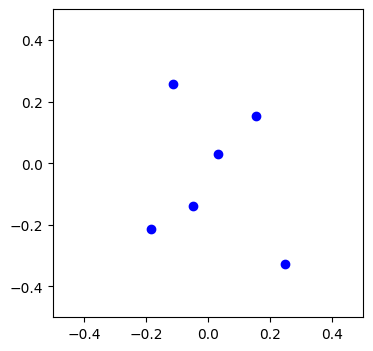

[np.float32(-14.848921), np.float32(-14.832839), np.float32(-14.747897), np.float32(-14.676195), np.float32(-14.800941), np.float32(-14.749219), np.float32(-14.641191), np.float32(-14.59082), np.float32(-14.693067), np.float32(-14.616249), np.float32(-14.530166), np.float32(-14.516239), np.float32(-14.612813), np.float32(-14.544272), np.float32(-14.489715), np.float32(-14.490678), np.float32(-14.975381), np.float32(-15.064252), np.float32(-14.879245), np.float32(-14.685058), np.float32(-14.933349), np.float32(-4.519214), np.float32(-14.62654), np.float32(-14.542077), np.float32(-14.721688), np.float32(-14.568845), np.float32(-14.364899), np.float32(-14.420787), np.float32(-14.586542), np.float32(-14.465032), np.float32(-14.360478), np.float32(-14.404465), np.float32(-14.970526), np.float32(-15.198765), np.float32(-15.349469), np.float32(-14.6764965), np.float32(-14.895599), np.float32(-14.941733), np.float32(-14.828686), np.float32(-14.491869), np.float32(-14.668449), np.float32(-14.41

100%|█████████████████████████████████████████████| 7/7 [00:44<00:00,  6.31s/it]


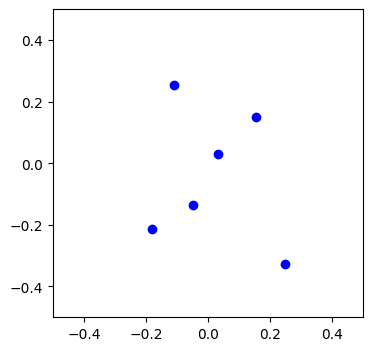

[np.float32(-14.83762), np.float32(-14.822427), np.float32(-14.737177), np.float32(-14.663982), np.float32(-14.787477), np.float32(-14.735625), np.float32(-14.627232), np.float32(-14.576359), np.float32(-14.678228), np.float32(-14.600809), np.float32(-14.514357), np.float32(-14.50043), np.float32(-14.597431), np.float32(-14.528261), np.float32(-14.473385), np.float32(-14.474451), np.float32(-14.966953), np.float32(-15.06482), np.float32(-14.880603), np.float32(-14.674978), np.float32(-14.920958), np.float32(-4.5076065), np.float32(-14.615624), np.float32(-14.5275545), np.float32(-14.706542), np.float32(-14.552892), np.float32(-14.348276), np.float32(-14.404135), np.float32(-14.570657), np.float32(-14.448279), np.float32(-14.343229), np.float32(-14.387407), np.float32(-14.964235), np.float32(-15.209086), np.float32(-15.365244), np.float32(-14.669104), np.float32(-14.884137), np.float32(-14.942643), np.float32(-14.842892), np.float32(-14.477498), np.float32(-14.65327), np.float32(-14.402

100%|█████████████████████████████████████████████| 7/7 [00:42<00:00,  6.09s/it]


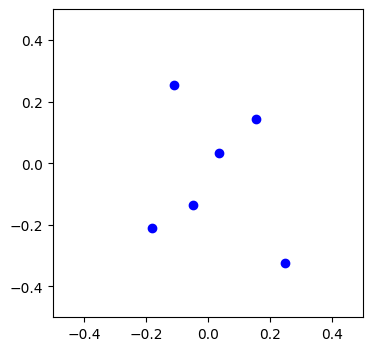

[np.float32(-14.827073), np.float32(-14.81314), np.float32(-14.727609), np.float32(-14.652496), np.float32(-14.774382), np.float32(-14.722508), np.float32(-14.613725), np.float32(-14.562188), np.float32(-14.663545), np.float32(-14.585502), np.float32(-14.498637), np.float32(-14.484674), np.float32(-14.582104), np.float32(-14.512263), np.float32(-14.457036), np.float32(-14.458195), np.float32(-14.959884), np.float32(-15.067905), np.float32(-14.884816), np.float32(-14.666366), np.float32(-14.909137), np.float32(-4.497886), np.float32(-14.606272), np.float32(-14.513437), np.float32(-14.691565), np.float32(-14.537087), np.float32(-14.3317), np.float32(-14.387473), np.float32(-14.554803), np.float32(-14.431497), np.float32(-14.325899), np.float32(-14.370263), np.float32(-14.959832), np.float32(-15.220784), np.float32(-15.381475), np.float32(-14.663935), np.float32(-14.873579), np.float32(-14.946543), np.float32(-14.858003), np.float32(-14.463632), np.float32(-14.638296), np.float32(-14.3864

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.50s/it]


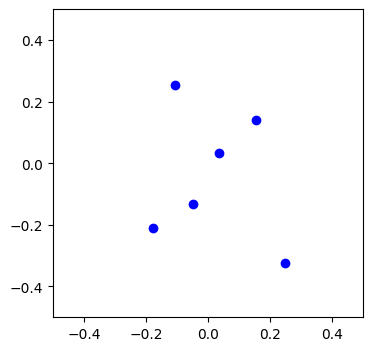

[np.float32(-14.817624), np.float32(-14.805439), np.float32(-14.719657), np.float32(-14.642062), np.float32(-14.761862), np.float32(-14.7101145), np.float32(-14.600901), np.float32(-14.548472), np.float32(-14.649135), np.float32(-14.570432), np.float32(-14.483093), np.float32(-14.469047), np.float32(-14.566909), np.float32(-14.496341), np.float32(-14.440717), np.float32(-14.441956), np.float32(-14.954677), np.float32(-15.073516), np.float32(-14.891695), np.float32(-14.659753), np.float32(-14.89819), np.float32(-4.4908237), np.float32(-14.599083), np.float32(-14.499933), np.float32(-14.676881), np.float32(-14.521541), np.float32(-14.315238), np.float32(-14.37085), np.float32(-14.539051), np.float32(-14.414726), np.float32(-14.308514), np.float32(-14.353057), np.float32(-14.957837), np.float32(-15.233671), np.float32(-15.398123), np.float32(-14.661534), np.float32(-14.864362), np.float32(-14.953291), np.float32(-14.873861), np.float32(-14.450514), np.float32(-14.62367), np.float32(-14.37

100%|█████████████████████████████████████████████| 7/7 [00:38<00:00,  5.53s/it]


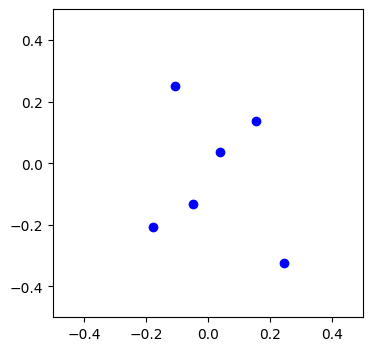

[np.float32(-14.8096485), np.float32(-14.799796), np.float32(-14.7138), np.float32(-14.6330385), np.float32(-14.750138), np.float32(-14.698715), np.float32(-14.589013), np.float32(-14.535381), np.float32(-14.63511), np.float32(-14.5556965), np.float32(-14.467801), np.float32(-14.453608), np.float32(-14.551912), np.float32(-14.480538), np.float32(-14.42446), np.float32(-14.425764), np.float32(-14.951789), np.float32(-15.081433), np.float32(-14.900875), np.float32(-14.655645), np.float32(-14.888452), np.float32(-4.487078), np.float32(-14.594624), np.float32(-14.487268), np.float32(-14.662611), np.float32(-14.506352), np.float32(-14.2989435), np.float32(-14.354298), np.float32(-14.523457), np.float32(-14.397994), np.float32(-14.291083), np.float32(-14.335799), np.float32(-14.958566), np.float32(-15.247575), np.float32(-15.415152), np.float32(-14.662213), np.float32(-14.856943), np.float32(-14.962493), np.float32(-14.890348), np.float32(-14.438413), np.float32(-14.609528), np.float32(-14.3

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.74s/it]


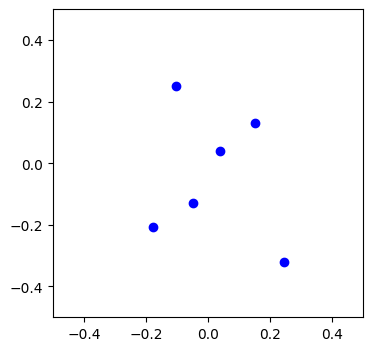

[np.float32(-14.80415), np.float32(-14.797296), np.float32(-14.711114), np.float32(-14.6263685), np.float32(-14.739901), np.float32(-14.68911), np.float32(-14.578788), np.float32(-14.523429), np.float32(-14.621844), np.float32(-14.541617), np.float32(-14.453008), np.float32(-14.4385605), np.float32(-14.537337), np.float32(-14.465017), np.float32(-14.408382), np.float32(-14.409728), np.float32(-14.952164), np.float32(-15.091525), np.float32(-14.912087), np.float32(-14.6550455), np.float32(-14.880882), np.float32(-4.487785), np.float32(-14.593924), np.float32(-14.476092), np.float32(-14.649153), np.float32(-14.491846), np.float32(-14.282984), np.float32(-14.337931), np.float32(-14.508206), np.float32(-14.381396), np.float32(-14.273645), np.float32(-14.31853), np.float32(-14.96256), np.float32(-15.262359), np.float32(-15.432519), np.float32(-14.666458), np.float32(-14.852418), np.float32(-14.973834), np.float32(-14.907339), np.float32(-14.428073), np.float32(-14.5962925), np.float32(-14.3

100%|█████████████████████████████████████████████| 7/7 [00:34<00:00,  4.88s/it]


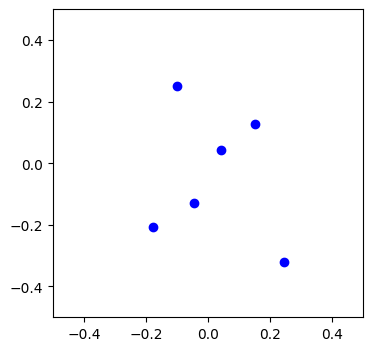

[np.float32(-14.801855), np.float32(-14.798398), np.float32(-14.71206), np.float32(-14.6227865), np.float32(-14.731869), np.float32(-14.682097), np.float32(-14.570964), np.float32(-14.513163), np.float32(-14.609757), np.float32(-14.52856), np.float32(-14.438987), np.float32(-14.42412), np.float32(-14.523429), np.float32(-14.449951), np.float32(-14.392605), np.float32(-14.393955), np.float32(-14.955954), np.float32(-15.103396), np.float32(-14.924916), np.float32(-14.658139), np.float32(-14.87634), np.float32(-4.492833), np.float32(-14.597185), np.float32(-14.467082), np.float32(-14.636961), np.float32(-14.478403), np.float32(-14.267553), np.float32(-14.321865), np.float32(-14.493509), np.float32(-14.365036), np.float32(-14.256242), np.float32(-14.301286), np.float32(-14.969565), np.float32(-15.277894), np.float32(-15.450198), np.float32(-14.673892), np.float32(-14.851484), np.float32(-14.986855), np.float32(-14.924757), np.float32(-14.420245), np.float32(-14.5844555), np.float32(-14.330

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.85s/it]


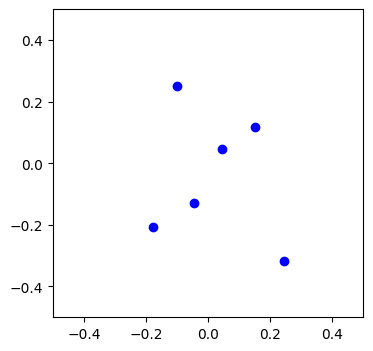

[np.float32(-14.80329), np.float32(-14.803155), np.float32(-14.716708), np.float32(-14.622952), np.float32(-14.726976), np.float32(-14.678612), np.float32(-14.566469), np.float32(-14.505405), np.float32(-14.599507), np.float32(-14.517105), np.float32(-14.426188), np.float32(-14.410652), np.float32(-14.510585), np.float32(-14.435624), np.float32(-14.377329), np.float32(-14.378633), np.float32(-14.962934), np.float32(-15.11671), np.float32(-14.939031), np.float32(-14.664719), np.float32(-14.875617), np.float32(-4.5015297), np.float32(-14.604093), np.float32(-14.461163), np.float32(-14.62674), np.float32(-14.46661), np.float32(-14.252962), np.float32(-14.306302), np.float32(-14.479701), np.float32(-14.349077), np.float32(-14.238939), np.float32(-14.284137), np.float32(-14.979142), np.float32(-15.294068), np.float32(-15.4681635), np.float32(-14.683981), np.float32(-14.854459), np.float32(-15.001184), np.float32(-14.942542), np.float32(-14.415853), np.float32(-14.574753), np.float32(-14.319

100%|█████████████████████████████████████████████| 7/7 [00:34<00:00,  4.95s/it]


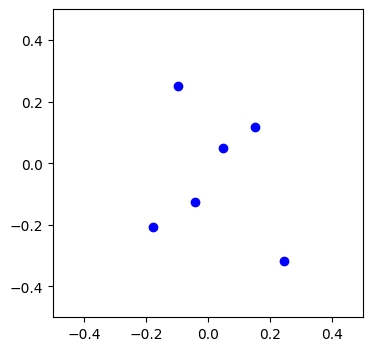

[np.float32(-14.808421), np.float32(-14.8111315), np.float32(-14.724629), np.float32(-14.627), np.float32(-14.726043), np.float32(-14.679299), np.float32(-14.566061), np.float32(-14.501103), np.float32(-14.592023), np.float32(-14.508118), np.float32(-14.415309), np.float32(-14.398719), np.float32(-14.49943), np.float32(-14.422494), np.float32(-14.362877), np.float32(-14.364046), np.float32(-14.9725895), np.float32(-15.131183), np.float32(-14.95417), np.float32(-14.674212), np.float32(-14.8789835), np.float32(-4.512989), np.float32(-14.613991), np.float32(-14.459208), np.float32(-14.619482), np.float32(-14.457369), np.float32(-14.23972), np.float32(-14.291551), np.float32(-14.467326), np.float32(-14.333794), np.float32(-14.221844), np.float32(-14.26718), np.float32(-14.990787), np.float32(-15.310791), np.float32(-15.486392), np.float32(-14.696151), np.float32(-14.86108), np.float32(-15.016539), np.float32(-14.960644), np.float32(-14.41561), np.float32(-14.568193), np.float32(-14.312254)

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.73s/it]


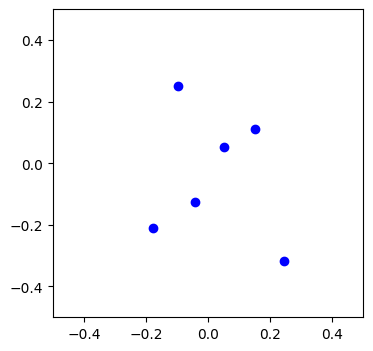

[np.float32(-14.816787), np.float32(-14.821721), np.float32(-14.73521), np.float32(-14.634573), np.float32(-14.729384), np.float32(-14.684191), np.float32(-14.569964), np.float32(-14.501075), np.float32(-14.588399), np.float32(-14.502728), np.float32(-14.407378), np.float32(-14.389209), np.float32(-14.490913), np.float32(-14.411303), np.float32(-14.349783), np.float32(-14.350679), np.float32(-14.984375), np.float32(-15.146586), np.float32(-14.970126), np.float32(-14.686004), np.float32(-14.886087), np.float32(-4.5264463), np.float32(-14.626187), np.float32(-14.461689), np.float32(-14.616299), np.float32(-14.451839), np.float32(-14.228641), np.float32(-14.278135), np.float32(-14.457243), np.float32(-14.319632), np.float32(-14.205119), np.float32(-14.250576), np.float32(-15.004057), np.float32(-15.327976), np.float32(-15.504852), np.float32(-14.709921), np.float32(-14.870729), np.float32(-15.032696), np.float32(-14.979013), np.float32(-14.419715), np.float32(-14.565834), np.float32(-14.3

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.79s/it]


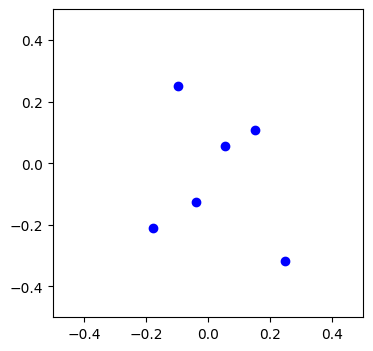

[np.float32(-14.827696), np.float32(-14.834309), np.float32(-14.747821), np.float32(-14.644958), np.float32(-14.736514), np.float32(-14.692615), np.float32(-14.577623), np.float32(-14.505353), np.float32(-14.58924), np.float32(-14.501777), np.float32(-14.403439), np.float32(-14.383159), np.float32(-14.486074), np.float32(-14.403023), np.float32(-14.338813), np.float32(-14.339226), np.float32(-14.997804), np.float32(-15.162753), np.float32(-14.986754), np.float32(-14.699534), np.float32(-14.896155), np.float32(-4.5413423), np.float32(-14.640092), np.float32(-14.468227), np.float32(-14.617713), np.float32(-14.450877), np.float32(-14.220769), np.float32(-14.266806), np.float32(-14.4505), np.float32(-14.307254), np.float32(-14.1890135), np.float32(-14.234559), np.float32(-15.018598), np.float32(-15.345569), np.float32(-15.523531), np.float32(-14.724919), np.float32(-14.882686), np.float32(-15.049507), np.float32(-14.997627), np.float32(-14.427589), np.float32(-14.568066), np.float32(-14.31

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.84s/it]


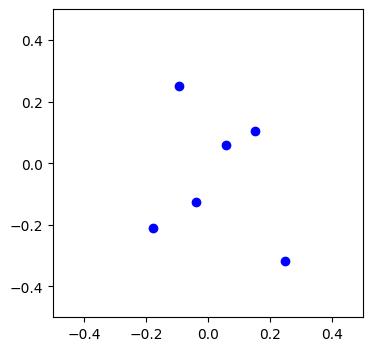

[np.float32(-14.840548), np.float32(-14.848418), np.float32(-14.761971), np.float32(-14.657486), np.float32(-14.7466545), np.float32(-14.703762), np.float32(-14.588233), np.float32(-14.513361), np.float32(-14.594422), np.float32(-14.505436), np.float32(-14.404178), np.float32(-14.381524), np.float32(-14.485736), np.float32(-14.398786), np.float32(-14.331053), np.float32(-14.3307), np.float32(-15.0125065), np.float32(-15.179555), np.float32(-15.003943), np.float32(-14.714388), np.float32(-14.908463), np.float32(-4.5572977), np.float32(-14.655274), np.float32(-14.478041), np.float32(-14.623474), np.float32(-14.454644), np.float32(-14.217252), np.float32(-14.258634), np.float32(-14.448142), np.float32(-14.29768), np.float32(-14.173949), np.float32(-14.219522), np.float32(-15.034143), np.float32(-15.363523), np.float32(-15.542415), np.float32(-14.740876), np.float32(-14.896375), np.float32(-15.0668545), np.float32(-15.01646), np.float32(-14.438415), np.float32(-14.574525), np.float32(-14.3

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.79s/it]


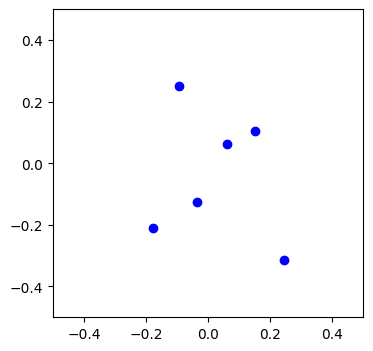

[np.float32(-14.854884), np.float32(-14.863723), np.float32(-14.777325), np.float32(-14.671626), np.float32(-14.759016), np.float32(-14.71691), np.float32(-14.601005), np.float32(-14.524171), np.float32(-14.603041), np.float32(-14.512886), np.float32(-14.409141), np.float32(-14.384224), np.float32(-14.489632), np.float32(-14.398891), np.float32(-14.327166), np.float32(-14.325788), np.float32(-15.02824), np.float32(-15.196934), np.float32(-15.021652), np.float32(-14.730293), np.float32(-14.92244), np.float32(-4.5741134), np.float32(-14.671469), np.float32(-14.490254), np.float32(-14.632607), np.float32(-14.462272), np.float32(-14.218275), np.float32(-14.254297), np.float32(-14.450192), np.float32(-14.29167), np.float32(-14.160351), np.float32(-14.20585), np.float32(-15.050532), np.float32(-15.381839), np.float32(-15.561522), np.float32(-14.757633), np.float32(-14.911392), np.float32(-15.084702), np.float32(-15.035537), np.float32(-14.451394), np.float32(-14.584217), np.float32(-14.32571

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.80s/it]


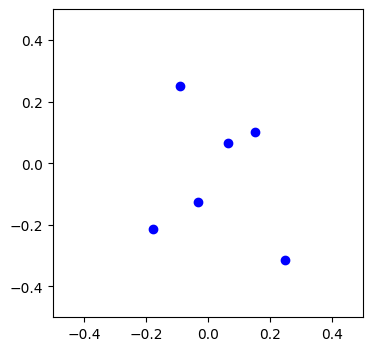

[np.float32(-14.870386), np.float32(-14.879981), np.float32(-14.793635), np.float32(-14.6870165), np.float32(-14.773068), np.float32(-14.731579), np.float32(-14.615411), np.float32(-14.537114), np.float32(-14.614332), np.float32(-14.52334), np.float32(-14.4176655), np.float32(-14.390847), np.float32(-14.49722), np.float32(-14.403263), np.float32(-14.327649), np.float32(-14.325111), np.float32(-15.044814), np.float32(-15.214815), np.float32(-15.039815), np.float32(-14.747045), np.float32(-14.937704), np.float32(-4.5916204), np.float32(-14.688471), np.float32(-14.504275), np.float32(-14.644327), np.float32(-14.472926), np.float32(-14.223596), np.float32(-14.254343), np.float32(-14.456294), np.float32(-14.289966), np.float32(-14.148928), np.float32(-14.194197), np.float32(-15.067623), np.float32(-15.400489), np.float32(-15.580846), np.float32(-14.775052), np.float32(-14.927451), np.float32(-15.102985), np.float32(-15.054845), np.float32(-14.465996), np.float32(-14.596371), np.float32(-14.

100%|█████████████████████████████████████████████| 7/7 [00:34<00:00,  4.87s/it]


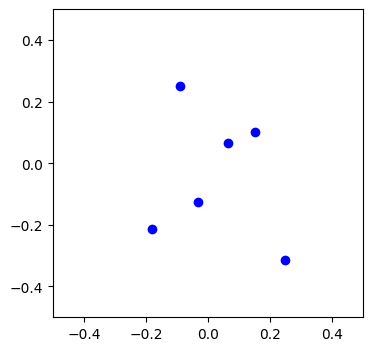

[np.float32(-14.886828), np.float32(-14.897024), np.float32(-14.81073), np.float32(-14.703401), np.float32(-14.788427), np.float32(-14.747427), np.float32(-14.631076), np.float32(-14.551676), np.float32(-14.6276455), np.float32(-14.536064), np.float32(-14.428947), np.float32(-14.400632), np.float32(-14.507729), np.float32(-14.411261), np.float32(-14.332306), np.float32(-14.328644), np.float32(-15.062092), np.float32(-15.233146), np.float32(-15.058389), np.float32(-14.764497), np.float32(-14.953988), np.float32(-4.609709), np.float32(-14.706143), np.float32(-14.519672), np.float32(-14.657989), np.float32(-14.48585), np.float32(-14.232459), np.float32(-14.258619), np.float32(-14.465689), np.float32(-14.292664), np.float32(-14.140481), np.float32(-14.185308), np.float32(-15.085315), np.float32(-15.419453), np.float32(-15.600386), np.float32(-14.793037), np.float32(-14.944354), np.float32(-15.121665), np.float32(-15.074381), np.float32(-14.48184), np.float32(-14.61037), np.float32(-14.3516

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.83s/it]


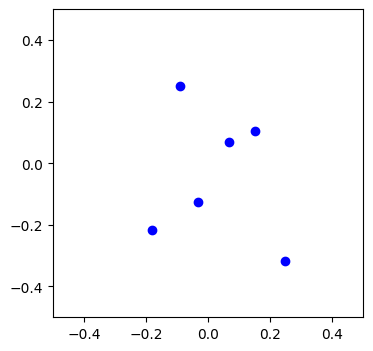

[np.float32(-14.90404), np.float32(-14.914735), np.float32(-14.82849), np.float32(-14.720588), np.float32(-14.8047905), np.float32(-14.764201), np.float32(-14.647714), np.float32(-14.567425), np.float32(-14.642387), np.float32(-14.550361), np.float32(-14.442088), np.float32(-14.412526), np.float32(-14.520197), np.float32(-14.421669), np.float32(-14.339811), np.float32(-14.335099), np.float32(-15.079981), np.float32(-15.251898), np.float32(-15.077354), np.float32(-14.7825575), np.float32(-14.9711), np.float32(-4.628341), np.float32(-14.724408), np.float32(-14.536112), np.float32(-14.673032), np.float32(-14.500344), np.float32(-14.243664), np.float32(-14.265801), np.float32(-14.47727), np.float32(-14.29843), np.float32(-14.134486), np.float32(-14.178711), np.float32(-15.103543), np.float32(-15.438724), np.float32(-15.620134), np.float32(-14.811533), np.float32(-14.96197), np.float32(-15.140734), np.float32(-15.094156), np.float32(-14.498646), np.float32(-14.625693), np.float32(-14.36691)

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.85s/it]


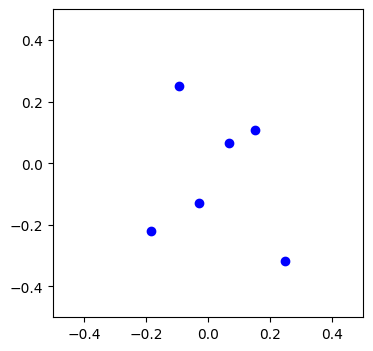

[np.float32(-14.9218855), np.float32(-14.932997), np.float32(-14.846801), np.float32(-14.738431), np.float32(-14.821965), np.float32(-14.781726), np.float32(-14.665136), np.float32(-14.584125), np.float32(-14.658266), np.float32(-14.565903), np.float32(-14.456703), np.float32(-14.426109), np.float32(-14.534229), np.float32(-14.434029), np.float32(-14.349714), np.float32(-14.344063), np.float32(-15.098379), np.float32(-15.271008), np.float32(-15.096652), np.float32(-14.801122), np.float32(-14.988887), np.float32(-4.6474257), np.float32(-14.743164), np.float32(-14.553389), np.float32(-14.689174), np.float32(-14.516077), np.float32(-14.256742), np.float32(-14.275443), np.float32(-14.490601), np.float32(-14.306849), np.float32(-14.131144), np.float32(-14.1746235), np.float32(-15.122222), np.float32(-15.458257), np.float32(-15.640061), np.float32(-14.830455), np.float32(-14.980172), np.float32(-15.160131), np.float32(-15.114138), np.float32(-14.516224), np.float32(-14.64207), np.float32(-14

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.84s/it]


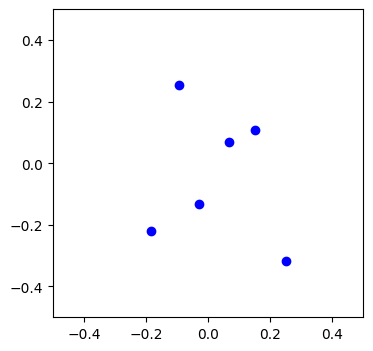

[np.float32(-14.940085), np.float32(-14.95156), np.float32(-14.865411), np.float32(-14.756643), np.float32(-14.83961), np.float32(-14.799682), np.float32(-14.68301), np.float32(-14.601376), np.float32(-14.674808), np.float32(-14.58217), np.float32(-14.472167), np.float32(-14.440658), np.float32(-14.549162), np.float32(-14.447495), np.float32(-14.360958), np.float32(-14.354426), np.float32(-15.11705), np.float32(-15.290283), np.float32(-15.1160965), np.float32(-14.819954), np.float32(-15.00706), np.float32(-4.66675), np.float32(-14.76218), np.float32(-14.571147), np.float32(-14.705956), np.float32(-14.532529), np.float32(-14.270879), np.float32(-14.286459), np.float32(-14.504931), np.float32(-14.316737), np.float32(-14.129208), np.float32(-14.171867), np.float32(-15.141132), np.float32(-15.477883), np.float32(-15.660014), np.float32(-14.849591), np.float32(-14.998699), np.float32(-15.179677), np.float32(-15.134171), np.float32(-14.534245), np.float32(-14.659059), np.float32(-14.400343),

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.79s/it]


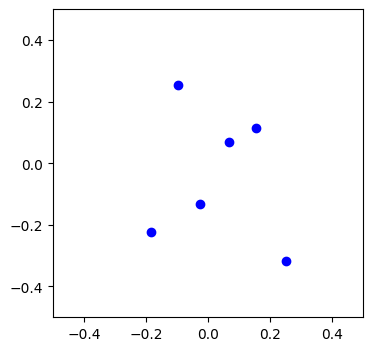

[np.float32(-14.958539), np.float32(-14.970331), np.float32(-14.884227), np.float32(-14.775118), np.float32(-14.857603), np.float32(-14.817953), np.float32(-14.701216), np.float32(-14.6190405), np.float32(-14.691858), np.float32(-14.598995), np.float32(-14.488296), np.float32(-14.455972), np.float32(-14.564803), np.float32(-14.461852), np.float32(-14.373308), np.float32(-14.365957), np.float32(-15.135906), np.float32(-15.309653), np.float32(-15.135619), np.float32(-14.838964), np.float32(-15.025512), np.float32(-4.6862316), np.float32(-14.781371), np.float32(-14.589264), np.float32(-14.723229), np.float32(-14.549535), np.float32(-14.285862), np.float32(-14.298613), np.float32(-14.520058), np.float32(-14.32786), np.float32(-14.128608), np.float32(-14.170383), np.float32(-15.1601925), np.float32(-15.497543), np.float32(-15.67994), np.float32(-14.868861), np.float32(-15.017455), np.float32(-15.199304), np.float32(-15.154206), np.float32(-14.55259), np.float32(-14.676515), np.float32(-14.4

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.84s/it]


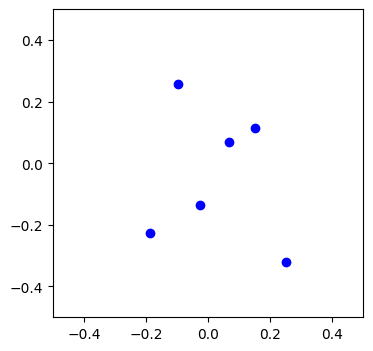

[np.float32(-14.977027), np.float32(-14.989105), np.float32(-14.903043), np.float32(-14.7936325), np.float32(-14.875697), np.float32(-14.836301), np.float32(-14.719507), np.float32(-14.636847), np.float32(-14.709113), np.float32(-14.616056), np.float32(-14.504726), np.float32(-14.471654), np.float32(-14.580778), np.float32(-14.476655), np.float32(-14.386239), np.float32(-14.378108), np.float32(-15.15475), np.float32(-15.328946), np.float32(-15.155053), np.float32(-14.857957), np.float32(-15.044016), np.float32(-4.7056775), np.float32(-14.80054), np.float32(-14.607483), np.float32(-14.740694), np.float32(-14.566771), np.float32(-14.301258), np.float32(-14.311369), np.float32(-14.53557), np.float32(-14.339637), np.float32(-14.128658), np.float32(-14.169517), np.float32(-15.179215), np.float32(-15.517083), np.float32(-15.699704), np.float32(-14.888082), np.float32(-15.036227), np.float32(-15.2188425), np.float32(-15.1741), np.float32(-14.571018), np.float32(-14.694144), np.float32(-14.435

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.85s/it]


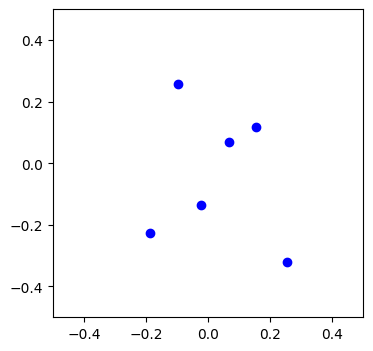

[np.float32(-14.995525), np.float32(-15.00786), np.float32(-14.921837), np.float32(-14.8121605), np.float32(-14.893862), np.float32(-14.854697), np.float32(-14.737855), np.float32(-14.654759), np.float32(-14.726537), np.float32(-14.633314), np.float32(-14.521416), np.float32(-14.4876585), np.float32(-14.597044), np.float32(-14.4918585), np.float32(-14.399708), np.float32(-14.39084), np.float32(-15.173561), np.float32(-15.348147), np.float32(-15.174383), np.float32(-14.87691), np.float32(-15.062548), np.float32(-4.725069), np.float32(-14.819666), np.float32(-14.625774), np.float32(-14.758314), np.float32(-14.584196), np.float32(-14.3170185), np.float32(-14.324684), np.float32(-14.551426), np.float32(-14.352035), np.float32(-14.12943), np.float32(-14.169337), np.float32(-15.198182), np.float32(-15.53649), np.float32(-15.719299), np.float32(-14.907233), np.float32(-15.054993), np.float32(-15.238281), np.float32(-15.193848), np.float32(-14.589499), np.float32(-14.711913), np.float32(-14.45

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.81s/it]


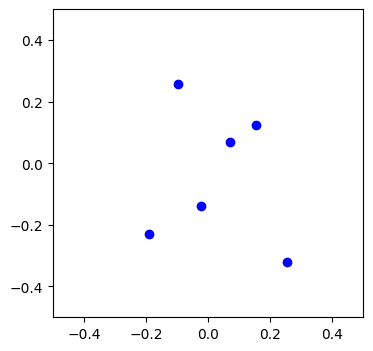

[np.float32(-15.01379), np.float32(-15.026362), np.float32(-14.940375), np.float32(-14.830453), np.float32(-14.911826), np.float32(-14.872877), np.float32(-14.755988), np.float32(-14.672486), np.float32(-14.74381), np.float32(-14.650433), np.float32(-14.537996), np.float32(-14.503589), np.float32(-14.613221), np.float32(-14.507026), np.float32(-14.413202), np.float32(-14.403619), np.float32(-15.192114), np.float32(-15.367055), np.float32(-15.193412), np.float32(-14.895597), np.float32(-15.080855), np.float32(-4.744181), np.float32(-14.838523), np.float32(-14.64386), np.float32(-14.775775), np.float32(-14.601473), np.float32(-14.332714), np.float32(-14.338037), np.float32(-14.567216), np.float32(-14.364488), np.float32(-14.130191), np.float32(-14.169143), np.float32(-15.216876), np.float32(-15.555582), np.float32(-15.738558), np.float32(-14.926104), np.float32(-15.073511), np.float32(-15.25742), np.float32(-15.213273), np.float32(-14.607765), np.float32(-14.72951), np.float32(-14.47108)

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.73s/it]


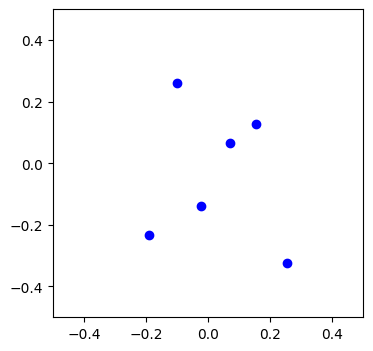

[np.float32(-15.031668), np.float32(-15.044465), np.float32(-14.958509), np.float32(-14.848351), np.float32(-14.9294195), np.float32(-14.890675), np.float32(-14.773734), np.float32(-14.68984), np.float32(-14.760733), np.float32(-14.667202), np.float32(-14.554237), np.float32(-14.519197), np.float32(-14.629077), np.float32(-14.521889), np.float32(-14.426413), np.float32(-14.416124), np.float32(-15.210266), np.float32(-15.385541), np.float32(-15.21201), np.float32(-14.913873), np.float32(-15.09878), np.float32(-4.7628703), np.float32(-14.856964), np.float32(-14.661562), np.float32(-14.792879), np.float32(-14.618389), np.float32(-14.348079), np.float32(-14.3511095), np.float32(-14.58269), np.float32(-14.376659), np.float32(-14.130532), np.float32(-14.16854), np.float32(-15.235159), np.float32(-15.574239), np.float32(-15.757369), np.float32(-14.944553), np.float32(-15.091629), np.float32(-15.27613), np.float32(-15.232264), np.float32(-14.625644), np.float32(-14.746739), np.float32(-14.4883

100%|█████████████████████████████████████████████| 7/7 [00:32<00:00,  4.71s/it]


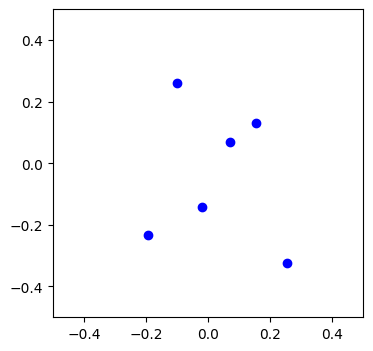

[np.float32(-15.049102), np.float32(-15.062115), np.float32(-14.976186), np.float32(-14.865796), np.float32(-14.946577), np.float32(-14.908026), np.float32(-14.79103), np.float32(-14.706753), np.float32(-14.777229), np.float32(-14.683541), np.float32(-14.570049), np.float32(-14.534389), np.float32(-14.644518), np.float32(-14.536341), np.float32(-14.439215), np.float32(-14.428228), np.float32(-15.227967), np.float32(-15.403562), np.float32(-15.230137), np.float32(-14.931686), np.float32(-15.116261), np.float32(-4.781084), np.float32(-14.874938), np.float32(-14.678815), np.float32(-14.809549), np.float32(-14.634861), np.float32(-14.363006), np.float32(-14.363776), np.float32(-14.59775), np.float32(-14.388413), np.float32(-14.130297), np.float32(-14.16738), np.float32(-15.252983), np.float32(-15.592422), np.float32(-15.775697), np.float32(-14.962536), np.float32(-15.10929), np.float32(-15.294368), np.float32(-15.250784), np.float32(-14.643071), np.float32(-14.763526), np.float32(-14.50521

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.82s/it]


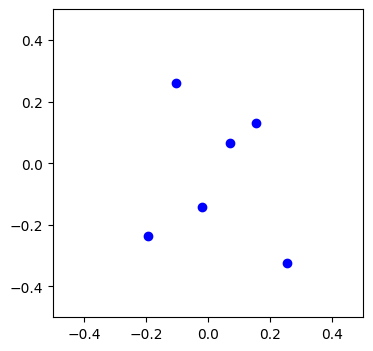

[np.float32(-15.06606), np.float32(-15.079281), np.float32(-14.993374), np.float32(-14.882756), np.float32(-14.963264), np.float32(-14.924896), np.float32(-14.807838), np.float32(-14.723183), np.float32(-14.793258), np.float32(-14.699405), np.float32(-14.585383), np.float32(-14.5491085), np.float32(-14.659494), np.float32(-14.550325), np.float32(-14.451544), np.float32(-14.439863), np.float32(-15.245189), np.float32(-15.421092), np.float32(-15.2477665), np.float32(-14.949008), np.float32(-15.133266), np.float32(-4.798795), np.float32(-14.892415), np.float32(-14.6955805), np.float32(-14.825746), np.float32(-14.650845), np.float32(-14.377439), np.float32(-14.37597), np.float32(-14.612342), np.float32(-14.399683), np.float32(-14.129421), np.float32(-14.165606), np.float32(-15.270321), np.float32(-15.610109), np.float32(-15.793525), np.float32(-14.980023), np.float32(-15.126466), np.float32(-15.312109), np.float32(-15.268815), np.float32(-14.660013), np.float32(-14.77983), np.float32(-14.5

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.82s/it]


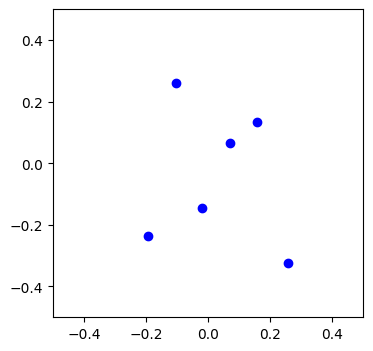

[np.float32(-15.082464), np.float32(-15.095888), np.float32(-15.009998), np.float32(-14.89915), np.float32(-14.979394), np.float32(-14.941203), np.float32(-14.824075), np.float32(-14.739037), np.float32(-14.808716), np.float32(-14.714686), np.float32(-14.6001215), np.float32(-14.5632305), np.float32(-14.673885), np.float32(-14.5637045), np.float32(-14.463238), np.float32(-14.450858), np.float32(-15.261857), np.float32(-15.438068), np.float32(-15.264837), np.float32(-14.965764), np.float32(-15.149717), np.float32(-4.8159337), np.float32(-14.909326), np.float32(-14.711771), np.float32(-14.841369), np.float32(-14.666234), np.float32(-14.391244), np.float32(-14.387525), np.float32(-14.626337), np.float32(-14.410292), np.float32(-14.127706), np.float32(-14.163016), np.float32(-15.287103), np.float32(-15.627245), np.float32(-15.810802), np.float32(-14.996947), np.float32(-15.143079), np.float32(-15.329295), np.float32(-15.286306), np.float32(-14.676382), np.float32(-14.795553), np.float32(-1

100%|█████████████████████████████████████████████| 7/7 [00:32<00:00,  4.69s/it]


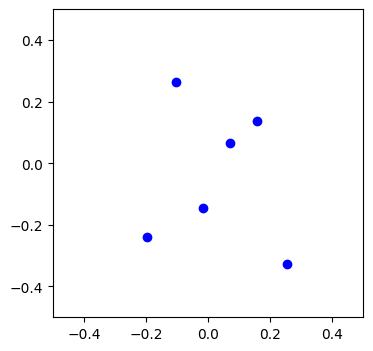

[np.float32(-15.098276), np.float32(-15.111901), np.float32(-15.026023), np.float32(-14.914938), np.float32(-14.994923), np.float32(-14.9569025), np.float32(-14.839694), np.float32(-14.754266), np.float32(-14.823551), np.float32(-14.729331), np.float32(-14.614203), np.float32(-14.576689), np.float32(-14.68763), np.float32(-14.5764065), np.float32(-14.4742155), np.float32(-14.461131), np.float32(-15.277939), np.float32(-15.45446), np.float32(-15.28132), np.float32(-14.98192), np.float32(-15.165572), np.float32(-4.8324623), np.float32(-14.925631), np.float32(-14.72734), np.float32(-14.856365), np.float32(-14.680972), np.float32(-14.40435), np.float32(-14.3983555), np.float32(-14.639668), np.float32(-14.42015), np.float32(-14.125076), np.float32(-14.159548), np.float32(-15.303295), np.float32(-15.643801), np.float32(-15.827507), np.float32(-15.013274), np.float32(-15.159089), np.float32(-15.345891), np.float32(-15.303227), np.float32(-14.692133), np.float32(-14.810642), np.float32(-14.552

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.74s/it]


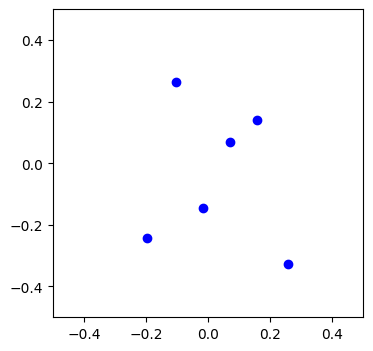

[np.float32(-15.113504), np.float32(-15.12733), np.float32(-15.041458), np.float32(-14.930129), np.float32(-15.009857), np.float32(-14.972002), np.float32(-14.854704), np.float32(-14.768878), np.float32(-14.83777), np.float32(-14.743343), np.float32(-14.627633), np.float32(-14.589487), np.float32(-14.700731), np.float32(-14.588434), np.float32(-14.484478), np.float32(-14.470682), np.float32(-15.293443), np.float32(-15.470279), np.float32(-15.297224), np.float32(-14.997486), np.float32(-15.18084), np.float32(-4.84839), np.float32(-14.9413395), np.float32(-14.742293), np.float32(-14.870741), np.float32(-14.695063), np.float32(-14.416759), np.float32(-14.408464), np.float32(-14.652339), np.float32(-14.429256), np.float32(-14.1215515), np.float32(-14.155223), np.float32(-15.318909), np.float32(-15.659789), np.float32(-15.843651), np.float32(-15.029015), np.float32(-15.174506), np.float32(-15.361906), np.float32(-15.319588), np.float32(-14.7072735), np.float32(-14.825103), np.float32(-14.56

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.73s/it]


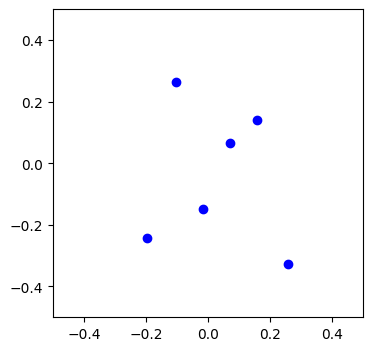

[np.float32(-15.128237), np.float32(-15.142258), np.float32(-15.056388), np.float32(-14.944813), np.float32(-15.024294), np.float32(-14.986596), np.float32(-14.8692), np.float32(-14.782974), np.float32(-14.8514805), np.float32(-14.756836), np.float32(-14.640532), np.float32(-14.601752), np.float32(-14.713312), np.float32(-14.599925), np.float32(-14.494181), np.float32(-14.4796715), np.float32(-15.308452), np.float32(-15.4855995), np.float32(-15.312626), np.float32(-15.012545), np.float32(-15.19561), np.float32(-4.863804), np.float32(-14.956538), np.float32(-14.756732), np.float32(-14.8846035), np.float32(-14.708621), np.float32(-14.428606), np.float32(-14.418009), np.float32(-14.664479), np.float32(-14.437782), np.float32(-14.117339), np.float32(-14.15024), np.float32(-15.334023), np.float32(-15.675281), np.float32(-15.859299), np.float32(-15.04425), np.float32(-15.189419), np.float32(-15.37742), np.float32(-15.335464), np.float32(-14.721902), np.float32(-14.839044), np.float32(-14.580

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.79s/it]


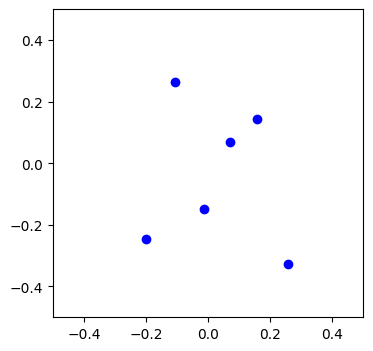

[np.float32(-15.142445), np.float32(-15.156659), np.float32(-15.070786), np.float32(-14.958961), np.float32(-15.038199), np.float32(-15.000652), np.float32(-14.883149), np.float32(-14.796519), np.float32(-14.864641), np.float32(-14.769766), np.float32(-14.65285), np.float32(-14.613432), np.float32(-14.725324), np.float32(-14.61082), np.float32(-14.503254), np.float32(-14.488026), np.float32(-15.322941), np.float32(-15.500402), np.float32(-15.327506), np.float32(-15.027072), np.float32(-15.209853), np.float32(-4.8786774), np.float32(-14.971201), np.float32(-14.77062), np.float32(-14.897914), np.float32(-14.721603), np.float32(-14.439836), np.float32(-14.426916), np.float32(-14.676036), np.float32(-14.445651), np.float32(-14.112364), np.float32(-14.144527), np.float32(-15.348617), np.float32(-15.690259), np.float32(-15.87444), np.float32(-15.058956), np.float32(-15.203798), np.float32(-15.392412), np.float32(-15.350835), np.float32(-14.735985), np.float32(-14.852426), np.float32(-14.5940

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.75s/it]


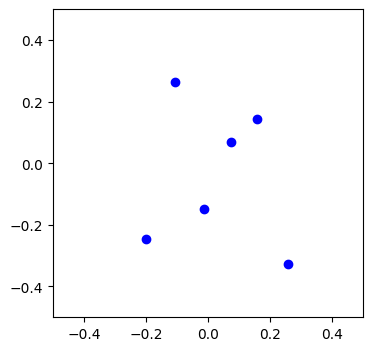

[np.float32(-15.156107), np.float32(-15.170515), np.float32(-15.084634), np.float32(-14.972549), np.float32(-15.051549), np.float32(-15.014148), np.float32(-14.896528), np.float32(-14.809484), np.float32(-14.877222), np.float32(-14.782101), np.float32(-14.664553), np.float32(-14.624486), np.float32(-14.736727), np.float32(-14.621075), np.float32(-14.511644), np.float32(-14.495689), np.float32(-15.336892), np.float32(-15.514672), np.float32(-15.341848), np.float32(-15.041048), np.float32(-15.223548), np.float32(-4.892993), np.float32(-14.985309), np.float32(-14.783933), np.float32(-14.910642), np.float32(-14.733977), np.float32(-14.450404), np.float32(-14.435133), np.float32(-14.686967), np.float32(-14.452802), np.float32(-14.106578), np.float32(-14.138042), np.float32(-15.36267), np.float32(-15.70471), np.float32(-15.889061), np.float32(-15.073116), np.float32(-15.217625), np.float32(-15.406866), np.float32(-15.365688), np.float32(-14.7494955), np.float32(-14.865218), np.float32(-14.60

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.75s/it]


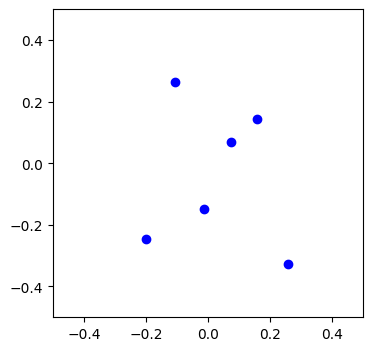

[np.float32(-15.169288), np.float32(-15.1838875), np.float32(-15.097993), np.float32(-14.985645), np.float32(-15.064409), np.float32(-15.027149), np.float32(-14.909405), np.float32(-14.821939), np.float32(-14.889297), np.float32(-14.793916), np.float32(-14.675718), np.float32(-14.634995), np.float32(-14.7476015), np.float32(-14.630774), np.float32(-14.5194435), np.float32(-14.502755), np.float32(-15.350366), np.float32(-15.528467), np.float32(-15.355713), np.float32(-15.054536), np.float32(-15.236759), np.float32(-4.906814), np.float32(-14.998926), np.float32(-14.796739), np.float32(-14.92286), np.float32(-14.74582), np.float32(-14.4604), np.float32(-14.442753), np.float32(-14.697355), np.float32(-14.459334), np.float32(-14.100084), np.float32(-14.13088), np.float32(-15.3762455), np.float32(-15.718691), np.float32(-15.903219), np.float32(-15.086792), np.float32(-15.230963), np.float32(-15.420842), np.float32(-15.380082), np.float32(-14.762505), np.float32(-14.877496), np.float32(-14.61

100%|█████████████████████████████████████████████| 7/7 [00:33<00:00,  4.80s/it]


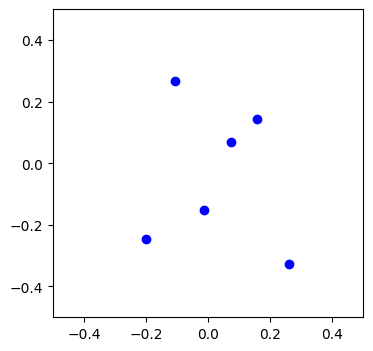

[np.float32(-15.18201), np.float32(-15.196799), np.float32(-15.110888), np.float32(-14.998271), np.float32(-15.076805), np.float32(-15.039681), np.float32(-14.921804), np.float32(-14.833911), np.float32(-14.90089), np.float32(-14.805239), np.float32(-14.686377), np.float32(-14.644991), np.float32(-14.757977), np.float32(-14.63995), np.float32(-14.526688), np.float32(-14.509259), np.float32(-15.363385), np.float32(-15.541809), np.float32(-15.369121), np.float32(-15.067558), np.float32(-15.24951), np.float32(-4.920164), np.float32(-15.012075), np.float32(-14.809063), np.float32(-14.934595), np.float32(-14.757161), np.float32(-14.469856), np.float32(-14.44981), np.float32(-14.7072315), np.float32(-14.465287), np.float32(-14.092944), np.float32(-14.123099), np.float32(-15.389364), np.float32(-15.732223), np.float32(-15.916929), np.float32(-15.100004), np.float32(-15.243835), np.float32(-15.434361), np.float32(-15.394034), np.float32(-14.775035), np.float32(-14.889284), np.float32(-14.63071

In [5]:
optimizer = torch.optim.Adam([masses_presoftplus], lr=0.01)
masses_constraint = 0.02

masses_try = []
losses = []

for epoch in range(100):
    optimizer.zero_grad()              
    endpoints = forward(initial_xs=initial_xs, initial_vs=initial_vs, masses=masses_presoftplus)
    l = loss(endpoints, y, masses_presoftplus, masses_constraint)
    plot_forward(endpoints)
    l.backward(retain_graph=True)
#     print(masses)
    masses_try.append(masses_presoftplus.detach().numpy().copy())
    print(list(masses_try[-1]))
    optimizer.step()
    print(f"Loss = {l.item():.6f}")
    print(epoch)
    losses.append(l.item())

In [6]:
# masses_try = [masses_try[i].detach().numpy() for i in range(len(masses_try))]
masses_try = np.array(masses_try)

In [ ]:
np.save(__AVOID_OVERWRITE__, masses_try)

In [28]:
masses_try2 = masses_try

In [8]:
masses_try2 = np.load("NEW_masses_try1004.npy")

In [9]:
delta = masses_try[0:100] - masses_try2[0:100]
delta_norm = np.square(delta)
delta_norm = np.sqrt(np.sum(delta_norm, axis=-1))

In [10]:
growth = delta_norm / delta_norm[0]

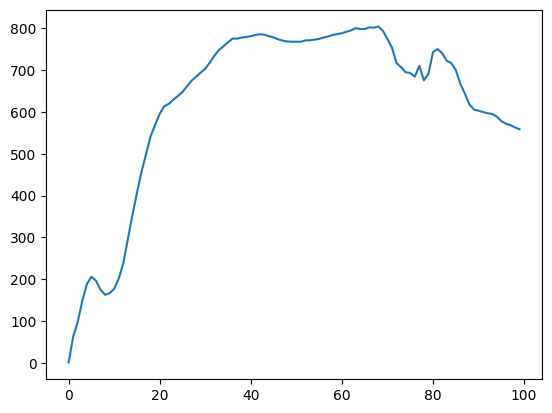

In [11]:
plt.plot(growth)

In [12]:
t = np.arange(len(growth)) + 1
exponent = np.log(growth) / t

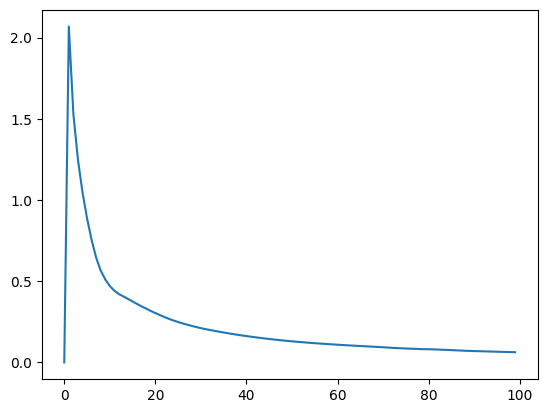

In [13]:
plt.plot(exponent)

## Loss Surface Hassian Eigenvalues

In [ ]:
lll = []
def compute_hessian_eigenvalues(loss_fn, N, N_points, sampling_bound, device='cpu'):
   
    eigenvalues_list = []
    low, high = sampling_bound

    for _ in range(N_points):
        x = torch.empty(N, device=device).uniform_(low, high).requires_grad_(True)

        loss = loss_fn(x)
        grad = torch.autograd.grad(loss, x, create_graph=True)[0]

        H = torch.zeros(N, N, device=device)
        for i in tqdm(range(N)):
            grad_i = grad[i]
            second_derivatives = torch.autograd.grad(grad_i, x, retain_graph=True)[0]
            H[i] = second_derivatives

        eigvals = torch.linalg.eigvalsh(H)  
        eigenvalues_list.append(eigvals.detach().cpu())
        lll.append(eigvals.detach().cpu())
        print(lll[-1])

    return eigenvalues_list

In [104]:
lll

[tensor([-3.2288e+14, -1.6095e+10, -1.6660e+08, -1.2579e+08, -9.2297e+07,
         -5.7627e+07, -4.6334e+07, -3.2522e+07, -3.1163e+07, -2.6706e+07,
         -2.2743e+07, -2.1182e+07, -1.9455e+07, -1.7143e+07, -1.5773e+07,
         -1.4646e+07, -1.3846e+07, -1.2024e+07, -8.9732e+06, -8.8965e+06,
         -8.5407e+06, -7.2057e+06, -6.1374e+06, -5.4416e+06, -4.2510e+06,
         -3.3375e+06, -2.9169e+06, -1.9584e+06, -1.6428e+06, -1.4571e+06,
         -8.3278e+05,  3.7753e+05,  7.4688e+05,  1.8718e+06,  2.7545e+06,
          3.1429e+06,  4.2312e+06,  4.3277e+06,  5.2527e+06,  5.6339e+06,
          7.4732e+06,  7.8972e+06,  1.0325e+07,  1.1501e+07,  1.2221e+07,
          1.3409e+07,  1.3917e+07,  1.5118e+07,  1.8187e+07,  1.9149e+07,
          2.0573e+07,  2.3410e+07,  2.5789e+07,  3.8752e+07,  4.6229e+07,
          5.2462e+07,  7.2254e+07,  1.4638e+08,  2.3511e+08,  3.3814e+08,
          3.0999e+09,  9.5380e+09,  1.8365e+10,  5.6524e+11]),
 tensor([-1.8715e+08, -4.7835e+07, -6.8096e+06, -

In [105]:
def loss_for_H(masses):
    endpoints = forward(initial_xs=initial_xs, initial_vs=initial_vs, masses=masses)
    l = loss(endpoints, y, masses, masses_constraint)
    return l

In [109]:
sampling_bound = (0, 0.1)
eigenvalues = compute_hessian_eigenvalues(loss_for_H, 64, 30, sampling_bound)

100%|███████████████████████████████████████████| 64/64 [24:38<00:00, 23.10s/it]


tensor([-1.8803e+09, -8.4602e+08, -3.6592e+08, -2.4254e+08, -2.1439e+08,
        -1.6785e+08, -1.3339e+08, -1.1765e+08, -1.0461e+08, -9.4510e+07,
        -9.0719e+07, -7.8358e+07, -6.9741e+07, -6.4693e+07, -6.2691e+07,
        -5.2632e+07, -4.7445e+07, -4.4598e+07, -3.5557e+07, -3.2090e+07,
        -2.9320e+07, -2.6273e+07, -2.2015e+07, -1.7952e+07, -1.5871e+07,
        -1.1418e+07, -7.7589e+06, -7.5439e+06, -5.1051e+06, -1.5373e+06,
        -3.0255e+05,  9.4317e+05,  5.0175e+06,  8.2422e+06,  1.0529e+07,
         1.4184e+07,  1.6821e+07,  1.7371e+07,  2.0347e+07,  2.4383e+07,
         2.7330e+07,  2.9354e+07,  3.3029e+07,  3.8948e+07,  4.2883e+07,
         4.4320e+07,  4.7622e+07,  5.4786e+07,  5.6153e+07,  6.6811e+07,
         7.0541e+07,  7.7738e+07,  1.0013e+08,  1.0889e+08,  1.3289e+08,
         1.4379e+08,  1.6100e+08,  2.0767e+08,  3.1893e+08,  1.1631e+09,
         1.9194e+09,  4.7028e+09,  3.3306e+10,  2.0780e+15])


100%|███████████████████████████████████████████| 64/64 [13:38<00:00, 12.79s/it]


tensor([-3.2006e+11, -9.2485e+08, -1.9187e+08, -3.9416e+07, -2.9568e+07,
        -2.0701e+07, -1.7556e+07, -1.6189e+07, -1.3577e+07, -1.1928e+07,
        -1.0737e+07, -9.8980e+06, -8.9885e+06, -8.0965e+06, -7.1831e+06,
        -6.7181e+06, -6.1708e+06, -5.8931e+06, -5.5958e+06, -4.5908e+06,
        -3.8846e+06, -3.7390e+06, -3.0493e+06, -2.8101e+06, -2.5455e+06,
        -2.2853e+06, -2.0181e+06, -1.6480e+06, -1.3865e+06, -1.1479e+06,
        -9.0969e+05, -3.0922e+05, -1.2627e+05,  6.9724e+04,  4.9811e+05,
         7.8456e+05,  1.2029e+06,  1.5428e+06,  1.8853e+06,  2.0469e+06,
         2.5190e+06,  2.6403e+06,  2.9762e+06,  3.9013e+06,  4.0964e+06,
         4.2574e+06,  4.7471e+06,  5.0823e+06,  5.7438e+06,  6.1315e+06,
         6.6989e+06,  7.7411e+06,  9.1324e+06,  1.0249e+07,  1.1181e+07,
         1.1880e+07,  1.2097e+07,  1.4399e+07,  1.5432e+07,  2.2468e+07,
         4.2131e+07,  3.9026e+08,  4.9700e+09,  2.8026e+14])


100%|███████████████████████████████████████████| 64/64 [17:30<00:00, 16.41s/it]


tensor([-6.2060e+12, -1.5123e+11, -7.7193e+10, -4.8959e+10, -3.0265e+10,
        -2.2467e+10, -1.9283e+10, -1.4608e+10, -1.1852e+10, -9.7541e+09,
        -7.3914e+09, -6.4874e+09, -5.9943e+09, -5.0151e+09, -4.5013e+09,
        -4.1382e+09, -3.8547e+09, -3.3415e+09, -3.3269e+09, -2.7076e+09,
        -2.3029e+09, -1.8936e+09, -1.4492e+09, -1.2832e+09, -1.2670e+09,
        -1.1166e+09, -8.5298e+08, -8.3665e+08, -6.7524e+08, -3.0447e+08,
        -2.5962e+08, -1.3384e+08, -2.0665e+07,  1.9841e+08,  2.2174e+08,
         4.8606e+08,  6.4737e+08,  9.3444e+08,  1.0560e+09,  1.0991e+09,
         1.2688e+09,  1.7192e+09,  2.0970e+09,  2.8943e+09,  3.0345e+09,
         3.9471e+09,  4.3745e+09,  4.4162e+09,  4.7216e+09,  5.1769e+09,
         5.9816e+09,  6.4690e+09,  1.0470e+10,  1.1898e+10,  1.2438e+10,
         1.4154e+10,  1.6657e+10,  1.8553e+10,  2.5720e+10,  3.4760e+10,
         3.8638e+10,  5.0412e+10,  8.8944e+10,  3.5044e+17])


100%|███████████████████████████████████████████| 64/64 [27:50<00:00, 26.11s/it]


tensor([-3.0191e+18, -1.6703e+12, -7.2924e+11, -6.0196e+11, -3.7074e+11,
        -3.3603e+11, -2.7988e+11, -2.3267e+11, -2.0961e+11, -1.4866e+11,
        -1.3240e+11, -1.1962e+11, -1.0348e+11, -8.5461e+10, -5.0964e+10,
        -4.2123e+10, -3.8593e+10, -3.7695e+10, -3.3629e+10, -2.7826e+10,
        -2.0545e+10, -1.9061e+10, -1.6783e+10, -1.4713e+10, -1.2935e+10,
        -1.1916e+10, -1.1718e+10, -6.2121e+09, -4.2511e+09, -1.2029e+09,
        -4.4473e+08,  1.5076e+09,  3.2450e+09,  3.8912e+09,  6.8691e+09,
         7.9238e+09,  9.2029e+09,  1.1865e+10,  1.7714e+10,  1.8376e+10,
         2.0673e+10,  2.1960e+10,  3.1802e+10,  3.5545e+10,  4.3250e+10,
         4.5720e+10,  4.8725e+10,  5.8209e+10,  6.0788e+10,  6.6320e+10,
         7.1567e+10,  8.0720e+10,  8.6712e+10,  9.0261e+10,  1.3673e+11,
         1.7515e+11,  1.9344e+11,  2.3007e+11,  2.7333e+11,  4.2128e+11,
         5.8290e+11,  8.2943e+11,  1.7729e+12,  1.9499e+14])


100%|███████████████████████████████████████████| 64/64 [27:31<00:00, 25.81s/it]


tensor([-1.3456e+12, -1.5871e+09, -4.3704e+08, -1.7888e+08, -1.2062e+08,
        -1.0832e+08, -9.1366e+07, -7.9416e+07, -7.3491e+07, -7.2089e+07,
        -5.8306e+07, -5.4718e+07, -4.6211e+07, -4.2935e+07, -4.1117e+07,
        -4.0625e+07, -3.3359e+07, -2.6662e+07, -2.5057e+07, -2.2039e+07,
        -2.0374e+07, -1.5405e+07, -1.1281e+07, -9.8772e+06, -9.2148e+06,
        -7.5047e+06, -5.9297e+06, -5.5933e+06, -1.5695e+06, -4.6123e+05,
         8.8124e+05,  1.7879e+06,  2.0939e+06,  4.7283e+06,  6.0015e+06,
         7.8365e+06,  9.8654e+06,  1.2362e+07,  1.3119e+07,  1.5434e+07,
         1.7154e+07,  2.1724e+07,  2.2992e+07,  2.5432e+07,  2.7942e+07,
         3.0104e+07,  3.3742e+07,  4.1653e+07,  4.3151e+07,  5.1284e+07,
         5.4400e+07,  6.2520e+07,  6.6140e+07,  6.8892e+07,  7.6776e+07,
         9.9691e+07,  1.1899e+08,  1.4463e+08,  1.6365e+08,  1.4775e+09,
         4.0201e+09,  5.1838e+09,  1.4267e+10,  1.0283e+15])


100%|███████████████████████████████████████████| 64/64 [08:11<00:00,  7.68s/it]


tensor([-9.6130e+07, -1.9988e+07, -1.0954e+06, -2.7377e+05, -7.9039e+04,
        -4.5260e+04, -8.3965e+03, -5.3415e+03, -3.0561e+03, -2.2702e+03,
        -8.3579e+02, -3.9103e+02, -3.3571e+02, -2.7516e+02, -2.3066e+02,
        -2.0260e+02, -1.6065e+02, -1.4423e+02, -1.2062e+02, -1.0973e+02,
        -1.0509e+02, -9.0908e+01, -7.1661e+01, -5.4630e+01, -4.3672e+01,
        -3.9708e+01, -2.7225e+01, -1.8278e+01, -1.4895e+01, -7.1636e+00,
        -5.1437e+00,  4.5082e+00,  1.2674e+01,  1.4889e+01,  2.0989e+01,
         2.4117e+01,  3.9107e+01,  4.1815e+01,  4.8079e+01,  6.2185e+01,
         7.5719e+01,  8.4272e+01,  9.8640e+01,  1.1068e+02,  1.3938e+02,
         1.4711e+02,  1.5818e+02,  2.6165e+02,  3.0432e+02,  3.2920e+02,
         4.2653e+02,  4.4610e+02,  6.5654e+02,  8.2455e+02,  1.9769e+03,
         3.4458e+03,  1.0591e+04,  1.1615e+04,  1.2394e+05,  2.3061e+05,
         4.9061e+05,  1.3160e+06,  1.0723e+07,  7.5128e+09])


100%|███████████████████████████████████████████| 64/64 [13:54<00:00, 13.04s/it]


tensor([-4.7712e+11, -3.9410e+11, -2.6397e+11, -1.6846e+11, -1.4881e+11,
        -1.0459e+11, -8.0997e+10, -4.0889e+10, -3.5312e+10, -3.5084e+10,
        -3.0733e+10, -2.5238e+10, -2.1146e+10, -2.0559e+10, -1.4177e+10,
        -1.3763e+10, -9.7327e+09, -8.9864e+09, -7.8508e+09, -7.6236e+09,
        -6.3415e+09, -5.6807e+09, -5.0417e+09, -4.5803e+09, -4.3860e+09,
        -3.7432e+09, -3.1688e+09, -2.4104e+09, -1.8327e+09, -1.4262e+09,
        -9.9656e+08, -4.5992e+08,  3.5787e+08,  5.1006e+08,  7.3160e+08,
         1.3506e+09,  2.0964e+09,  2.5774e+09,  3.6544e+09,  3.8655e+09,
         4.4601e+09,  4.9553e+09,  7.7318e+09,  8.6141e+09,  1.1317e+10,
         1.1874e+10,  1.3400e+10,  1.5056e+10,  1.7322e+10,  1.8956e+10,
         1.9780e+10,  2.3390e+10,  3.2051e+10,  3.5099e+10,  4.0446e+10,
         5.0131e+10,  5.8644e+10,  9.0045e+10,  1.0676e+11,  1.7436e+11,
         2.4058e+11,  6.0600e+11,  2.3098e+13,  1.1034e+18])


100%|███████████████████████████████████████████| 64/64 [12:57<00:00, 12.16s/it]


tensor([-1.2729e+09, -7.8100e+08, -3.8634e+06, -9.9349e+05, -3.3576e+05,
        -1.5310e+05, -6.0935e+04, -9.0697e+03, -7.4521e+03, -4.3236e+03,
        -3.0273e+03, -2.5485e+03, -2.1461e+03, -1.7051e+03, -1.0040e+03,
        -7.6798e+02, -6.2601e+02, -5.7035e+02, -5.1824e+02, -3.8548e+02,
        -3.4999e+02, -2.9074e+02, -2.2105e+02, -1.5708e+02, -1.3424e+02,
        -1.0517e+02, -6.7826e+01, -5.6252e+01, -1.3276e+01,  6.7108e+00,
         2.1985e+01,  5.5761e+01,  6.7490e+01,  8.6803e+01,  1.2576e+02,
         1.9588e+02,  2.5001e+02,  2.7907e+02,  3.1875e+02,  3.4920e+02,
         5.6291e+02,  6.1655e+02,  7.1753e+02,  7.3739e+02,  8.8699e+02,
         9.5959e+02,  1.2600e+03,  1.6226e+03,  2.1720e+03,  2.8823e+03,
         4.3753e+03,  8.7603e+03,  1.2355e+04,  1.6702e+04,  4.6092e+04,
         1.8913e+05,  3.2315e+05,  5.6956e+05,  7.4988e+05,  5.1509e+06,
         9.4560e+06,  4.4962e+07,  2.6863e+09,  5.0101e+10])


100%|███████████████████████████████████████████| 64/64 [18:23<00:00, 17.25s/it]


tensor([-4.1481e+11, -4.5858e+09, -8.3411e+08, -3.5700e+08, -3.4076e+08,
        -2.4275e+08, -2.2392e+08, -1.7362e+08, -1.6347e+08, -1.5742e+08,
        -1.2929e+08, -1.2328e+08, -1.0425e+08, -9.6621e+07, -9.4807e+07,
        -8.2434e+07, -7.6063e+07, -6.6700e+07, -5.9121e+07, -5.2869e+07,
        -5.1983e+07, -4.2408e+07, -3.7292e+07, -3.4499e+07, -2.9139e+07,
        -2.6154e+07, -2.2179e+07, -1.8798e+07, -1.1569e+07, -5.9516e+06,
        -2.0665e+06, -1.4174e+06,  2.0992e+06,  1.0018e+07,  1.4248e+07,
         1.6731e+07,  1.8784e+07,  2.3921e+07,  2.8243e+07,  3.4281e+07,
         3.8797e+07,  4.0246e+07,  4.7123e+07,  5.7926e+07,  6.4513e+07,
         7.7976e+07,  8.8293e+07,  9.1921e+07,  1.0557e+08,  1.1524e+08,
         1.1555e+08,  1.3679e+08,  1.3925e+08,  1.6082e+08,  1.7185e+08,
         2.1611e+08,  2.4574e+08,  2.6982e+08,  2.9993e+08,  3.9553e+08,
         1.9830e+09,  1.6991e+10,  7.7853e+11,  3.5124e+15])


100%|███████████████████████████████████████████| 64/64 [13:39<00:00, 12.81s/it]


tensor([-2.0369e+22, -2.7290e+20, -1.0666e+20, -7.4323e+19, -4.5401e+19,
        -3.1230e+19, -2.1026e+19, -1.9030e+19, -1.8299e+19, -1.4874e+19,
        -1.2767e+19, -1.1988e+19, -1.1417e+19, -1.0599e+19, -1.0063e+19,
        -6.2573e+18, -5.7751e+18, -5.1300e+18, -4.2096e+18, -3.9435e+18,
        -3.5609e+18, -2.5858e+18, -2.1421e+18, -1.6655e+18, -1.4349e+18,
        -1.2033e+18, -9.5763e+17, -7.8403e+17, -6.2019e+17, -4.7240e+17,
        -3.9683e+17, -1.3295e+17, -3.7956e+16,  1.7756e+17,  3.2964e+17,
         5.7640e+17,  7.9064e+17,  9.3202e+17,  1.1491e+18,  1.4940e+18,
         1.5165e+18,  1.8787e+18,  2.4098e+18,  2.7676e+18,  2.9571e+18,
         3.6670e+18,  4.2194e+18,  4.8524e+18,  5.1300e+18,  6.0901e+18,
         6.5222e+18,  7.4029e+18,  8.0488e+18,  1.1431e+19,  1.5363e+19,
         1.9498e+19,  2.1327e+19,  2.3338e+19,  2.5464e+19,  3.7655e+19,
         4.6476e+19,  9.9686e+19,  1.1075e+20,  2.4001e+26])


100%|███████████████████████████████████████████| 64/64 [17:18<00:00, 16.22s/it]


tensor([-2.9380e+10, -5.2755e+09, -2.3233e+08, -1.7078e+07, -1.2796e+07,
        -3.1359e+06, -1.1174e+06, -6.3614e+05, -3.4718e+05, -2.8848e+05,
        -2.3419e+05, -1.7994e+05, -1.1856e+05, -8.2660e+04, -3.6887e+04,
        -1.2504e+04, -4.5969e+03, -3.3303e+03, -1.8317e+03, -1.2388e+03,
        -9.4852e+02, -7.3422e+02, -5.9251e+02, -3.7710e+02, -3.3075e+02,
        -2.9535e+02, -2.5805e+02, -2.2548e+02, -1.2189e+02, -1.0977e+02,
        -3.6307e+01, -1.8185e+01,  1.7151e+01,  3.1507e+01,  9.5983e+01,
         1.2577e+02,  1.8150e+02,  1.9848e+02,  2.6712e+02,  3.2139e+02,
         4.2209e+02,  6.1030e+02,  7.5143e+02,  1.0458e+03,  1.2346e+03,
         1.4790e+03,  2.2611e+03,  2.6026e+03,  5.9527e+03,  9.9670e+03,
         4.3625e+04,  9.4994e+04,  1.7657e+05,  2.1794e+05,  4.0198e+05,
         7.0012e+05,  1.2277e+06,  2.0141e+06,  4.8207e+06,  2.2893e+07,
         3.4651e+07,  2.0588e+08,  3.7802e+08,  9.4252e+08])


100%|███████████████████████████████████████████| 64/64 [14:28<00:00, 13.57s/it]


tensor([-1.1669e+12, -1.3062e+09, -2.9882e+07, -1.1539e+07, -1.3293e+06,
        -4.4873e+05, -3.3589e+05, -1.8317e+05, -1.4871e+05, -1.1540e+05,
        -1.0191e+05, -9.2327e+04, -8.0042e+04, -5.9719e+04, -5.5429e+04,
        -4.7800e+04, -4.2821e+04, -4.0050e+04, -3.7820e+04, -3.3443e+04,
        -2.9306e+04, -2.8170e+04, -1.9707e+04, -1.7399e+04, -1.4945e+04,
        -1.0970e+04, -9.5703e+03, -6.6776e+03, -5.9081e+03, -3.7895e+03,
        -2.2468e+03,  1.6224e+02,  1.5975e+03,  3.9195e+03,  6.6481e+03,
         9.8941e+03,  1.1841e+04,  1.5114e+04,  1.9241e+04,  2.5203e+04,
         2.8353e+04,  3.1450e+04,  3.4548e+04,  3.6692e+04,  4.1106e+04,
         4.3739e+04,  4.9025e+04,  5.8382e+04,  6.7346e+04,  7.2592e+04,
         8.3209e+04,  8.7673e+04,  1.0678e+05,  1.2406e+05,  2.0546e+05,
         3.6643e+05,  4.1972e+05,  9.7125e+05,  3.9266e+06,  7.3838e+06,
         1.0333e+07,  4.2248e+07,  6.0153e+08,  2.7238e+09])


100%|███████████████████████████████████████████| 64/64 [08:23<00:00,  7.86s/it]


tensor([-1.8685e+16, -4.8011e+10, -2.1826e+10, -8.0522e+09, -6.4540e+09,
        -5.7255e+09, -4.2349e+09, -2.6592e+09, -2.4095e+09, -2.2503e+09,
        -1.7832e+09, -1.5023e+09, -1.2174e+09, -8.8713e+08, -7.9793e+08,
        -6.7092e+08, -5.8003e+08, -5.3482e+08, -4.8618e+08, -3.9502e+08,
        -3.2672e+08, -2.9685e+08, -2.5182e+08, -2.2844e+08, -1.7767e+08,
        -1.6271e+08, -1.3761e+08, -1.1845e+08, -7.9365e+07, -6.7996e+07,
        -5.2049e+07, -3.5772e+07, -2.2822e+07,  3.9489e+06,  2.3479e+07,
         4.7799e+07,  7.0965e+07,  7.6084e+07,  8.8592e+07,  1.0460e+08,
         1.4677e+08,  1.8772e+08,  2.6964e+08,  4.0427e+08,  4.5044e+08,
         4.7466e+08,  5.2222e+08,  6.2522e+08,  8.3346e+08,  1.0023e+09,
         1.2061e+09,  1.4312e+09,  1.7705e+09,  2.0071e+09,  2.3079e+09,
         2.6002e+09,  3.0999e+09,  4.3072e+09,  5.0202e+09,  7.0592e+09,
         9.0990e+09,  2.0637e+10,  8.6732e+11,  3.3464e+12])


100%|███████████████████████████████████████████| 64/64 [12:41<00:00, 11.89s/it]


tensor([-5.3508e+11, -1.2412e+08, -3.1994e+06, -2.3493e+06, -1.8072e+06,
        -1.4374e+06, -9.1596e+05, -5.5387e+05, -4.9764e+05, -3.9752e+05,
        -3.0072e+05, -2.2140e+05, -1.4158e+05, -1.1273e+05, -1.0494e+05,
        -8.1457e+04, -6.8027e+04, -5.9968e+04, -5.0324e+04, -4.3734e+04,
        -3.9848e+04, -3.0488e+04, -2.4255e+04, -2.3394e+04, -1.5616e+04,
        -1.1295e+04, -9.3108e+03, -7.1649e+03, -4.8204e+03, -3.8195e+03,
        -2.1532e+03, -2.9847e+01,  4.3407e+02,  1.8686e+03,  3.4476e+03,
         5.9841e+03,  9.5265e+03,  1.5641e+04,  1.9083e+04,  2.3298e+04,
         2.9790e+04,  4.0099e+04,  4.8725e+04,  5.9550e+04,  6.4289e+04,
         1.0560e+05,  1.0727e+05,  1.1896e+05,  1.5453e+05,  1.9114e+05,
         2.0367e+05,  2.6865e+05,  3.3285e+05,  5.4984e+05,  5.9446e+05,
         9.5407e+05,  1.0420e+06,  1.1569e+06,  2.2343e+06,  2.8283e+06,
         6.7837e+06,  8.5648e+07,  1.7584e+09,  5.7420e+11])


100%|███████████████████████████████████████████| 64/64 [17:11<00:00, 16.12s/it]


tensor([-2.2525e+13, -7.2112e+12, -1.1421e+12, -3.0338e+11, -5.8154e+10,
        -3.8425e+10, -2.3211e+10, -1.8351e+10, -1.3481e+10, -1.1497e+10,
        -9.3452e+09, -7.4153e+09, -6.5063e+09, -4.9843e+09, -4.1209e+09,
        -3.4508e+09, -3.0443e+09, -2.9847e+09, -2.6246e+09, -2.1803e+09,
        -2.0553e+09, -1.6269e+09, -1.5141e+09, -1.2916e+09, -1.1850e+09,
        -7.8005e+08, -6.8261e+08, -5.7919e+08, -4.1495e+08, -2.6252e+08,
        -2.3892e+08, -1.7550e+08, -6.5344e+07,  9.6553e+07,  1.2643e+08,
         1.9237e+08,  2.3115e+08,  3.2427e+08,  4.1848e+08,  5.0984e+08,
         5.8701e+08,  7.3867e+08,  8.4599e+08,  9.5569e+08,  1.0097e+09,
         1.0876e+09,  1.2469e+09,  1.7141e+09,  1.8345e+09,  1.8871e+09,
         2.1541e+09,  2.4626e+09,  2.6610e+09,  3.2674e+09,  4.1667e+09,
         4.7237e+09,  6.2988e+09,  9.1970e+09,  1.2950e+10,  1.5812e+10,
         2.4949e+10,  2.7603e+10,  5.5064e+10,  2.1757e+17])


100%|███████████████████████████████████████████| 64/64 [18:36<00:00, 17.45s/it]


tensor([-2.9333e+11, -3.9097e+09, -1.9973e+09, -2.1921e+08, -2.1304e+07,
        -1.8714e+07, -1.6103e+07, -1.2674e+07, -1.2181e+07, -9.9888e+06,
        -8.6180e+06, -7.4008e+06, -6.4873e+06, -6.3799e+06, -5.2082e+06,
        -4.9241e+06, -4.3313e+06, -4.2508e+06, -3.7943e+06, -3.2708e+06,
        -3.1007e+06, -2.4910e+06, -2.4254e+06, -2.1127e+06, -1.9378e+06,
        -1.3808e+06, -1.0527e+06, -1.0124e+06, -8.7767e+05, -6.2648e+05,
        -5.0301e+05, -3.6339e+05,  1.5089e+05,  3.7491e+05,  6.9589e+05,
         8.4862e+05,  1.1631e+06,  1.4606e+06,  1.5694e+06,  2.1015e+06,
         2.2280e+06,  2.3155e+06,  2.7636e+06,  3.0423e+06,  3.1479e+06,
         4.0249e+06,  4.3238e+06,  4.6934e+06,  5.0620e+06,  5.5517e+06,
         6.2828e+06,  6.9330e+06,  7.4865e+06,  8.3336e+06,  1.0411e+07,
         1.1369e+07,  1.5296e+07,  1.6133e+07,  2.5825e+07,  4.5726e+07,
         5.8412e+07,  2.0304e+09,  2.7081e+10,  1.7111e+14])


100%|███████████████████████████████████████████| 64/64 [15:04<00:00, 14.13s/it]


tensor([-2.1577e+13, -1.1358e+13, -7.2948e+12, -5.5217e+12, -5.2041e+12,
        -3.4390e+12, -2.8186e+12, -2.3336e+12, -2.0859e+12, -1.7456e+12,
        -1.5133e+12, -1.2972e+12, -1.1834e+12, -9.3552e+11, -7.3201e+11,
        -7.0415e+11, -6.0392e+11, -5.5546e+11, -4.7707e+11, -4.4235e+11,
        -3.5318e+11, -2.6317e+11, -2.5293e+11, -2.2518e+11, -1.9877e+11,
        -1.8635e+11, -1.6385e+11, -1.4008e+11, -1.3723e+11, -8.9703e+10,
        -8.0101e+10, -5.1421e+10, -1.9371e+10,  1.2310e+10,  2.4627e+10,
         4.6197e+10,  8.7580e+10,  1.0990e+11,  1.2533e+11,  1.7259e+11,
         1.9697e+11,  2.3434e+11,  3.1310e+11,  3.7283e+11,  4.2202e+11,
         6.6232e+11,  7.1636e+11,  9.3511e+11,  9.9233e+11,  1.0586e+12,
         1.3833e+12,  1.6833e+12,  1.8297e+12,  2.1600e+12,  2.8143e+12,
         3.2180e+12,  3.5626e+12,  4.4595e+12,  5.7638e+12,  7.7308e+12,
         1.1524e+13,  2.6332e+13,  1.0236e+14,  5.5974e+19])


100%|███████████████████████████████████████████| 64/64 [12:58<00:00, 12.16s/it]


tensor([-4.3536e+07, -7.4111e+06, -3.4150e+06, -1.8548e+06, -4.0739e+05,
        -2.7561e+05, -1.1583e+05, -9.1605e+04, -7.0989e+04, -6.5492e+04,
        -5.6377e+04, -5.2766e+04, -4.5868e+04, -4.0371e+04, -3.5748e+04,
        -2.9047e+04, -2.4663e+04, -2.1222e+04, -1.8109e+04, -1.6532e+04,
        -1.5297e+04, -1.2073e+04, -1.1568e+04, -9.0220e+03, -7.5502e+03,
        -5.3426e+03, -4.1892e+03, -2.2095e+03, -1.3971e+03, -5.2890e+02,
         1.0147e+03,  1.9002e+03,  3.1915e+03,  3.2614e+03,  3.6055e+03,
         5.5569e+03,  6.8420e+03,  8.0005e+03,  9.6811e+03,  1.2192e+04,
         1.3950e+04,  1.6189e+04,  1.8366e+04,  2.3179e+04,  2.8508e+04,
         3.0097e+04,  3.2728e+04,  3.6495e+04,  4.7944e+04,  5.4757e+04,
         6.4119e+04,  1.4420e+05,  1.5334e+05,  2.2652e+05,  3.0206e+05,
         4.2066e+05,  9.1843e+05,  1.8545e+06,  7.6576e+06,  1.4952e+07,
         3.3200e+07,  5.0799e+09,  6.8350e+09,  7.1687e+11])


100%|███████████████████████████████████████████| 64/64 [26:33<00:00, 24.90s/it]


tensor([-5.6159e+10, -3.3017e+09, -4.8043e+07, -1.2513e+07, -4.9845e+06,
        -3.4308e+06, -1.3761e+06, -5.9325e+05, -5.7509e+05, -2.6864e+05,
        -1.2209e+05, -8.2332e+04, -5.3902e+04, -3.4264e+04, -1.7507e+04,
        -9.7451e+03, -5.3737e+03, -4.2275e+03, -3.1731e+03, -2.5611e+03,
        -1.9795e+03, -1.5892e+03, -1.2544e+03, -1.0271e+03, -9.2287e+02,
        -5.6215e+02, -5.1765e+02, -8.8960e+01,  4.0502e+01,  3.2162e+02,
         3.9961e+02,  6.9234e+02,  1.1190e+03,  1.4172e+03,  1.7893e+03,
         2.2488e+03,  3.0811e+03,  3.1949e+03,  4.9496e+03,  6.6359e+03,
         7.8907e+03,  8.3653e+03,  1.7826e+04,  2.1940e+04,  2.6193e+04,
         5.6533e+04,  7.2437e+04,  9.0266e+04,  2.0242e+05,  3.7031e+05,
         3.9912e+05,  6.7551e+05,  8.9843e+05,  1.4684e+06,  1.7278e+06,
         2.1250e+06,  6.6662e+06,  1.9254e+07,  6.1981e+07,  2.2976e+08,
         4.6478e+08,  1.4747e+09,  1.7527e+09,  2.0671e+10])


100%|███████████████████████████████████████████| 64/64 [13:13<00:00, 12.40s/it]


tensor([-4.6530e+09, -8.0494e+08, -7.2287e+07, -6.4015e+07, -4.4176e+07,
        -4.1289e+07, -3.3465e+07, -2.8016e+07, -2.2308e+07, -2.0696e+07,
        -1.7490e+07, -1.5370e+07, -1.4444e+07, -1.3331e+07, -1.2368e+07,
        -1.0881e+07, -1.0533e+07, -9.5305e+06, -8.5992e+06, -6.9201e+06,
        -6.1884e+06, -5.2840e+06, -5.0689e+06, -4.1091e+06, -3.6075e+06,
        -3.2185e+06, -2.8302e+06, -2.3427e+06, -1.6139e+06, -1.1282e+06,
        -7.0437e+05,  2.2871e+05,  4.1814e+05,  7.3924e+05,  1.2947e+06,
         1.6251e+06,  2.6385e+06,  3.4523e+06,  3.8114e+06,  4.1755e+06,
         4.9544e+06,  5.9273e+06,  6.5861e+06,  6.8602e+06,  8.2517e+06,
         8.5613e+06,  9.4767e+06,  1.0836e+07,  1.1766e+07,  1.3400e+07,
         1.5644e+07,  1.5907e+07,  1.8070e+07,  2.0723e+07,  2.1469e+07,
         2.4638e+07,  2.7832e+07,  3.3339e+07,  4.3820e+07,  4.9056e+07,
         5.9977e+07,  5.8162e+08,  9.4211e+08,  5.7841e+14])


100%|███████████████████████████████████████████| 64/64 [13:02<00:00, 12.22s/it]


tensor([-2.9029e+10, -1.6329e+09, -6.7330e+08, -2.8338e+08, -2.6368e+08,
        -1.9085e+08, -1.8316e+08, -1.3500e+08, -1.1952e+08, -6.8915e+07,
        -5.9864e+07, -4.8495e+07, -4.7019e+07, -3.8219e+07, -3.6509e+07,
        -3.3300e+07, -3.1019e+07, -2.7105e+07, -2.5067e+07, -2.3924e+07,
        -1.7055e+07, -1.4323e+07, -1.3320e+07, -1.0942e+07, -8.5503e+06,
        -7.5959e+06, -7.4994e+06, -4.0617e+06, -3.7575e+06, -1.8964e+06,
        -1.1690e+06, -8.2739e+04,  1.7477e+06,  2.5870e+06,  2.8143e+06,
         5.3823e+06,  5.7592e+06,  7.7684e+06,  8.2244e+06,  9.5669e+06,
         1.0468e+07,  1.1434e+07,  1.2993e+07,  1.5714e+07,  1.9119e+07,
         2.1042e+07,  2.8502e+07,  3.2888e+07,  3.5528e+07,  4.2352e+07,
         5.1462e+07,  5.2986e+07,  6.0753e+07,  6.4979e+07,  7.2141e+07,
         8.8444e+07,  1.3064e+08,  1.8587e+08,  2.0423e+08,  2.8143e+08,
         4.1775e+08,  6.7950e+08,  1.3585e+11,  3.0821e+15])


100%|███████████████████████████████████████████| 64/64 [02:59<00:00,  2.80s/it]


tensor([-2.4349e+05, -5.8350e+03, -6.4546e+02, -5.8211e+01, -3.2092e+01,
        -2.1040e+01, -9.8983e+00, -6.7477e+00, -3.8081e+00, -3.5497e+00,
        -2.0826e+00, -1.2991e+00, -9.6416e-01, -8.4632e-01, -5.5905e-01,
        -3.4431e-01, -2.3923e-01, -1.9478e-01, -1.7582e-01, -9.8661e-02,
        -6.4354e-02, -3.4832e-02, -1.8738e-02, -1.6968e-02, -1.0135e-02,
        -7.5311e-03, -5.2465e-03, -3.7567e-03, -3.0679e-03, -2.4857e-03,
        -1.2533e-03, -2.7222e-04,  2.7804e-04,  9.2047e-04,  1.8910e-03,
         2.1884e-03,  5.0609e-03,  5.1614e-03,  8.6702e-03,  1.0466e-02,
         1.1930e-02,  2.9101e-02,  3.0764e-02,  4.3932e-02,  7.3984e-02,
         1.0999e-01,  2.1309e-01,  2.9221e-01,  5.4702e-01,  1.5021e+00,
         2.3320e+00,  4.5998e+00,  6.2466e+00,  9.9611e+00,  2.5115e+01,
         2.9999e+01,  3.7141e+01,  6.2358e+01,  1.3234e+02,  1.9958e+02,
         3.9412e+02,  7.5037e+02,  2.5286e+03,  8.3437e+03])


100%|███████████████████████████████████████████| 64/64 [13:11<00:00, 12.37s/it]


tensor([-9.6257e+09, -3.0881e+09, -3.1538e+07, -7.1956e+06, -5.4698e+06,
        -2.9516e+06, -2.6971e+06, -2.4172e+06, -1.8242e+06, -1.7897e+06,
        -1.3368e+06, -1.0742e+06, -9.9572e+05, -7.9627e+05, -7.5249e+05,
        -6.4496e+05, -5.8405e+05, -5.5461e+05, -5.0125e+05, -3.2705e+05,
        -2.7691e+05, -2.4937e+05, -2.1056e+05, -1.9177e+05, -1.6073e+05,
        -1.1783e+05, -5.9481e+04, -3.7066e+04, -1.5938e+04, -1.0530e+04,
         1.5063e+04,  3.6830e+04,  5.0369e+04,  8.9594e+04,  9.5147e+04,
         1.1242e+05,  1.7042e+05,  1.9005e+05,  2.0390e+05,  2.3455e+05,
         2.6855e+05,  2.7420e+05,  3.1896e+05,  3.2708e+05,  3.7538e+05,
         4.4077e+05,  5.0225e+05,  6.0686e+05,  6.7319e+05,  8.6679e+05,
         1.0232e+06,  1.4889e+06,  1.8279e+06,  2.2649e+06,  3.4456e+06,
         4.5524e+06,  5.5898e+06,  9.8908e+06,  1.1000e+07,  1.2195e+07,
         3.7739e+07,  1.6374e+08,  3.1109e+09,  7.2264e+13])


100%|███████████████████████████████████████████| 64/64 [14:15<00:00, 13.36s/it]


tensor([-2.1574e+12, -7.4817e+11, -4.6401e+11, -2.8449e+11, -2.7383e+11,
        -2.2260e+11, -1.4058e+11, -1.2893e+11, -8.2987e+10, -7.7627e+10,
        -6.6856e+10, -5.9806e+10, -4.6000e+10, -4.2990e+10, -3.8016e+10,
        -3.3338e+10, -3.0235e+10, -2.7017e+10, -2.4584e+10, -2.0798e+10,
        -1.8813e+10, -1.6623e+10, -1.5200e+10, -1.4219e+10, -1.2532e+10,
        -1.0451e+10, -7.4794e+09, -6.5571e+09, -6.2580e+09, -3.3937e+09,
        -1.7222e+09, -4.9704e+08,  1.4715e+09,  2.3905e+09,  3.2714e+09,
         5.0320e+09,  5.7225e+09,  6.6675e+09,  7.8237e+09,  8.6051e+09,
         1.0115e+10,  1.1274e+10,  1.5080e+10,  1.6580e+10,  2.3910e+10,
         2.7382e+10,  2.8994e+10,  3.5409e+10,  3.9693e+10,  4.9449e+10,
         5.3889e+10,  7.1855e+10,  8.3215e+10,  9.2500e+10,  1.5867e+11,
         1.6072e+11,  1.9859e+11,  2.6330e+11,  4.4302e+11,  7.9148e+11,
         5.0506e+12,  5.2069e+12,  1.9920e+13,  2.1756e+18])


100%|███████████████████████████████████████████| 64/64 [39:37<00:00, 37.15s/it]


tensor([-4.7590e+13, -8.0966e+12, -1.4628e+12, -7.0516e+10, -2.9748e+10,
        -1.3548e+10, -6.7309e+09, -5.5174e+09, -4.4329e+09, -3.7397e+09,
        -3.6990e+09, -2.7430e+09, -2.2845e+09, -1.7938e+09, -1.6891e+09,
        -1.4901e+09, -1.2258e+09, -1.0021e+09, -9.6376e+08, -8.9226e+08,
        -8.3210e+08, -7.2731e+08, -6.5826e+08, -5.1628e+08, -4.9647e+08,
        -3.6567e+08, -3.0518e+08, -2.6793e+08, -1.8116e+08, -1.3449e+08,
        -8.1009e+07, -5.7010e+07,  8.8874e+07,  1.2976e+08,  2.2094e+08,
         2.6308e+08,  3.1827e+08,  4.8222e+08,  5.2985e+08,  6.2739e+08,
         7.2428e+08,  8.2267e+08,  1.0447e+09,  1.1386e+09,  1.2157e+09,
         1.4235e+09,  1.4958e+09,  1.8812e+09,  2.1434e+09,  2.4701e+09,
         2.8237e+09,  3.0074e+09,  3.2967e+09,  3.8562e+09,  5.1551e+09,
         7.6455e+09,  8.0588e+09,  1.0308e+10,  1.2587e+10,  1.6370e+12,
         1.2875e+13,  4.1128e+14,  9.5176e+14,  6.2945e+16])


100%|███████████████████████████████████████████| 64/64 [13:00<00:00, 12.20s/it]


tensor([-6.2136e+12, -4.8284e+12, -1.6644e+12, -1.1433e+12, -8.7189e+11,
        -7.7536e+11, -6.0541e+11, -5.6915e+11, -4.8368e+11, -4.4272e+11,
        -4.0370e+11, -3.4188e+11, -3.0607e+11, -2.7442e+11, -2.3686e+11,
        -2.3527e+11, -2.0390e+11, -1.8545e+11, -1.8300e+11, -1.5785e+11,
        -1.4598e+11, -1.3332e+11, -1.0732e+11, -9.1415e+10, -8.2886e+10,
        -6.1099e+10, -5.7840e+10, -4.1419e+10, -3.5071e+10, -1.9133e+10,
        -1.7991e+10,  1.6408e+09,  1.3420e+10,  1.5848e+10,  3.4885e+10,
         4.1515e+10,  5.0098e+10,  5.2625e+10,  7.1340e+10,  7.7810e+10,
         8.3836e+10,  1.0889e+11,  1.2647e+11,  1.2917e+11,  1.5499e+11,
         1.6082e+11,  2.0687e+11,  2.2727e+11,  2.3765e+11,  2.6380e+11,
         3.0067e+11,  3.1847e+11,  4.0201e+11,  5.0197e+11,  5.2191e+11,
         5.9061e+11,  6.2470e+11,  8.3725e+11,  1.0383e+12,  1.6633e+12,
         2.2669e+12,  2.3017e+12,  4.6747e+12,  3.1741e+19])


100%|███████████████████████████████████████████| 64/64 [26:58<00:00, 25.30s/it]


tensor([-3.9552e+16, -2.0245e+16, -1.0083e+16, -8.4697e+15, -7.1603e+15,
        -5.2774e+15, -4.6395e+15, -3.7841e+15, -3.2173e+15, -2.9295e+15,
        -2.5924e+15, -2.0007e+15, -1.7376e+15, -1.6671e+15, -1.5781e+15,
        -1.3648e+15, -1.2972e+15, -1.0550e+15, -8.4279e+14, -7.4500e+14,
        -6.5397e+14, -5.8775e+14, -4.3863e+14, -4.0701e+14, -3.2769e+14,
        -2.2377e+14, -1.7527e+14, -1.0191e+14, -8.5428e+13, -7.8938e+13,
        -1.7236e+12,  1.1494e+13,  8.0921e+13,  9.4093e+13,  1.7463e+14,
         2.1027e+14,  2.5801e+14,  2.6922e+14,  3.3509e+14,  3.8795e+14,
         4.8070e+14,  5.6991e+14,  5.8155e+14,  7.6754e+14,  9.7945e+14,
         9.9266e+14,  1.1723e+15,  1.2807e+15,  1.3252e+15,  1.5167e+15,
         1.7988e+15,  1.9251e+15,  2.1390e+15,  2.5141e+15,  3.1251e+15,
         3.2498e+15,  3.7559e+15,  5.0074e+15,  7.7227e+15,  9.2355e+15,
         1.0768e+16,  1.9669e+16,  3.8735e+16,  8.4568e+22])


100%|███████████████████████████████████████████| 64/64 [13:22<00:00, 12.54s/it]


tensor([-2.2989e+08, -3.6237e+07, -1.4602e+07, -3.2028e+06, -2.3908e+06,
        -4.7267e+05, -1.4027e+05, -1.0459e+05, -4.6798e+04, -2.0150e+04,
        -1.6125e+04, -7.7693e+03, -5.4147e+03, -2.4944e+03, -1.7575e+03,
        -1.0918e+03, -9.5798e+02, -7.1126e+02, -6.4762e+02, -5.1845e+02,
        -3.0761e+02, -2.5320e+02, -1.8958e+02, -1.8342e+02, -1.6568e+02,
        -1.2464e+02, -6.7052e+01, -4.0955e+01, -3.2027e+01, -3.5127e+00,
         7.1799e+00,  2.4480e+01,  8.3833e+01,  9.5937e+01,  1.3559e+02,
         1.6995e+02,  2.1729e+02,  2.7665e+02,  3.2884e+02,  3.4610e+02,
         5.9406e+02,  7.2626e+02,  8.6550e+02,  9.3452e+02,  1.0139e+03,
         1.7802e+03,  2.2575e+03,  2.4744e+03,  4.3884e+03,  6.6609e+03,
         1.6148e+04,  2.8823e+04,  6.8071e+04,  1.0134e+05,  3.1400e+05,
         3.9830e+05,  9.2019e+05,  1.4226e+06,  2.6936e+06,  1.2327e+07,
         4.3803e+07,  3.5754e+08,  7.6892e+08,  1.8672e+10])


100%|███████████████████████████████████████████| 64/64 [17:37<00:00, 16.53s/it]


tensor([-7.8435e+10, -1.4625e+10, -5.7131e+08, -3.4096e+07, -9.6614e+06,
        -5.1064e+06, -2.9879e+06, -2.2750e+06, -1.2179e+06, -6.8498e+05,
        -4.2857e+05, -3.3654e+05, -3.3531e+05, -2.7822e+05, -2.4747e+05,
        -1.9396e+05, -1.7760e+05, -1.5858e+05, -1.2859e+05, -1.1430e+05,
        -9.8179e+04, -8.1170e+04, -6.5100e+04, -5.8149e+04, -3.5634e+04,
        -3.3409e+04, -2.0335e+04, -1.7709e+04, -1.1654e+04, -7.2670e+03,
        -2.3915e+03, -4.7137e+02,  5.2745e+03,  1.2102e+04,  2.6281e+04,
         3.4607e+04,  4.4521e+04,  4.4847e+04,  5.4632e+04,  5.7806e+04,
         6.8656e+04,  7.4121e+04,  1.0215e+05,  1.0826e+05,  1.1343e+05,
         1.2016e+05,  1.4465e+05,  1.8379e+05,  1.8614e+05,  2.3174e+05,
         3.1653e+05,  3.7741e+05,  5.8664e+05,  6.1023e+05,  7.3097e+05,
         1.1537e+06,  1.6455e+06,  2.1305e+06,  3.6438e+06,  1.2293e+07,
         9.9799e+07,  2.9697e+08,  1.2201e+09,  4.8481e+12])


100%|███████████████████████████████████████████| 64/64 [12:58<00:00, 12.17s/it]


tensor([-3.3731e+13, -1.4335e+11, -1.2862e+11, -9.0506e+10, -7.1462e+10,
        -5.8601e+10, -2.8371e+10, -2.3977e+10, -2.0018e+10, -1.7542e+10,
        -1.6693e+10, -1.3574e+10, -1.2338e+10, -1.0572e+10, -9.8317e+09,
        -7.7504e+09, -7.2959e+09, -6.4236e+09, -5.8458e+09, -5.5218e+09,
        -4.7553e+09, -4.3721e+09, -3.2590e+09, -2.7068e+09, -2.3799e+09,
        -1.9325e+09, -1.5509e+09, -1.3998e+09, -9.8593e+08, -6.8712e+08,
        -4.2134e+08, -3.8303e+08,  4.8683e+07,  5.0315e+08,  6.1779e+08,
         8.4016e+08,  1.2632e+09,  1.2745e+09,  1.5326e+09,  1.7559e+09,
         1.8233e+09,  2.3505e+09,  2.9847e+09,  3.3962e+09,  4.0084e+09,
         4.5664e+09,  5.2030e+09,  5.9418e+09,  6.9905e+09,  7.8585e+09,
         8.6270e+09,  8.7271e+09,  1.1178e+10,  1.2320e+10,  1.3727e+10,
         1.4644e+10,  1.8905e+10,  2.0233e+10,  2.9014e+10,  3.0690e+10,
         5.0608e+10,  1.0992e+11,  1.8632e+11,  5.3372e+17])


In [112]:
np.save("LossSurfaceHessianEigenvalues3.npy", eigenvalues)

## Recording Loss

In [ ]:
import math
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

class LinearWarmup(_LRScheduler):
    def __init__(self, optimizer, warmup_epochs, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            scale = epoch / self.warmup_epochs
        else:
            scale = 1.0

        return [base_lr * scale for base_lr in self.base_lrs]

100%|█████████████████████████████████████████████| 7/7 [00:53<00:00,  7.65s/it]


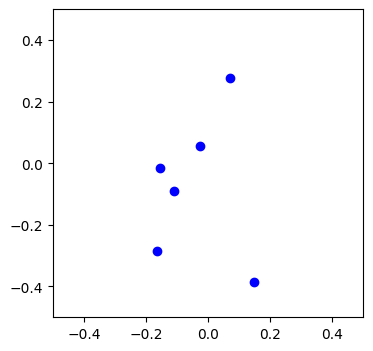

Loss = 0.791779
100


100%|█████████████████████████████████████████████| 7/7 [00:53<00:00,  7.63s/it]


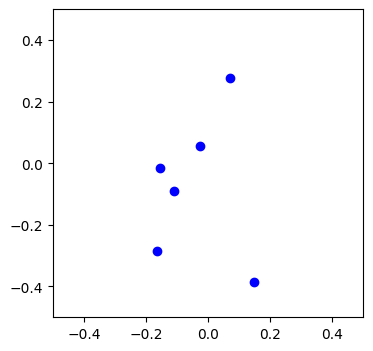

Loss = 0.793531
101


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.76s/it]


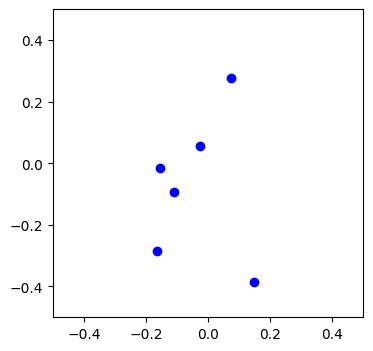

Loss = 0.793967
102


100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.10s/it]


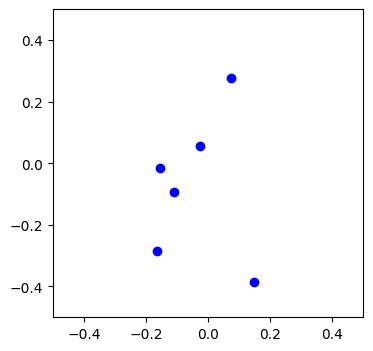

Loss = 0.794144
103


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.78s/it]


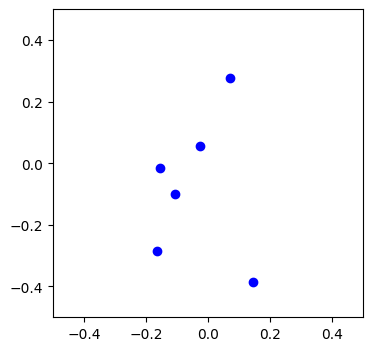

Loss = 0.799839
104


100%|█████████████████████████████████████████████| 7/7 [00:45<00:00,  6.56s/it]


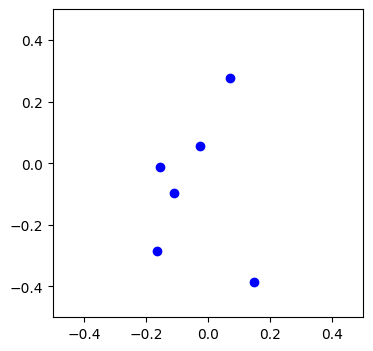

Loss = 0.796297
105


100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.13s/it]


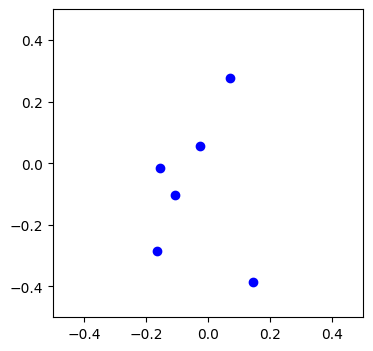

Loss = 0.802009
106


100%|█████████████████████████████████████████████| 7/7 [00:52<00:00,  7.57s/it]


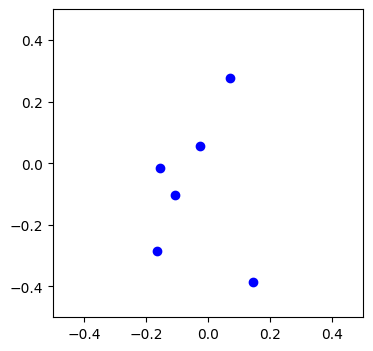

Loss = 0.792546
107


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.25s/it]


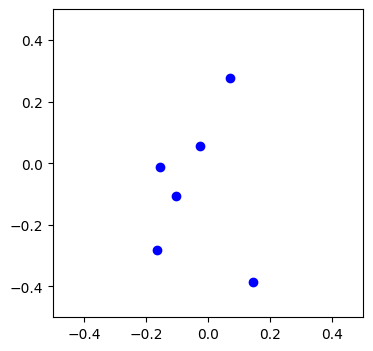

Loss = 0.794731
108


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.87s/it]


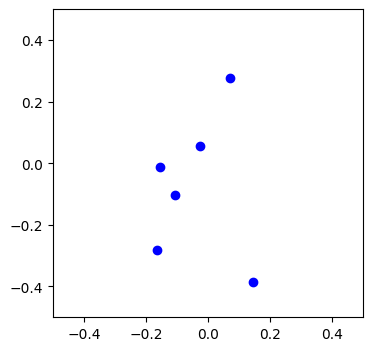

Loss = 0.791163
109


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.21s/it]


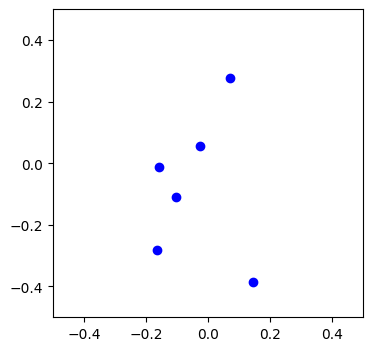

Loss = 0.806506
110


100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.09s/it]


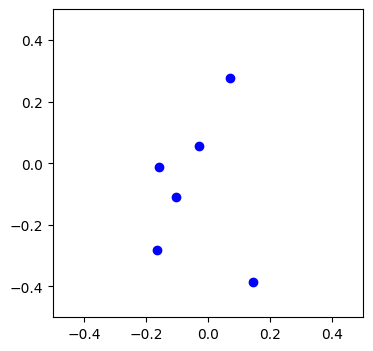

Loss = 0.797448
111


100%|█████████████████████████████████████████████| 7/7 [00:52<00:00,  7.50s/it]


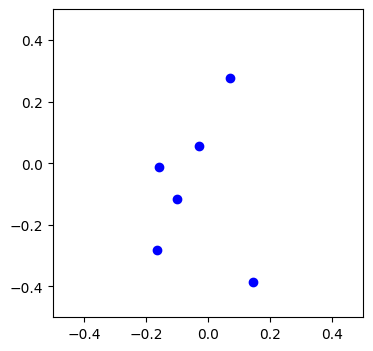

Loss = 0.809003
112


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.95s/it]


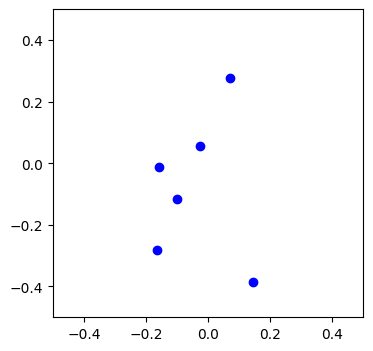

Loss = 0.812044
113


100%|█████████████████████████████████████████████| 7/7 [00:51<00:00,  7.29s/it]


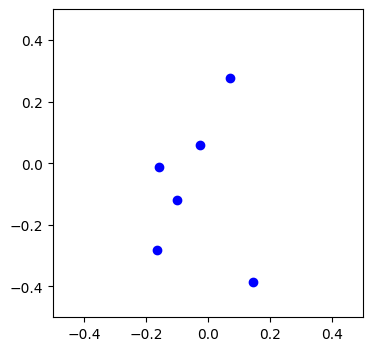

Loss = 0.815408
114


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.16s/it]


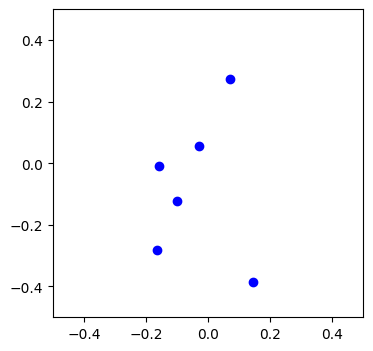

Loss = 0.814359
115


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.81s/it]


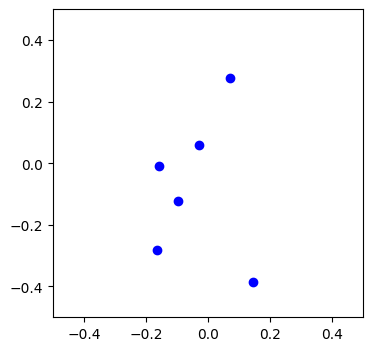

Loss = 0.806770
116


100%|█████████████████████████████████████████████| 7/7 [00:51<00:00,  7.29s/it]


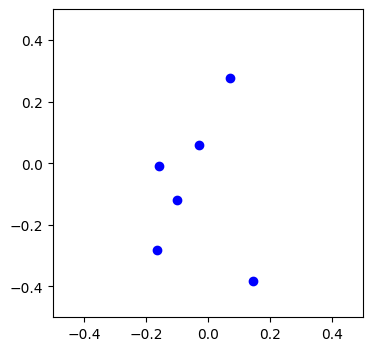

Loss = 0.814413
117


100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.11s/it]


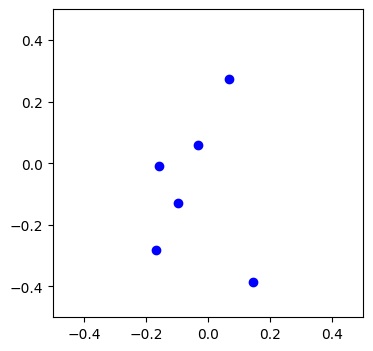

Loss = 0.822086
118


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.85s/it]


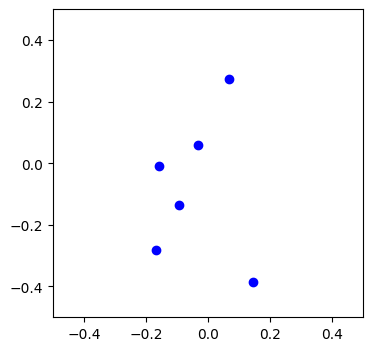

Loss = 0.825045
119


100%|█████████████████████████████████████████████| 7/7 [00:45<00:00,  6.55s/it]


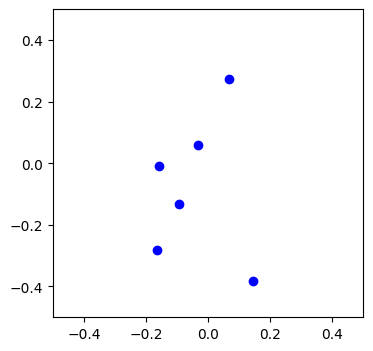

Loss = 0.824752
120


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.76s/it]


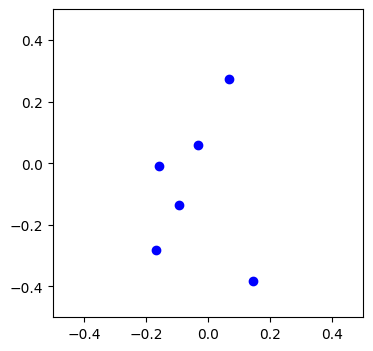

Loss = 0.823702
121


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.26s/it]


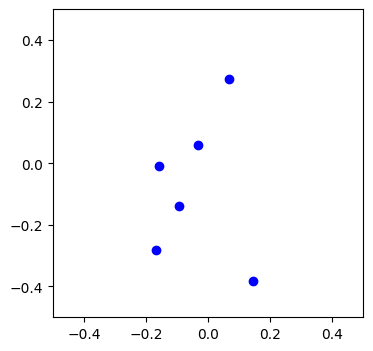

Loss = 0.827949
122


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.22s/it]


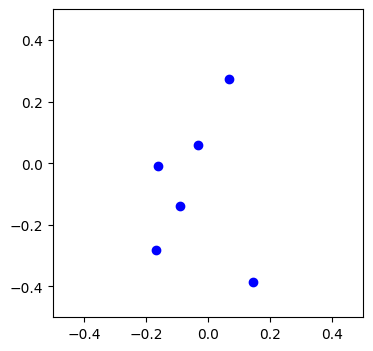

Loss = 0.828510
123


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.19s/it]


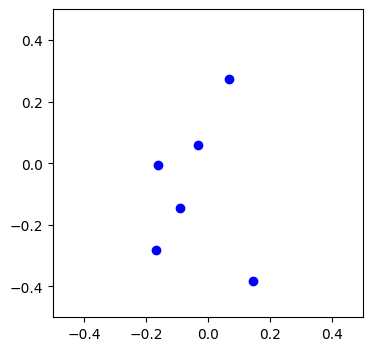

Loss = 0.833702
124


100%|█████████████████████████████████████████████| 7/7 [00:51<00:00,  7.37s/it]


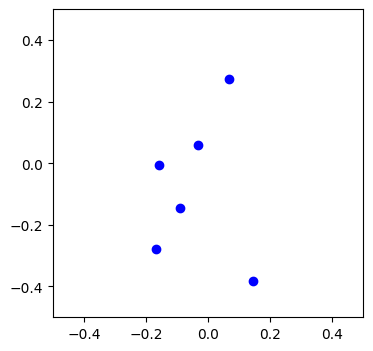

Loss = 0.834407
125


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.97s/it]


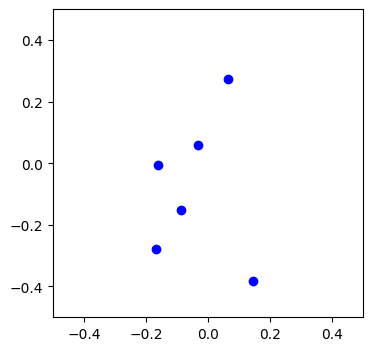

Loss = 0.837638
126


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.24s/it]


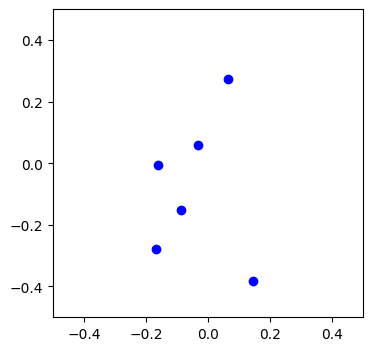

Loss = 0.837866
127


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.76s/it]


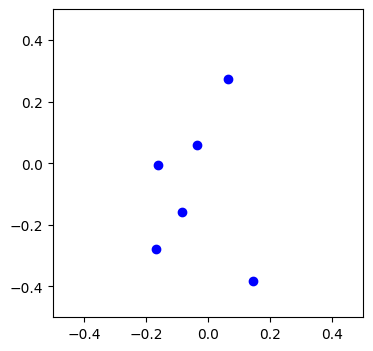

Loss = 0.851860
128


100%|█████████████████████████████████████████████| 7/7 [00:46<00:00,  6.66s/it]


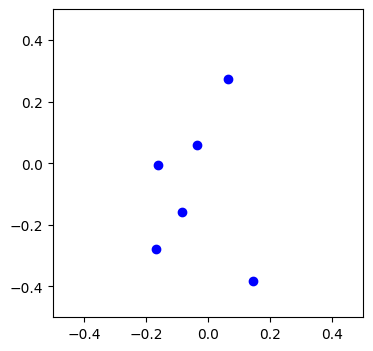

Loss = 0.842139
129


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.95s/it]


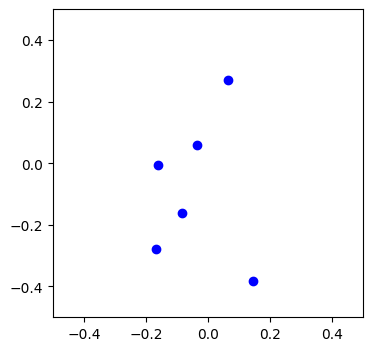

Loss = 0.857046
130


100%|█████████████████████████████████████████████| 7/7 [00:46<00:00,  6.70s/it]


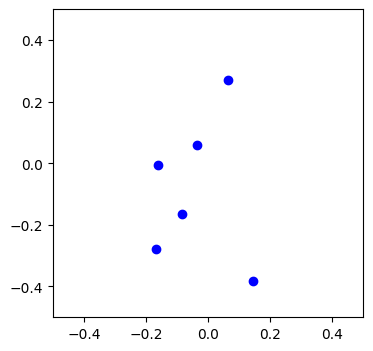

Loss = 0.841330
131


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.88s/it]


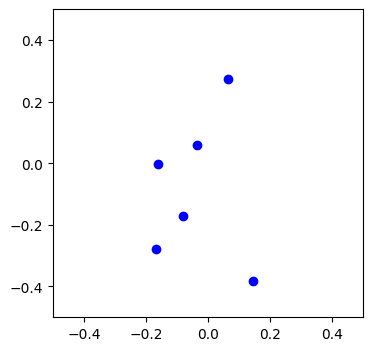

Loss = 0.855450
132


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.78s/it]


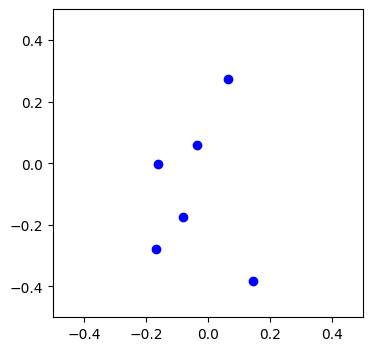

Loss = 0.860589
133


100%|█████████████████████████████████████████████| 7/7 [00:46<00:00,  6.70s/it]


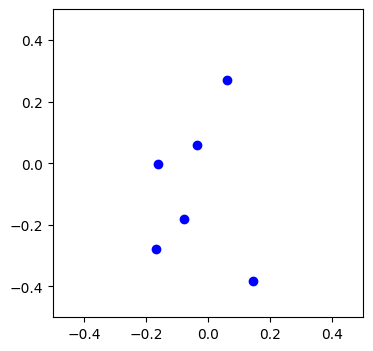

Loss = 0.865542
134


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.89s/it]


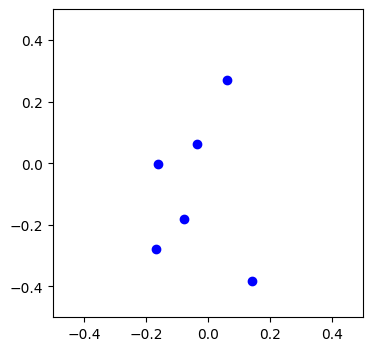

Loss = 0.863314
135


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.81s/it]


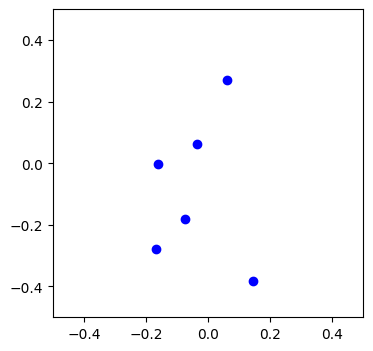

Loss = 0.865876
136


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.83s/it]


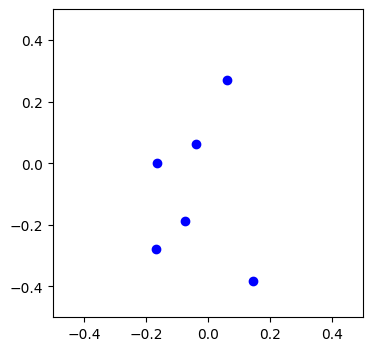

Loss = 0.870973
137


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.79s/it]


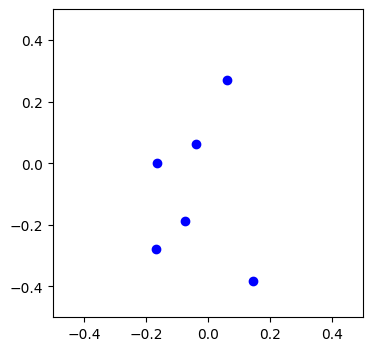

Loss = 0.869535
138


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.95s/it]


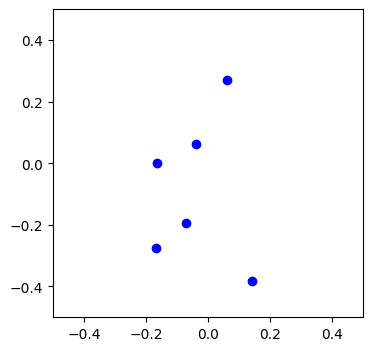

Loss = 0.876375
139


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.77s/it]


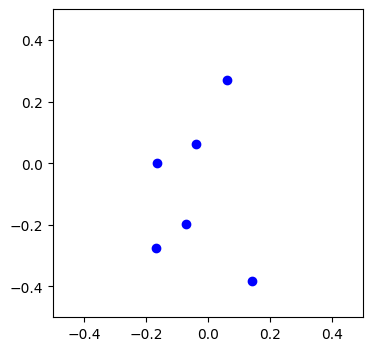

Loss = 0.871942
140


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.90s/it]


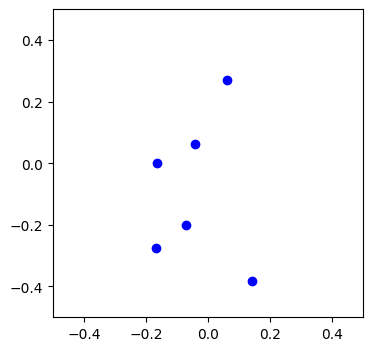

Loss = 0.882680
141


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.27s/it]


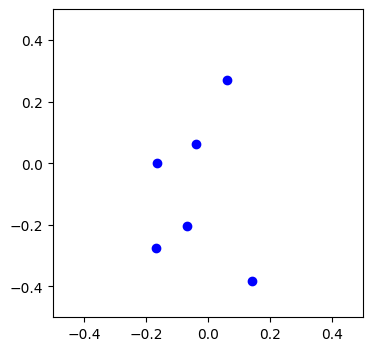

Loss = 0.885666
142


100%|█████████████████████████████████████████████| 7/7 [00:51<00:00,  7.29s/it]


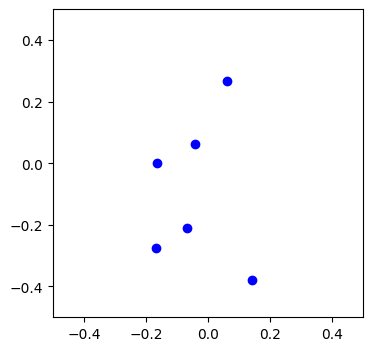

Loss = 0.893281
143


100%|█████████████████████████████████████████████| 7/7 [00:53<00:00,  7.58s/it]


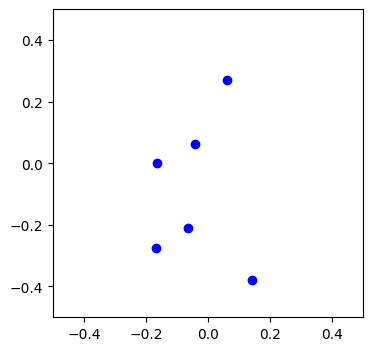

Loss = 0.891140
144


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.83s/it]


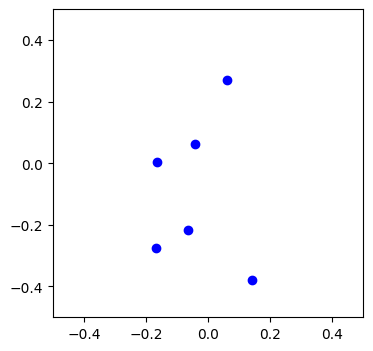

Loss = 0.898168
145


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.25s/it]


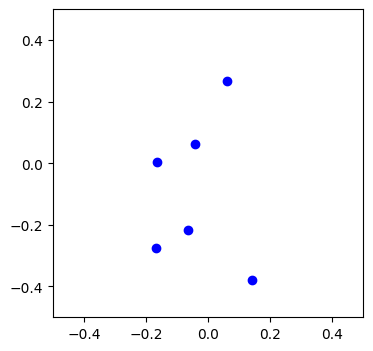

Loss = 0.890543
146


100%|█████████████████████████████████████████████| 7/7 [00:52<00:00,  7.48s/it]


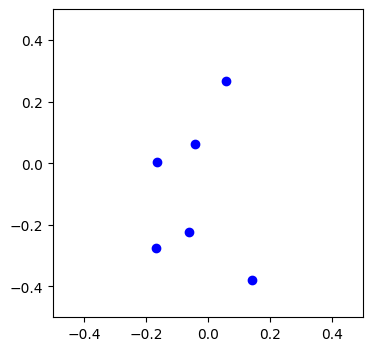

Loss = 0.896650
147


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.19s/it]


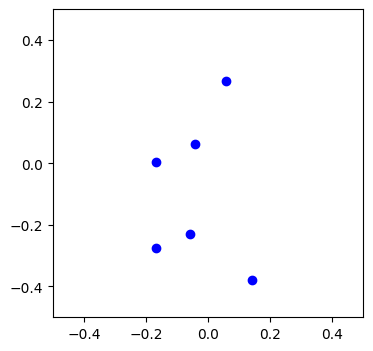

Loss = 0.902107
148


100%|█████████████████████████████████████████████| 7/7 [00:54<00:00,  7.85s/it]


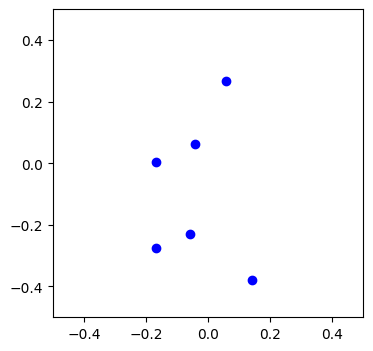

Loss = 0.904013
149


100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.10s/it]


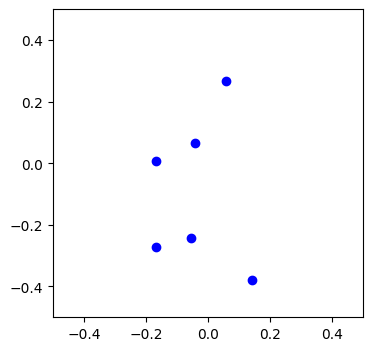

Loss = 0.915967
150


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.99s/it]


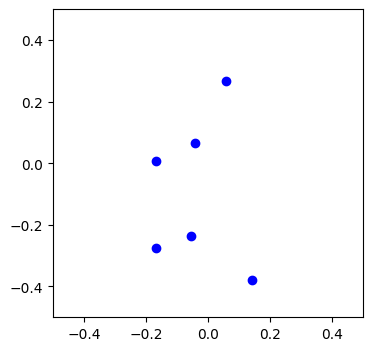

Loss = 0.908525
151


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.94s/it]


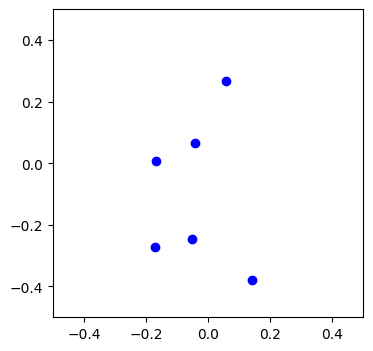

Loss = 0.913998
152


100%|█████████████████████████████████████████████| 7/7 [00:54<00:00,  7.79s/it]


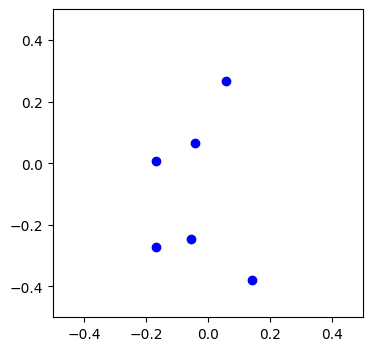

Loss = 0.919945
153


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.94s/it]


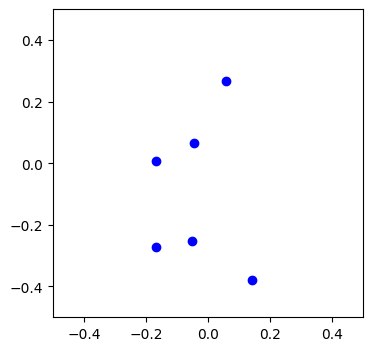

Loss = 0.918995
154


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.85s/it]


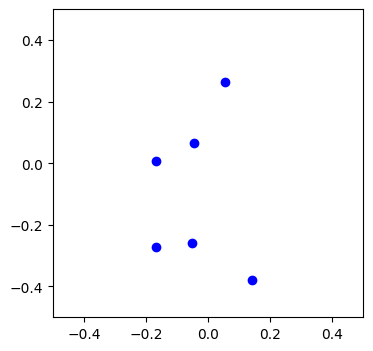

Loss = 0.926101
155


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.99s/it]


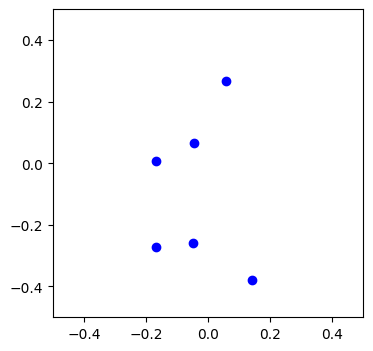

Loss = 0.933673
156


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.91s/it]


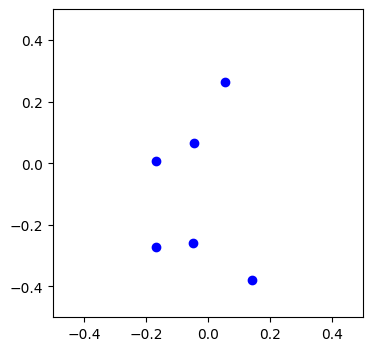

Loss = 0.925424
157


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.75s/it]


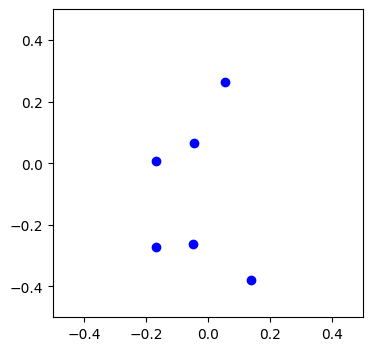

Loss = 0.930607
158


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.87s/it]


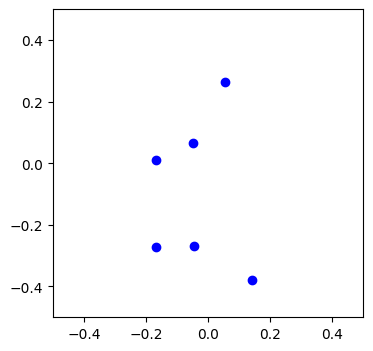

Loss = 0.937300
159


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.87s/it]


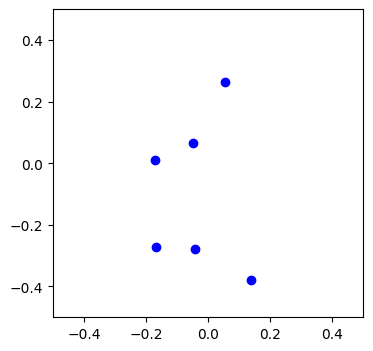

Loss = 0.946666
160


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.79s/it]


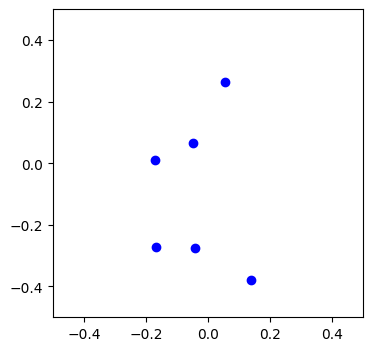

Loss = 0.943835
161


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.82s/it]


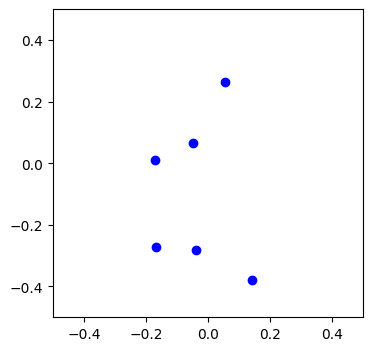

Loss = 0.943841
162


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.93s/it]


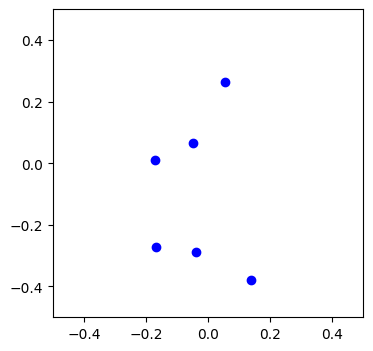

Loss = 0.958575
163


100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.05s/it]


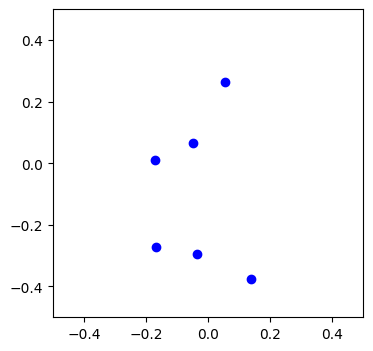

Loss = 0.957927
164


100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.00s/it]


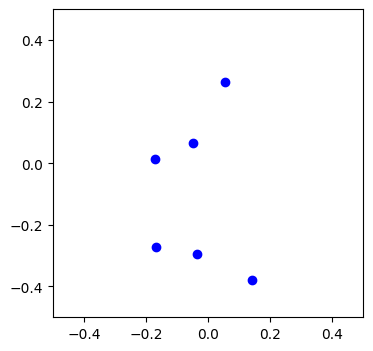

Loss = 0.956035
165


100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.07s/it]


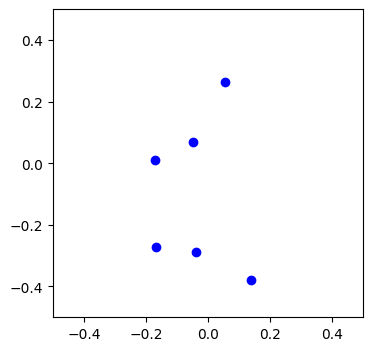

Loss = 0.950722
166


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.74s/it]


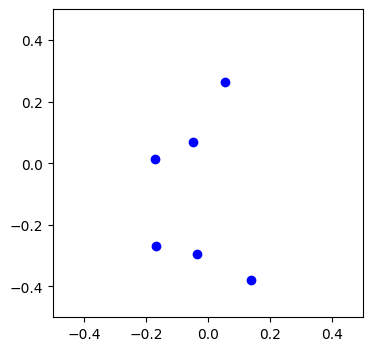

Loss = 0.947751
167


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.77s/it]


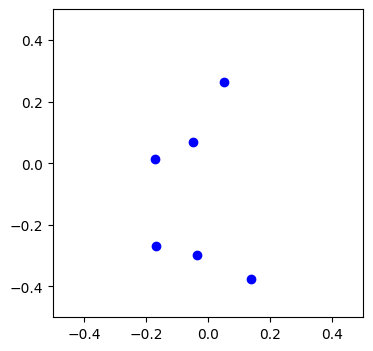

Loss = 0.961158
168


100%|█████████████████████████████████████████████| 7/7 [00:50<00:00,  7.28s/it]


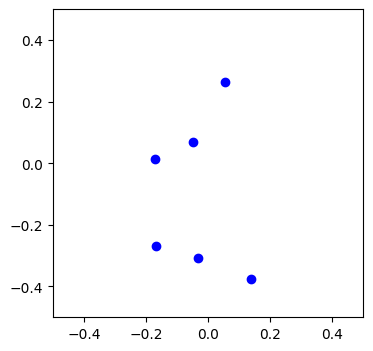

Loss = 0.974074
169


100%|█████████████████████████████████████████████| 7/7 [00:48<00:00,  6.89s/it]


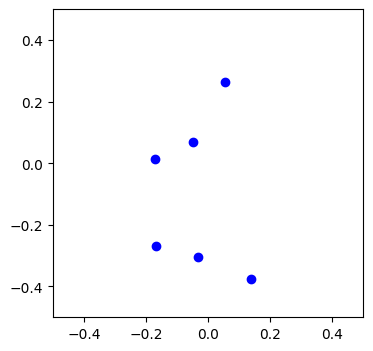

Loss = 0.963716
170


100%|█████████████████████████████████████████████| 7/7 [00:47<00:00,  6.73s/it]


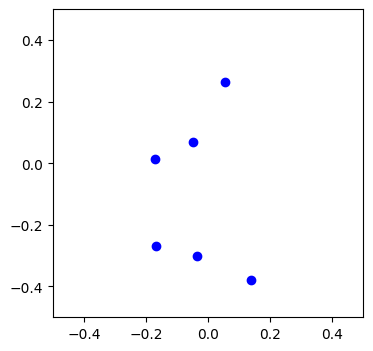

Loss = 0.956758
171


100%|█████████████████████████████████████████████| 7/7 [00:44<00:00,  6.38s/it]


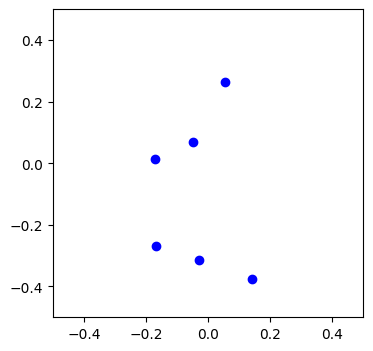

Loss = 0.979556
172


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.12s/it]


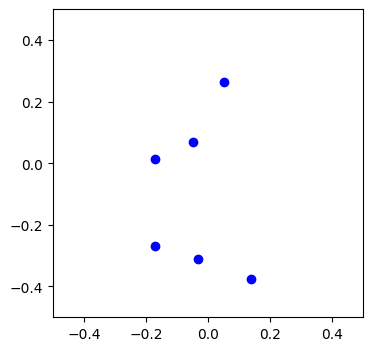

Loss = 0.978769
173


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.18s/it]


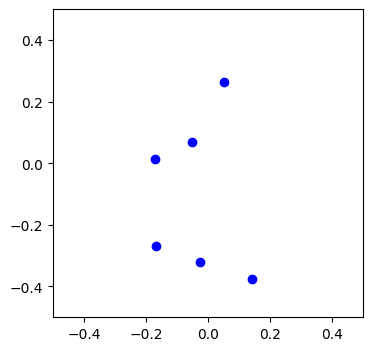

Loss = 0.989250
174


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


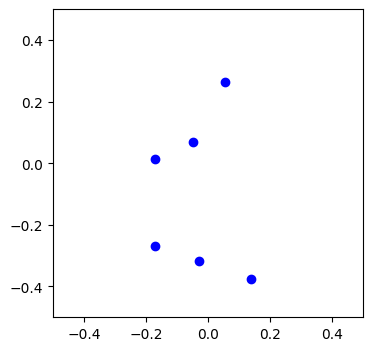

Loss = 0.987350
175


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.14s/it]


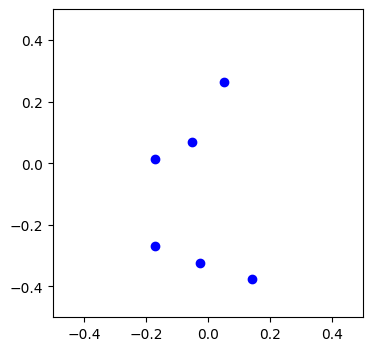

Loss = 0.995020
176


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.09s/it]


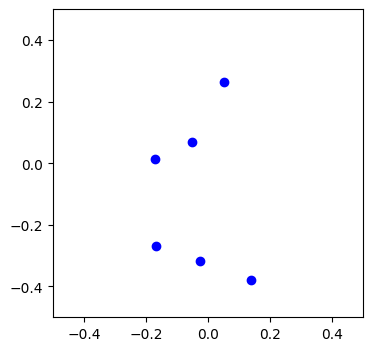

Loss = 0.979099
177


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.15s/it]


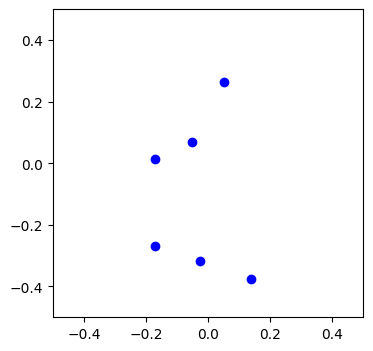

Loss = 0.979361
178


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.09s/it]


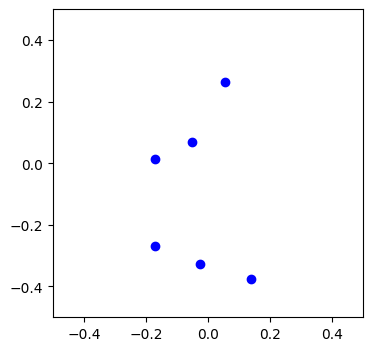

Loss = 0.988732
179


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.18s/it]


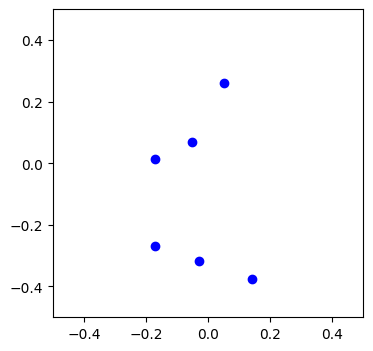

Loss = 0.979077
180


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.09s/it]


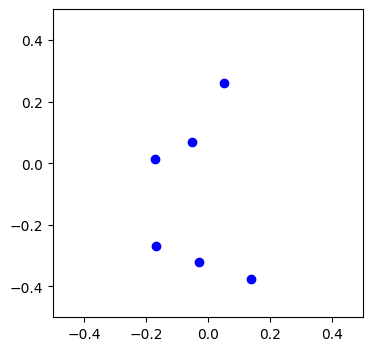

Loss = 0.979800
181


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.09s/it]


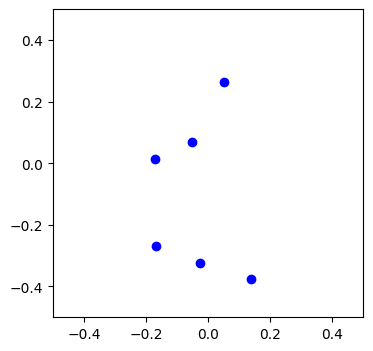

Loss = 0.986625
182


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.05s/it]


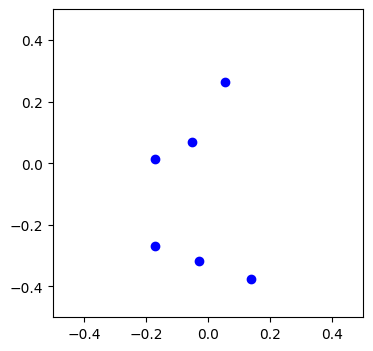

Loss = 0.980484
183


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.21s/it]


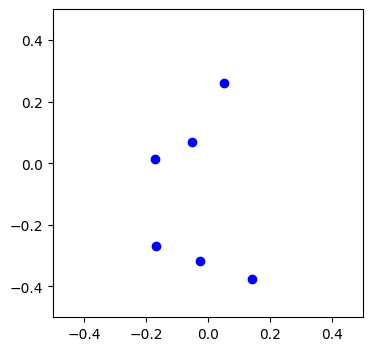

Loss = 0.979440
184


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


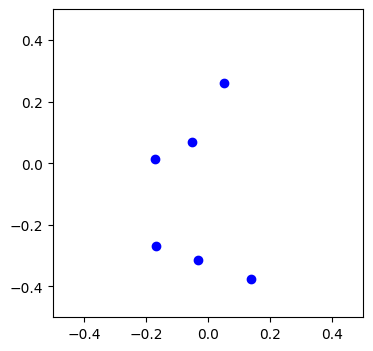

Loss = 0.963530
185


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.13s/it]


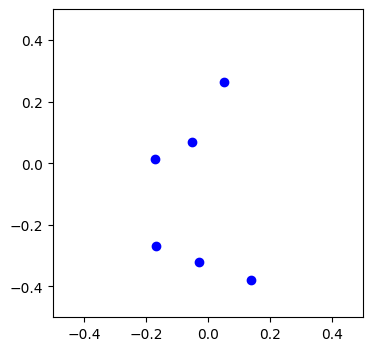

Loss = 0.982085
186


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.21s/it]


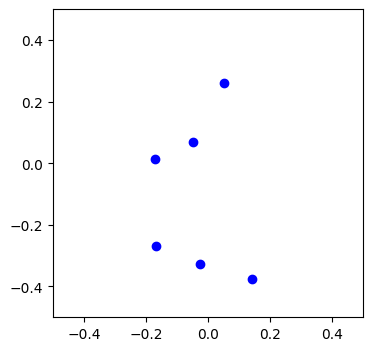

Loss = 0.987437
187


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.14s/it]


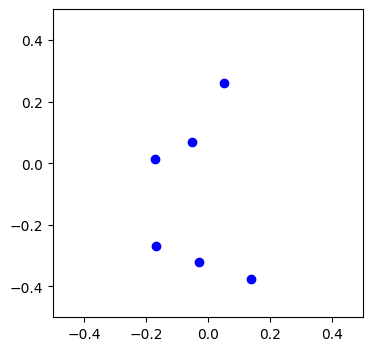

Loss = 0.971965
188


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


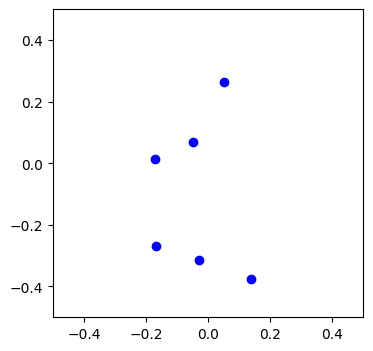

Loss = 0.971900
189


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


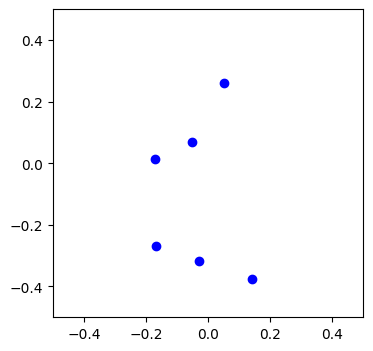

Loss = 0.980288
190


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.17s/it]


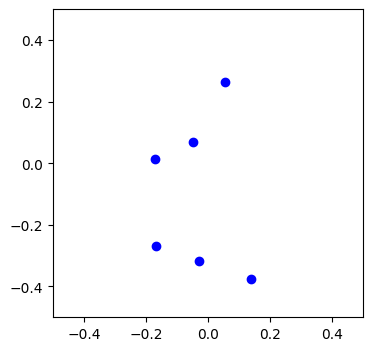

Loss = 0.971671
191


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.04s/it]


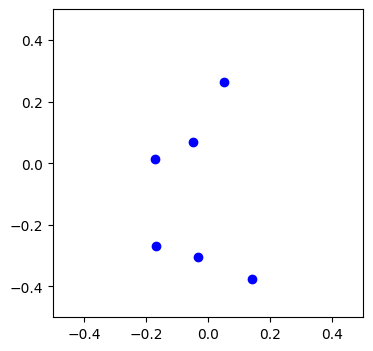

Loss = 0.953196
192


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.15s/it]


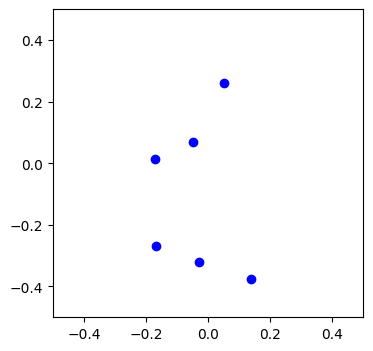

Loss = 0.979952
193


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.19s/it]


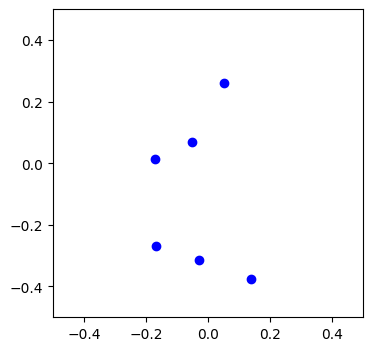

Loss = 0.973867
194


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


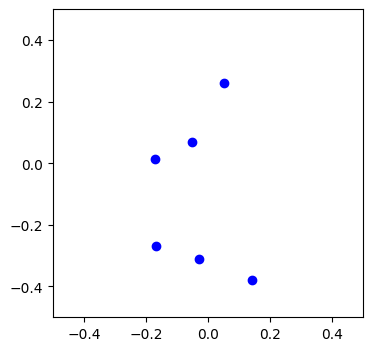

Loss = 0.962041
195


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.13s/it]


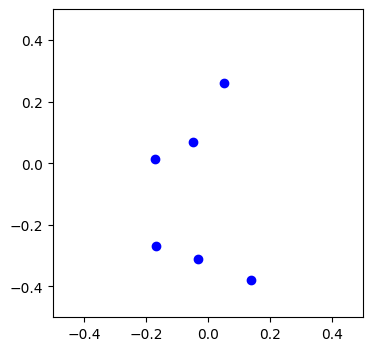

Loss = 0.971414
196


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


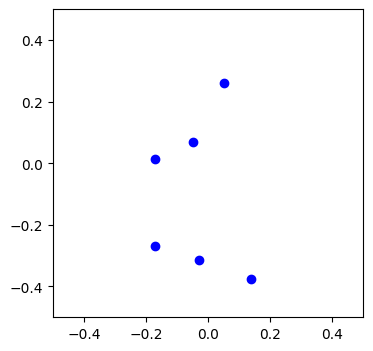

Loss = 0.972050
197


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.19s/it]


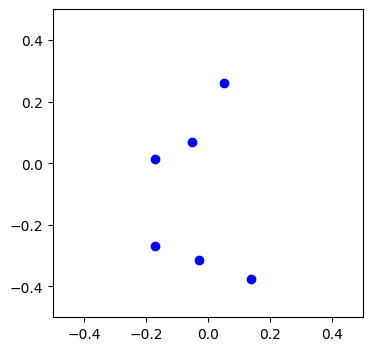

Loss = 0.974084
198


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.13s/it]


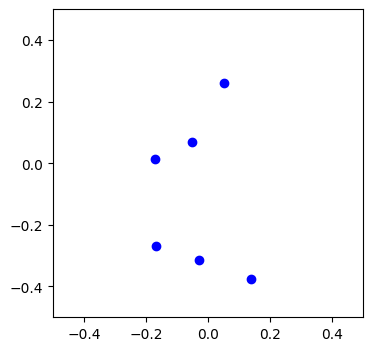

Loss = 0.973175
199


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.08s/it]


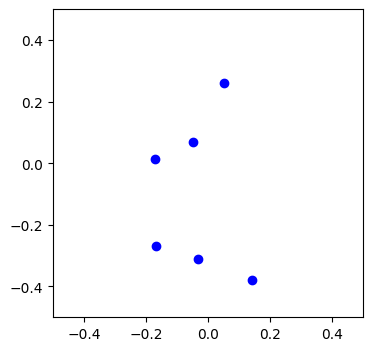

Loss = 0.970584
200


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.09s/it]


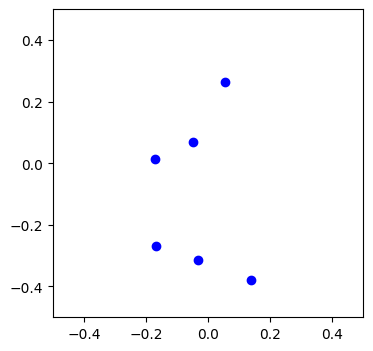

Loss = 0.973438
201


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.08s/it]


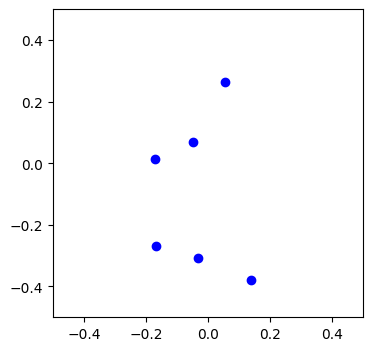

Loss = 0.964446
202


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.17s/it]


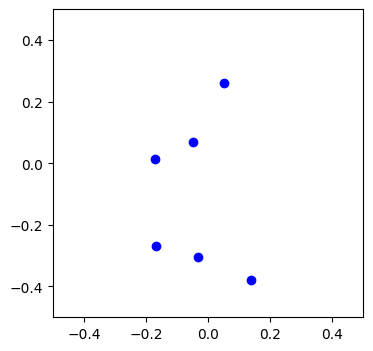

Loss = 0.963511
203


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.03s/it]


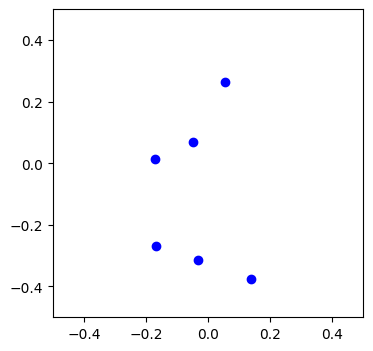

Loss = 0.972200
204


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.13s/it]


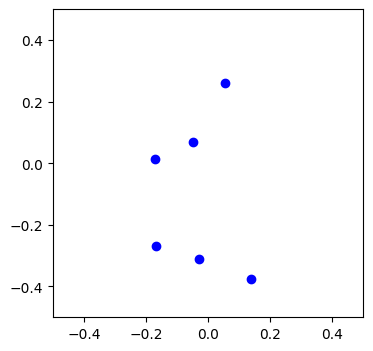

Loss = 0.971632
205


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.08s/it]


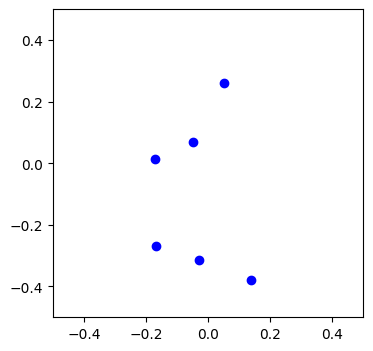

Loss = 0.973738
206


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.19s/it]


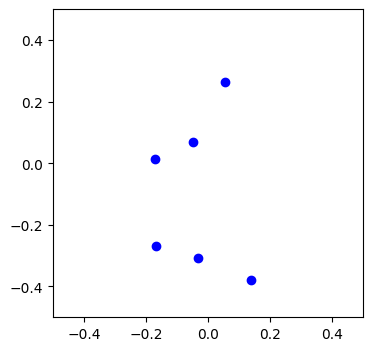

Loss = 0.962196
207


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.05s/it]


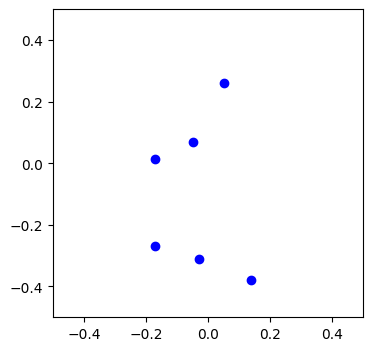

Loss = 0.971460
208


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.17s/it]


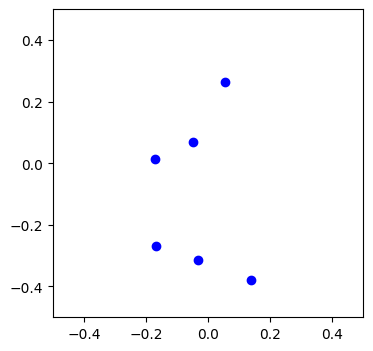

Loss = 0.971857
209


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.08s/it]


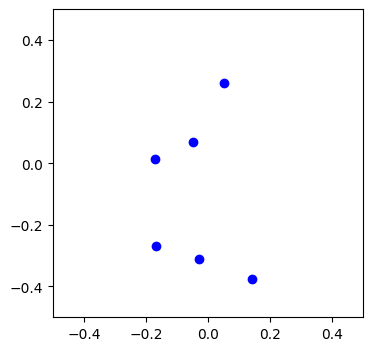

Loss = 0.970167
210


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.21s/it]


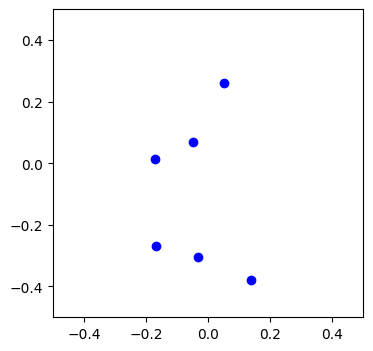

Loss = 0.971609
211


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.05s/it]


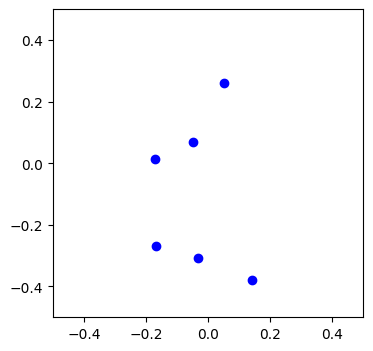

Loss = 0.971681
212


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.18s/it]


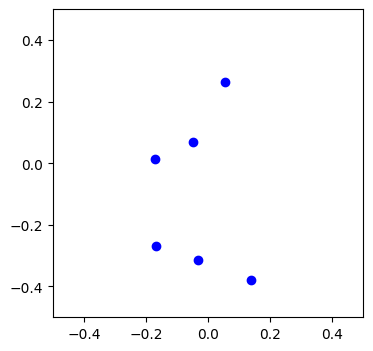

Loss = 0.979760
213


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.13s/it]


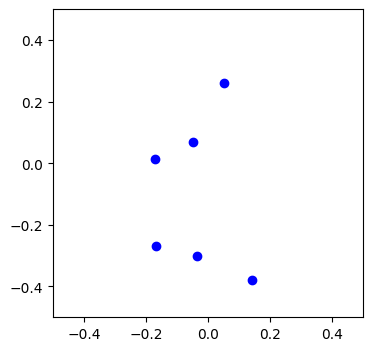

Loss = 0.955736
214


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.12s/it]


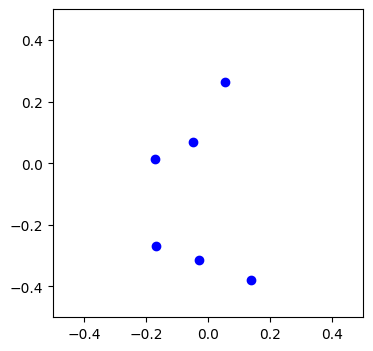

Loss = 0.978366
215


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.08s/it]


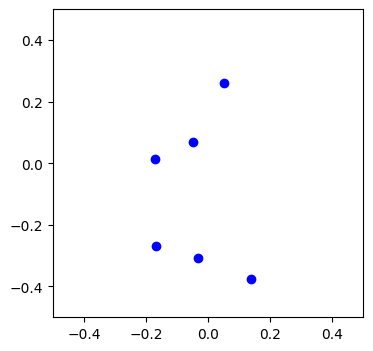

Loss = 0.975183
216


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


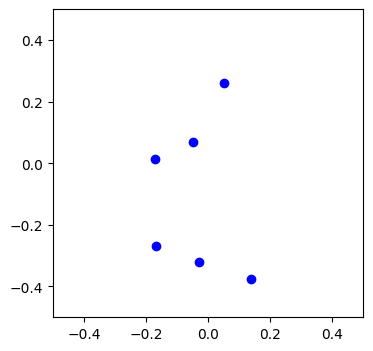

Loss = 0.981966
217


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.08s/it]


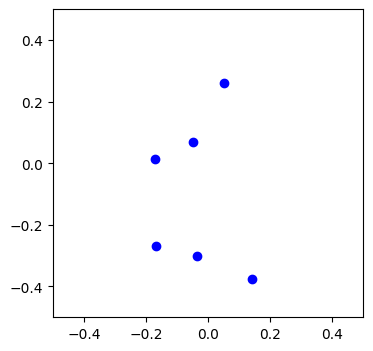

Loss = 0.956600
218


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.22s/it]


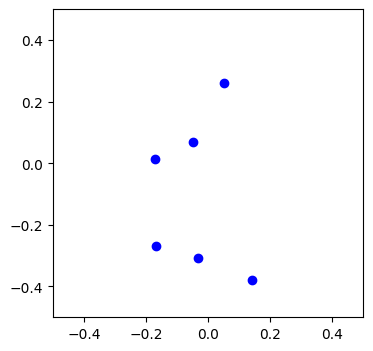

Loss = 0.965168
219


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


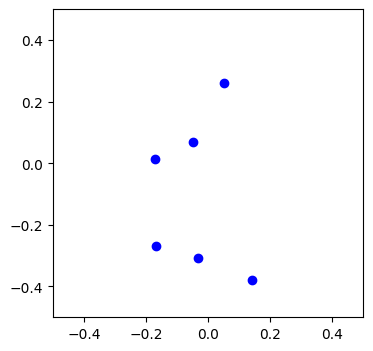

Loss = 0.962097
220


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.18s/it]


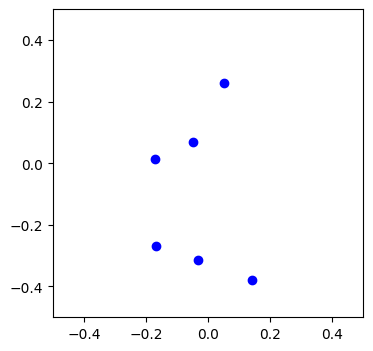

Loss = 0.973022
221


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.11s/it]


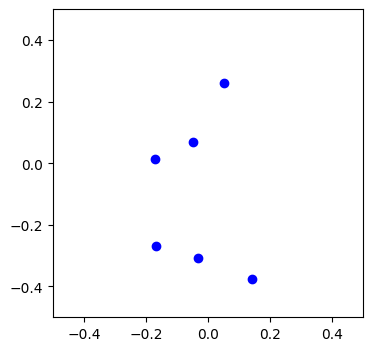

Loss = 0.964682
222


100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.30s/it]


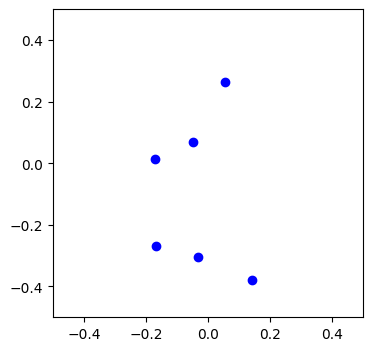

Loss = 0.963612
223


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.14s/it]


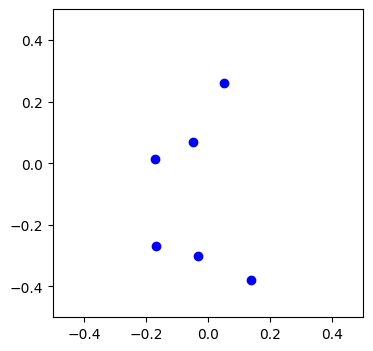

Loss = 0.959301
224


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.22s/it]


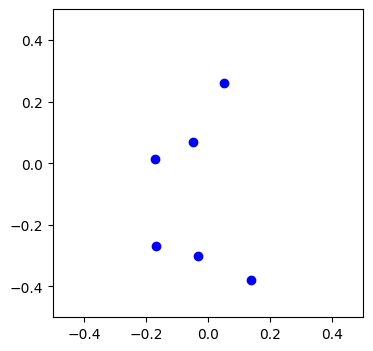

Loss = 0.955864
225


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.23s/it]


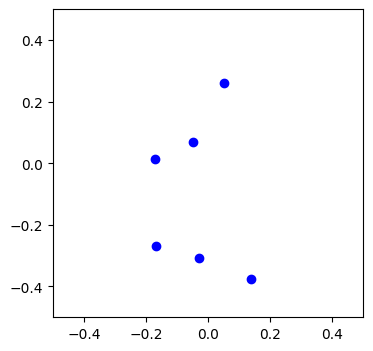

Loss = 0.966459
226


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.17s/it]


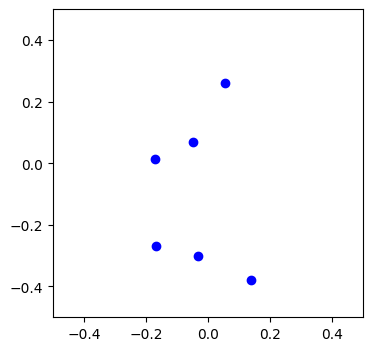

Loss = 0.958558
227


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


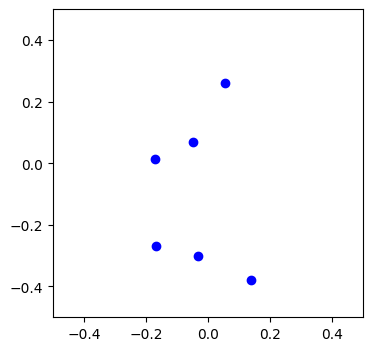

Loss = 0.958266
228


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.19s/it]


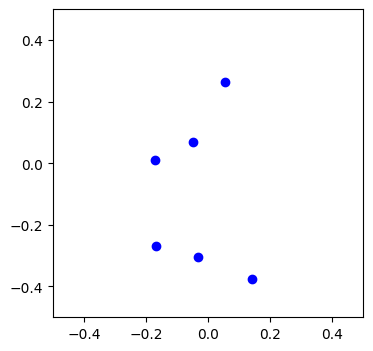

Loss = 0.962117
229


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.06s/it]


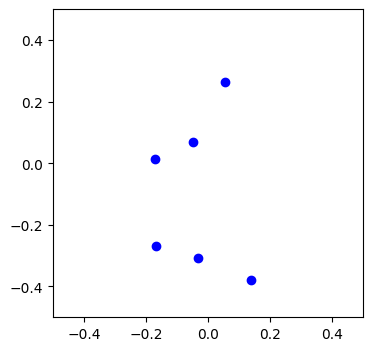

Loss = 0.963970
230


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.13s/it]


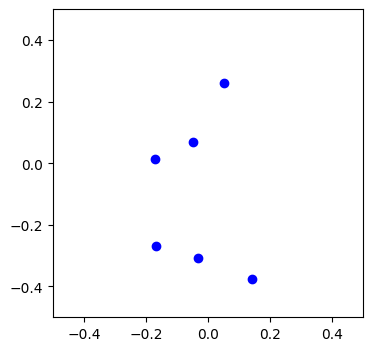

Loss = 0.964718
231


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


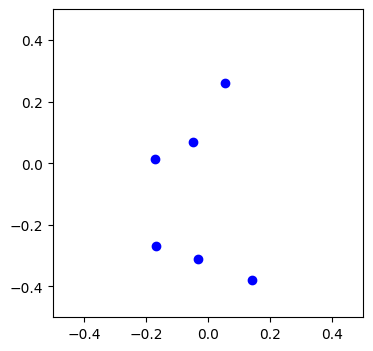

Loss = 0.978052
232


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.11s/it]


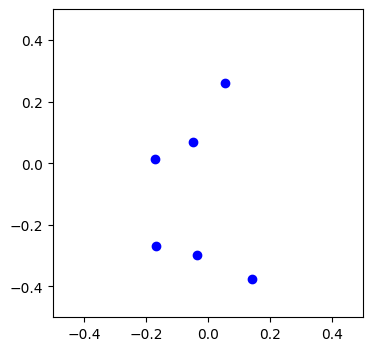

Loss = 0.961993
233


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.03s/it]


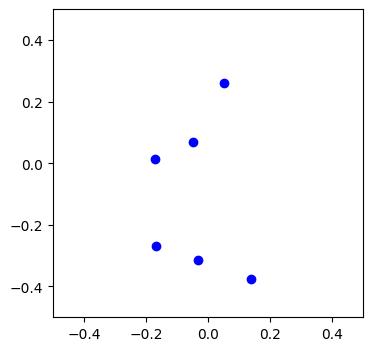

Loss = 0.981279
234


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.17s/it]


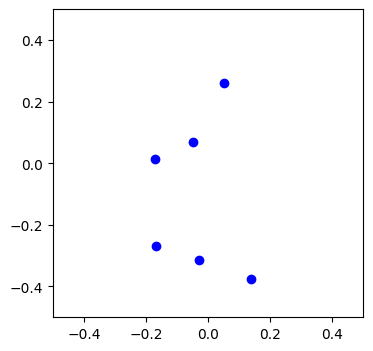

Loss = 0.980662
235


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.06s/it]


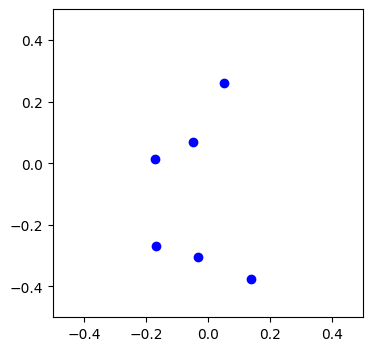

Loss = 0.962698
236


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.23s/it]


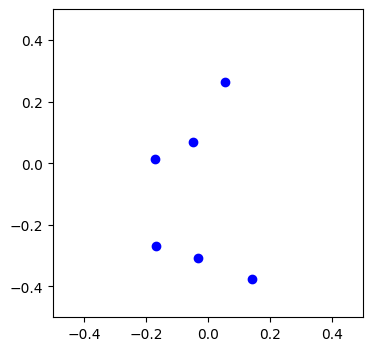

Loss = 0.970861
237


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.09s/it]


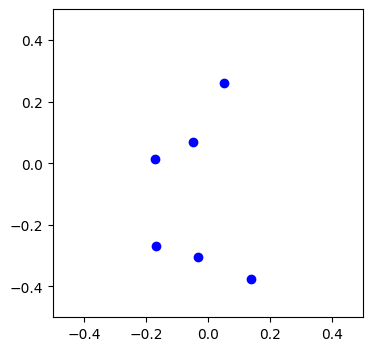

Loss = 0.965055
238


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.12s/it]


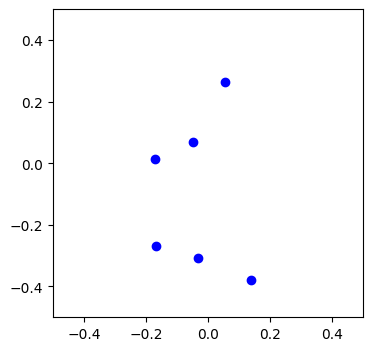

Loss = 0.962997
239


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.23s/it]


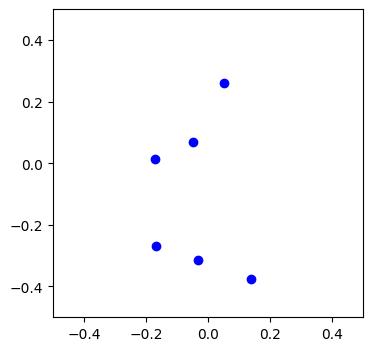

Loss = 0.972582
240


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.11s/it]


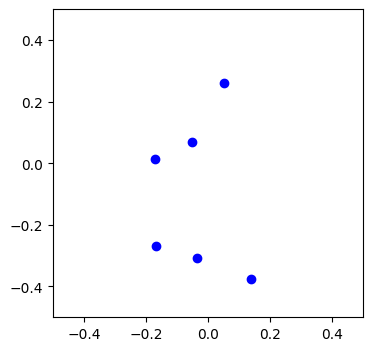

Loss = 0.964983
241


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


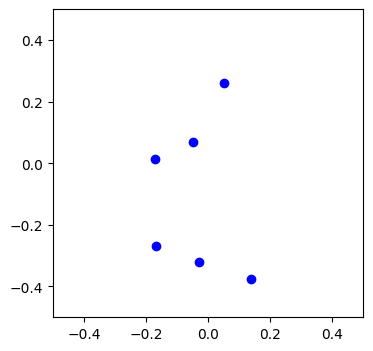

Loss = 0.989636
242


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.19s/it]


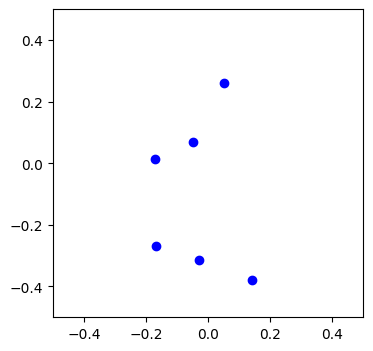

Loss = 0.971699
243


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.09s/it]


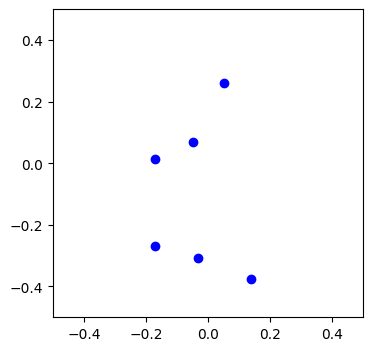

Loss = 0.964976
244


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.11s/it]


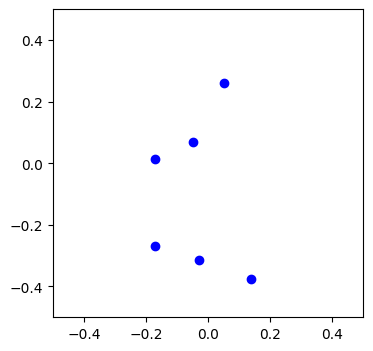

Loss = 0.974733
245


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.14s/it]


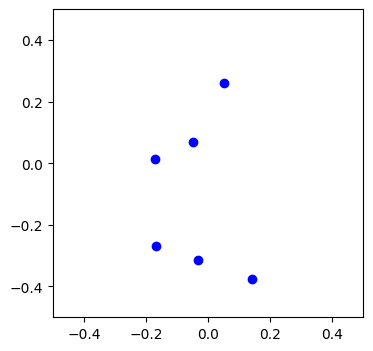

Loss = 0.973359
246


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


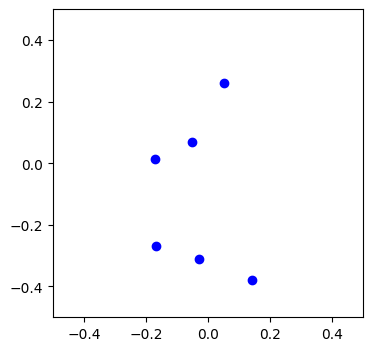

Loss = 0.972143
247


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.17s/it]


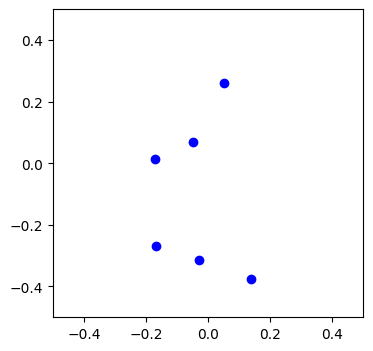

Loss = 0.971846
248


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.16s/it]


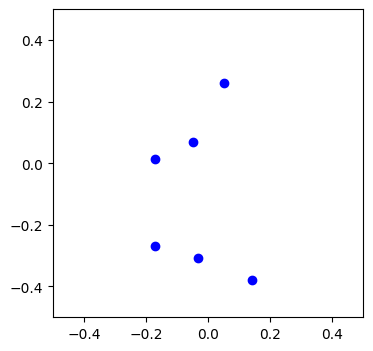

Loss = 0.964720
249


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


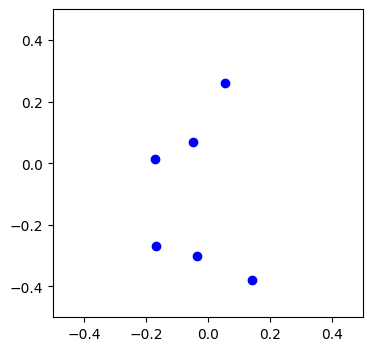

Loss = 0.956316
250


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


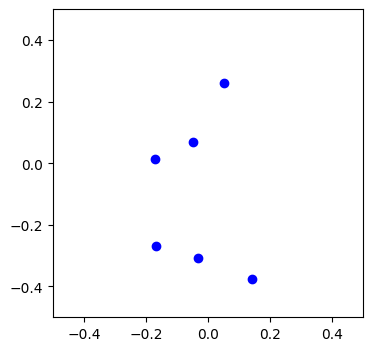

Loss = 0.964154
251


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


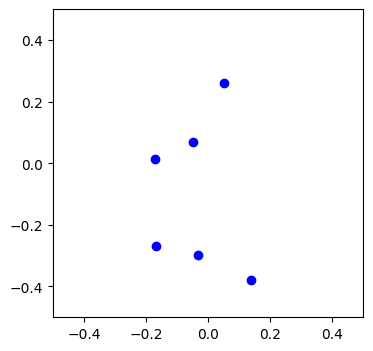

Loss = 0.955203
252


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.04s/it]


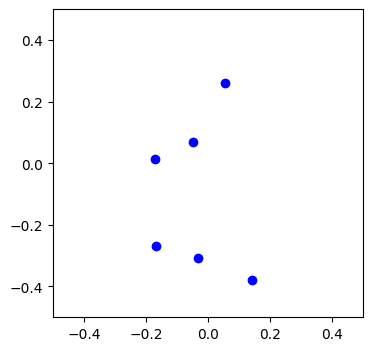

Loss = 0.963463
253


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.13s/it]


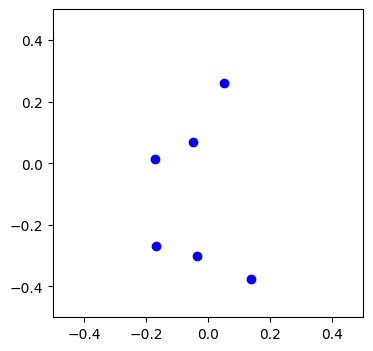

Loss = 0.954833
254


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.09s/it]


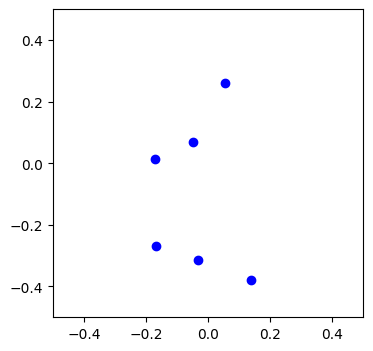

Loss = 0.971958
255


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.21s/it]


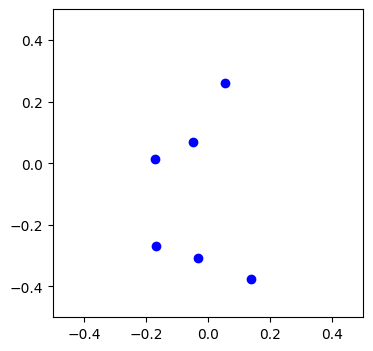

Loss = 0.966381
256


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.06s/it]


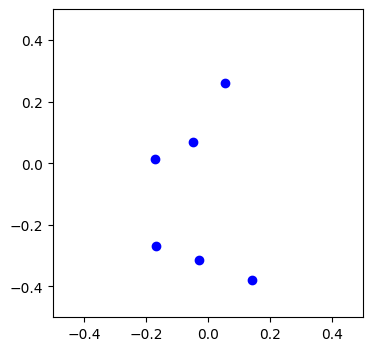

Loss = 0.982068
257


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.15s/it]


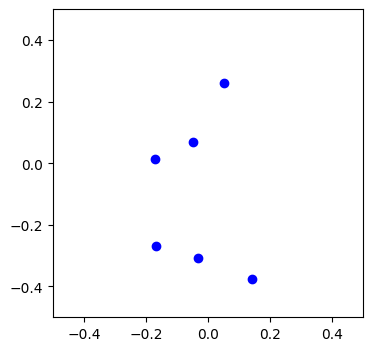

Loss = 0.965287
258


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.15s/it]


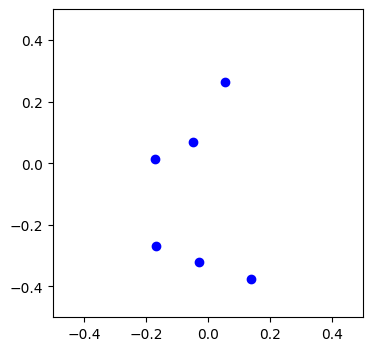

Loss = 0.990248
259


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.14s/it]


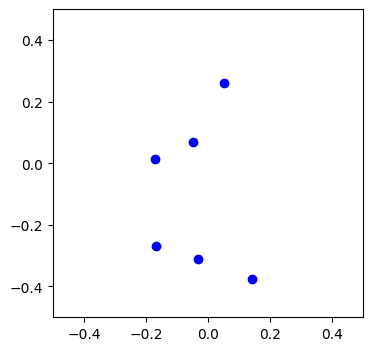

Loss = 0.971211
260


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.05s/it]


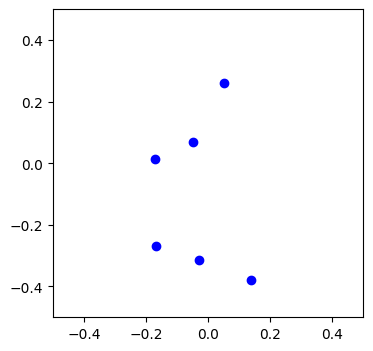

Loss = 0.981820
261


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.11s/it]


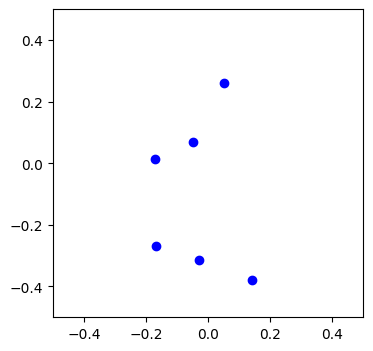

Loss = 0.972409
262


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


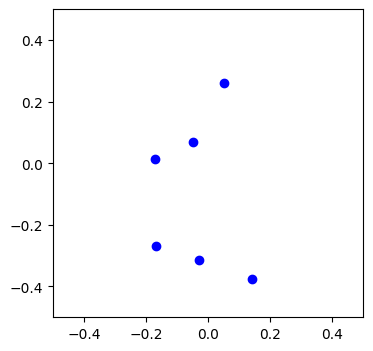

Loss = 0.971965
263


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.22s/it]


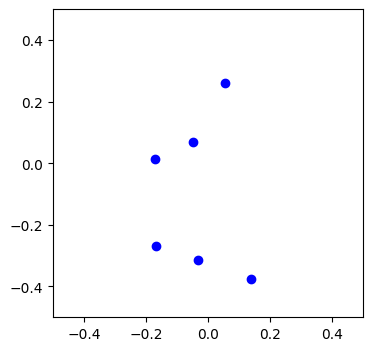

Loss = 0.981249
264


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.08s/it]


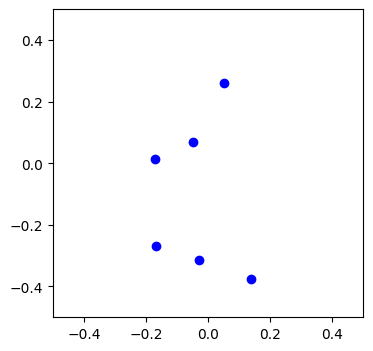

Loss = 0.974788
265


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.20s/it]


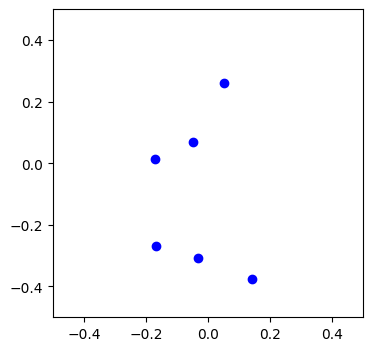

Loss = 0.965077
266


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.14s/it]


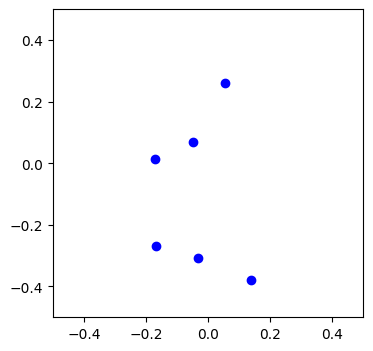

Loss = 0.965690
267


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.15s/it]


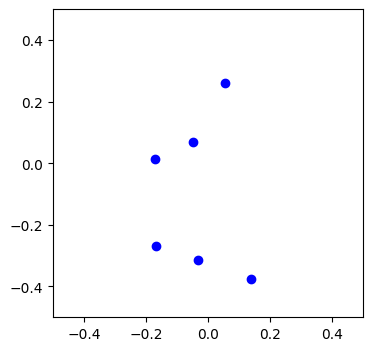

Loss = 0.965953
268


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


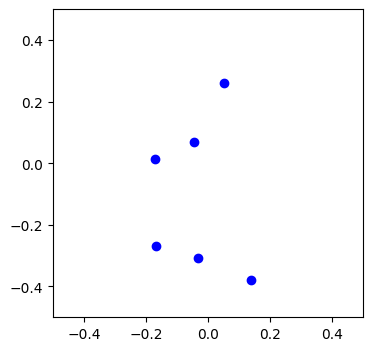

Loss = 0.965643
269


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.11s/it]


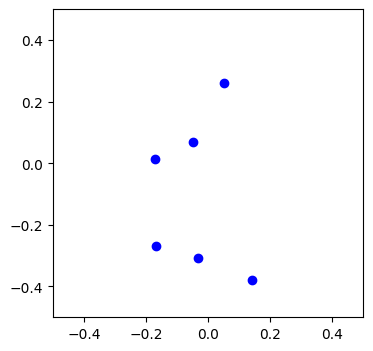

Loss = 0.963536
270


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.14s/it]


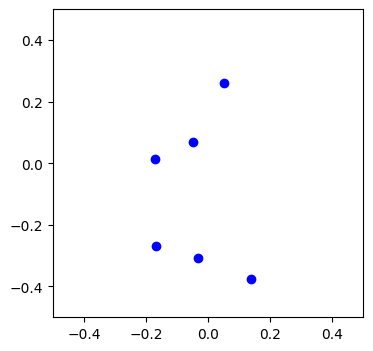

Loss = 0.965028
271


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.16s/it]


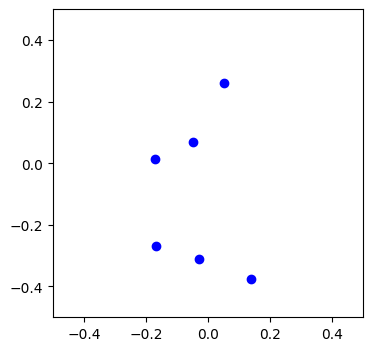

Loss = 0.973477
272


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


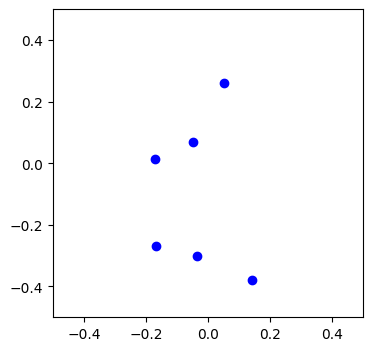

Loss = 0.955614
273


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.13s/it]


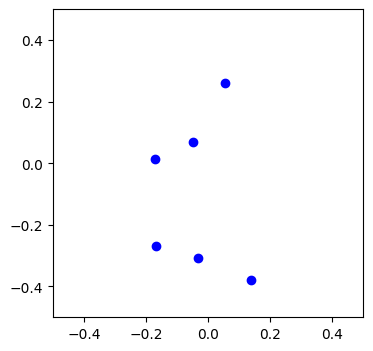

Loss = 0.957358
274


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.12s/it]


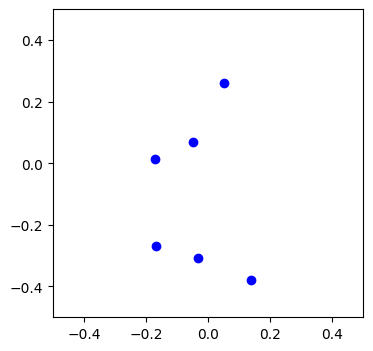

Loss = 0.965040
275


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.14s/it]


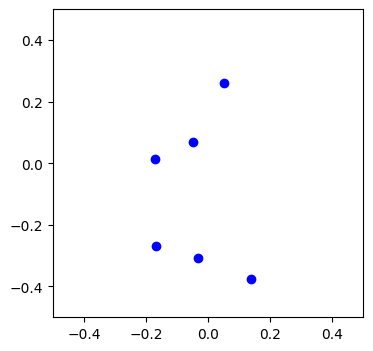

Loss = 0.967147
276


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.05s/it]


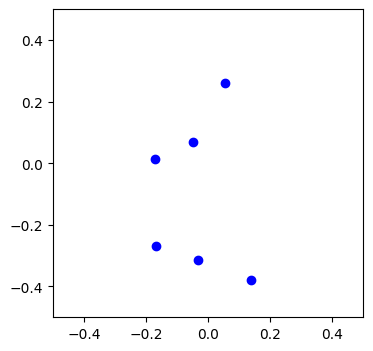

Loss = 0.972259
277


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.08s/it]


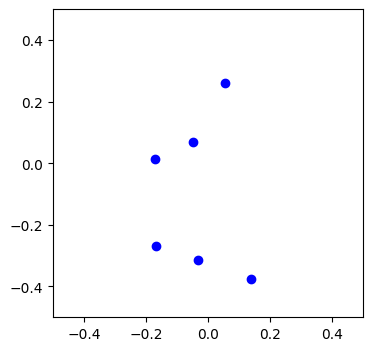

Loss = 0.973192
278


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.20s/it]


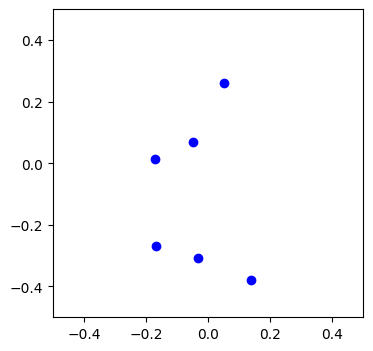

Loss = 0.963424
279


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


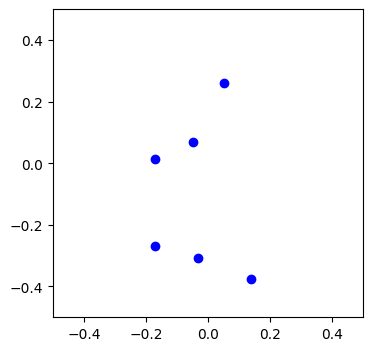

Loss = 0.965580
280


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


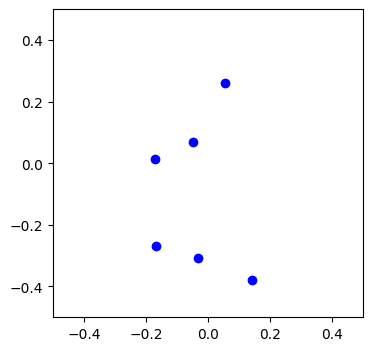

Loss = 0.963565
281


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.09s/it]


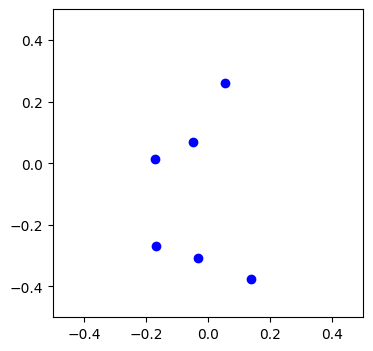

Loss = 0.964973
282


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.11s/it]


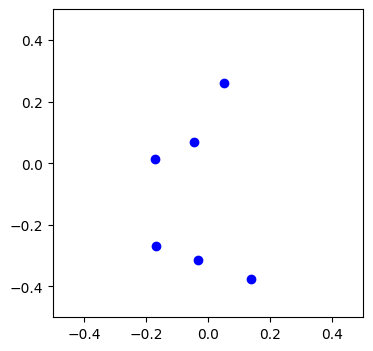

Loss = 0.983203
283


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.05s/it]


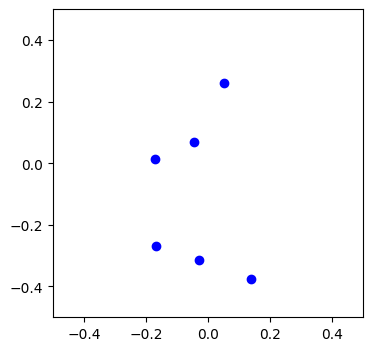

Loss = 0.969632
284


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


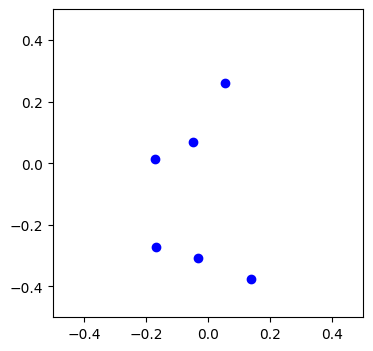

Loss = 0.965151
285


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


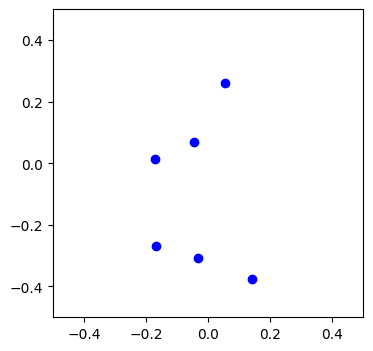

Loss = 0.964899
286


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.16s/it]


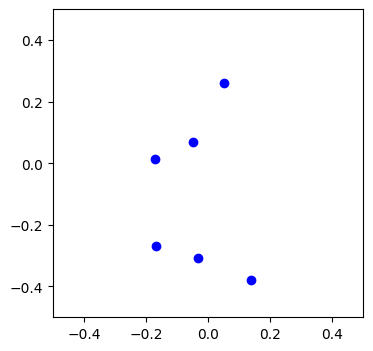

Loss = 0.967384
287


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.08s/it]


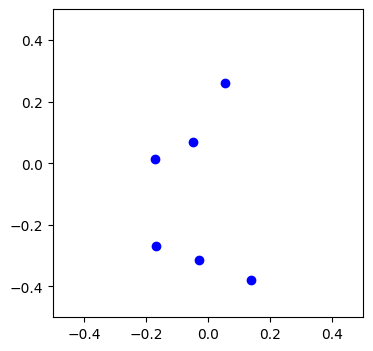

Loss = 0.971124
288


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.04s/it]


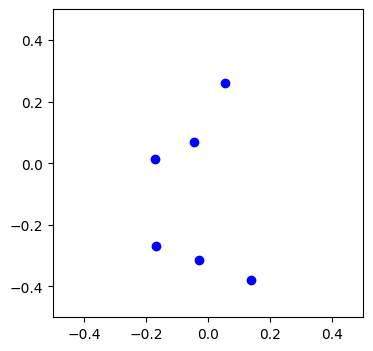

Loss = 0.973072
289


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


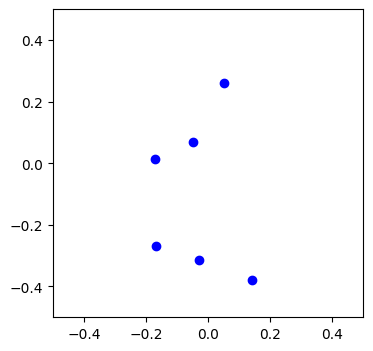

Loss = 0.981821
290


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.05s/it]


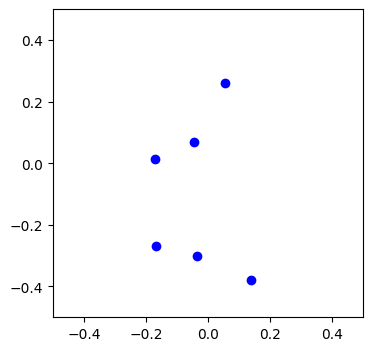

Loss = 0.956620
291


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.04s/it]


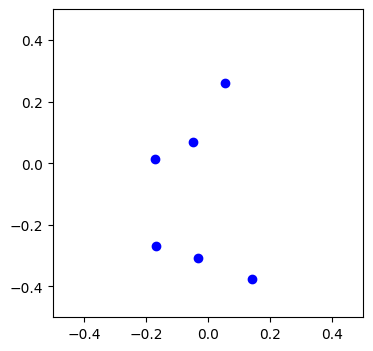

Loss = 0.965095
292


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.14s/it]


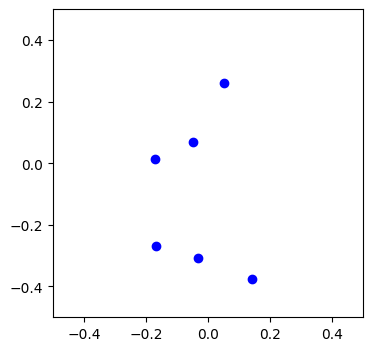

Loss = 0.963460
293


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.11s/it]


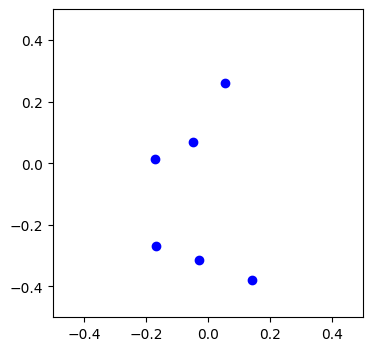

Loss = 0.975036
294


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.13s/it]


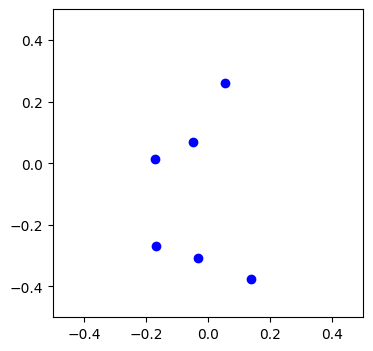

Loss = 0.966801
295


100%|█████████████████████████████████████████████| 7/7 [00:36<00:00,  5.16s/it]


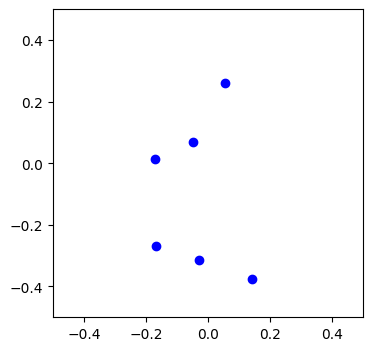

Loss = 0.973620
296


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


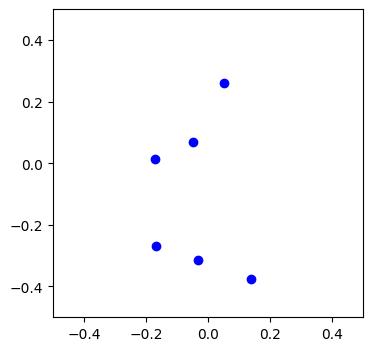

Loss = 0.971885
297


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.05s/it]


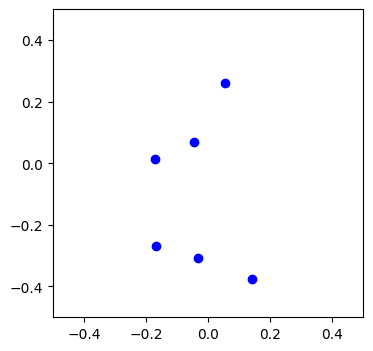

Loss = 0.966937
298


100%|█████████████████████████████████████████████| 7/7 [00:35<00:00,  5.12s/it]


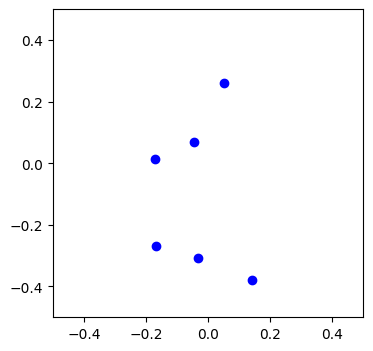

Loss = 0.973090
299


In [ ]:
optimizer = torch.optim.Adam([masses_presoftplus], lr=1.0)
warmup_epochs = 20
warmup_scheduler = LinearWarmup(optimizer, warmup_epochs=warmup_epochs)
plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=0.01)

masses_try = []
losses = []

for epoch in range(0, 300):
    optimizer.zero_grad()              
    endpoints = forward(initial_xs=initial_xs, initial_vs=initial_vs, masses=masses_presoftplus)
    l = loss(endpoints, y, masses_presoftplus, 0.0)
    plot_forward(endpoints)
    l.backward(retain_graph=True)
#     print(masses)
    masses_try.append(masses_presoftplus.detach().numpy().copy())
    optimizer.step()
    
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        plateau_scheduler.step(l)
    
    print(f"Loss = {l.item():.6f}")
    print(epoch)
    losses.append(l.item())

In [15]:
losses2 = np.array(losses)

In [16]:
np.save("losses1143.npy", losses2)